
--- Loading Data from: Spot EU Gas Merged_Hourly_Data.csv ---
Data from 'Spot EU Gas Merged_Hourly_Data.csv' loaded successfully. Shape: (89088, 23)

--- Data Quality Report for: Spot EU Gas Merged_Hourly_Data.csv ---
No duplicate timestamps found.

Missing Data Summary:
                              Missing Values  Percentage (%)
Wind offshore Installed [MW]           80304       90.140086
Nuclear [MWh]                           9492       10.654634
Lignite [MWh]                           1416        1.589440
Hard coal [MWh]                         1416        1.589440
Net Export [MWh]                        1416        1.589440
Fossil gas installed[MW]                1416        1.589440
Photovoltaics installed [MW]            1416        1.589440
Wind onshore installed [MW]             1416        1.589440
Other conventional [MWh]                1416        1.589440
Hydro pumped storage [MWh]              1416        1.589440
Fossil gas [MWh]                        1416        1.58

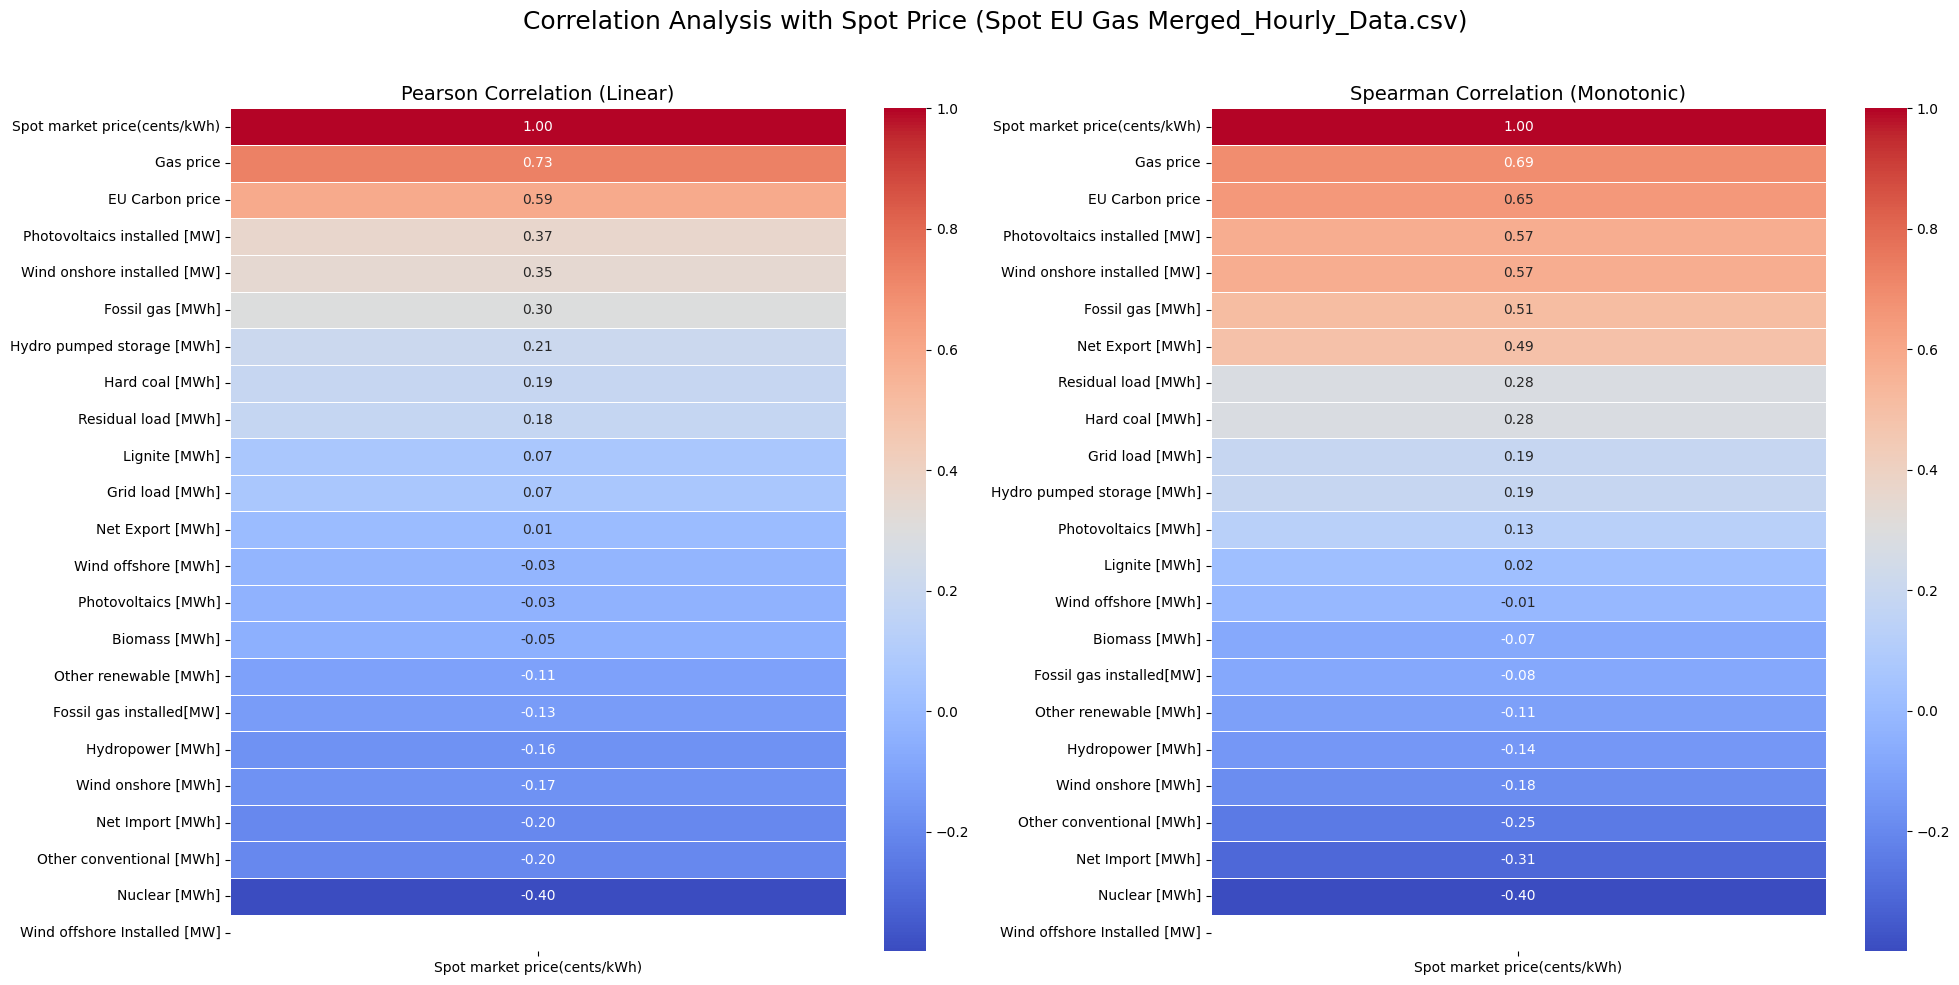


--- Loading Data from: Spot Price_less variables_Hourly_Data.csv ---
Data from 'Spot Price_less variables_Hourly_Data.csv' loaded successfully. Shape: (87672, 9)

--- Data Quality Report for: Spot Price_less variables_Hourly_Data.csv ---
No duplicate timestamps found.

Missing Data Summary:
                              Missing Values  Percentage (%)
Spot market price(cents/kWh)               1        0.001141

--- Correlation Analysis for: Spot Price_less variables_Hourly_Data.csv ---

Pearson Correlation with Spot Price (Spot Price_less variables_Hourly_Data.csv):
 Wind onshore [MWh]             -0.167596
Photovoltaics [MWh]            -0.032127
Grid load [MWh]                 0.067039
Residual load [MWh]             0.184590
Wind onshore installed [MW]     0.346250
Photovoltaics installed [MW]    0.365003
EU Carbon price                 0.585923
Gas price                       0.733914
Spot market price(cents/kWh)    1.000000
Name: Spot market price(cents/kWh), dtype: float64

Spea

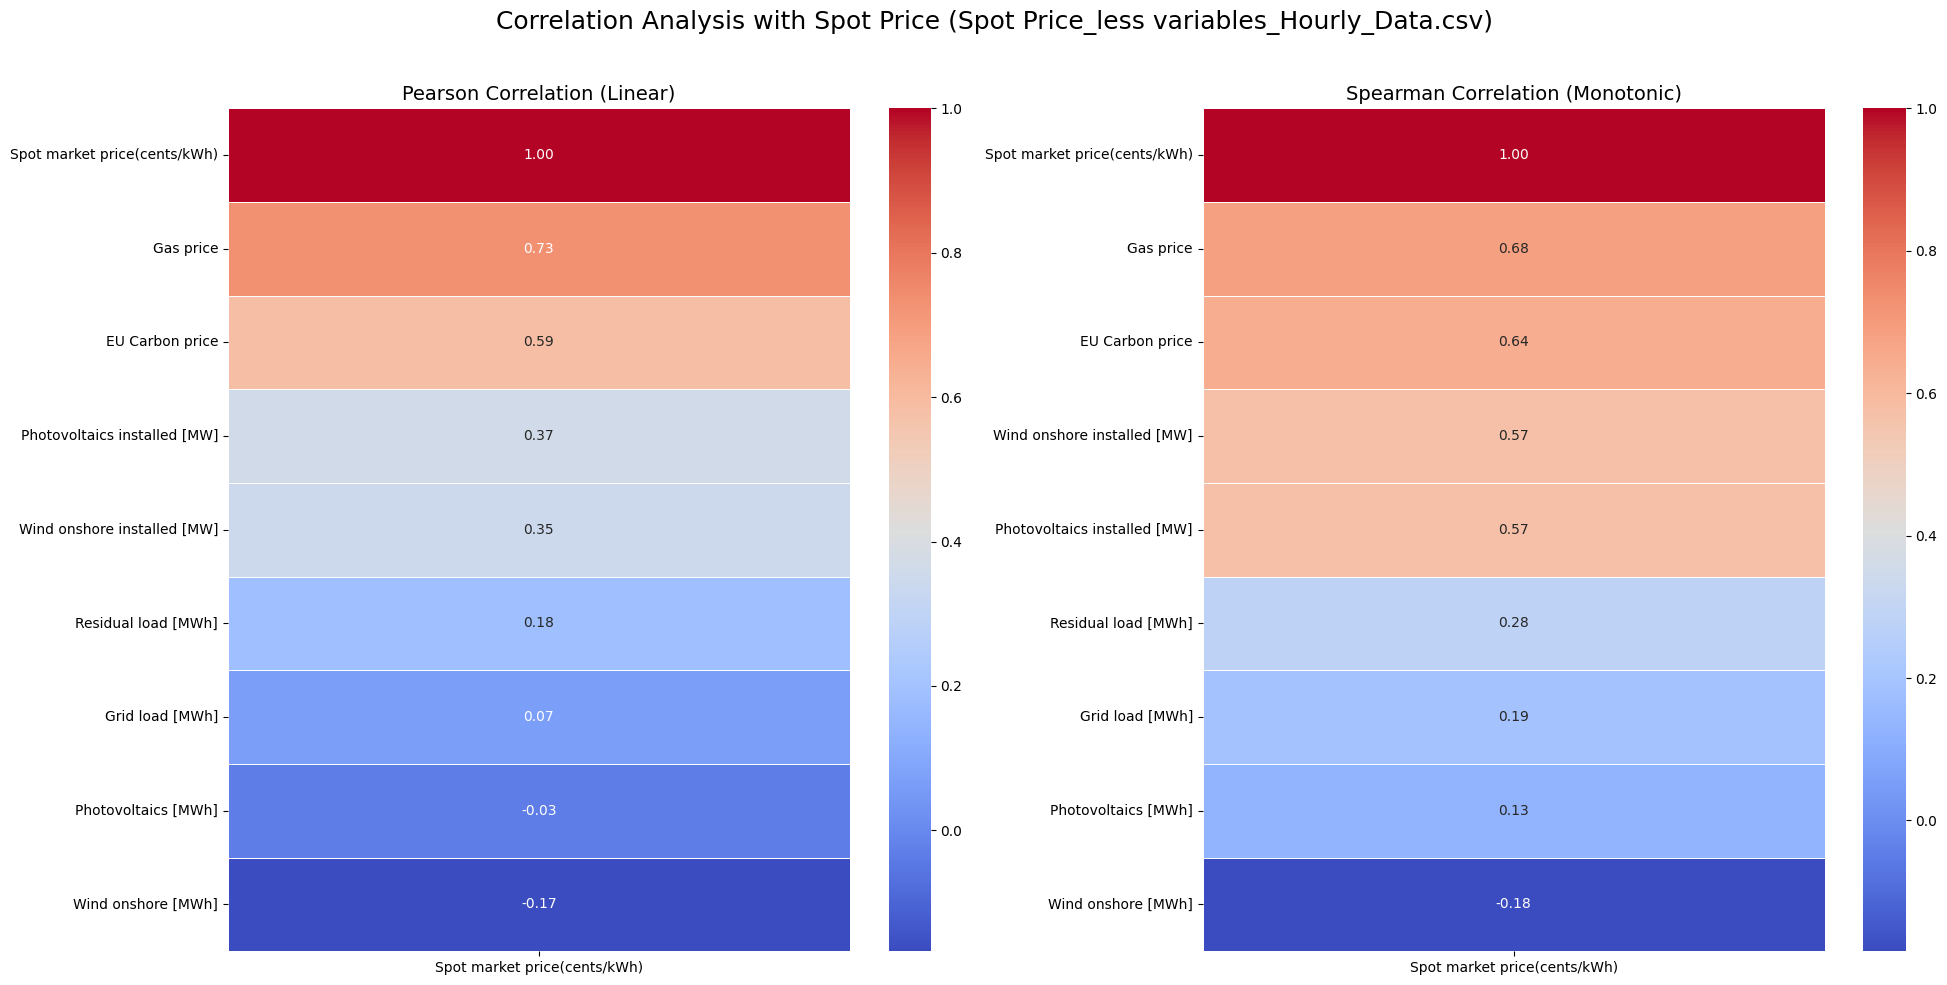


--- Investigating Seasonality using Decomposition ---

2. Decomposing pre-2022 data to find more stable and underlying seasonal patterns...

--- Performing Seasonal Decomposition on: Pre-2022 Data (Daily Cycle) (Period=24) ---


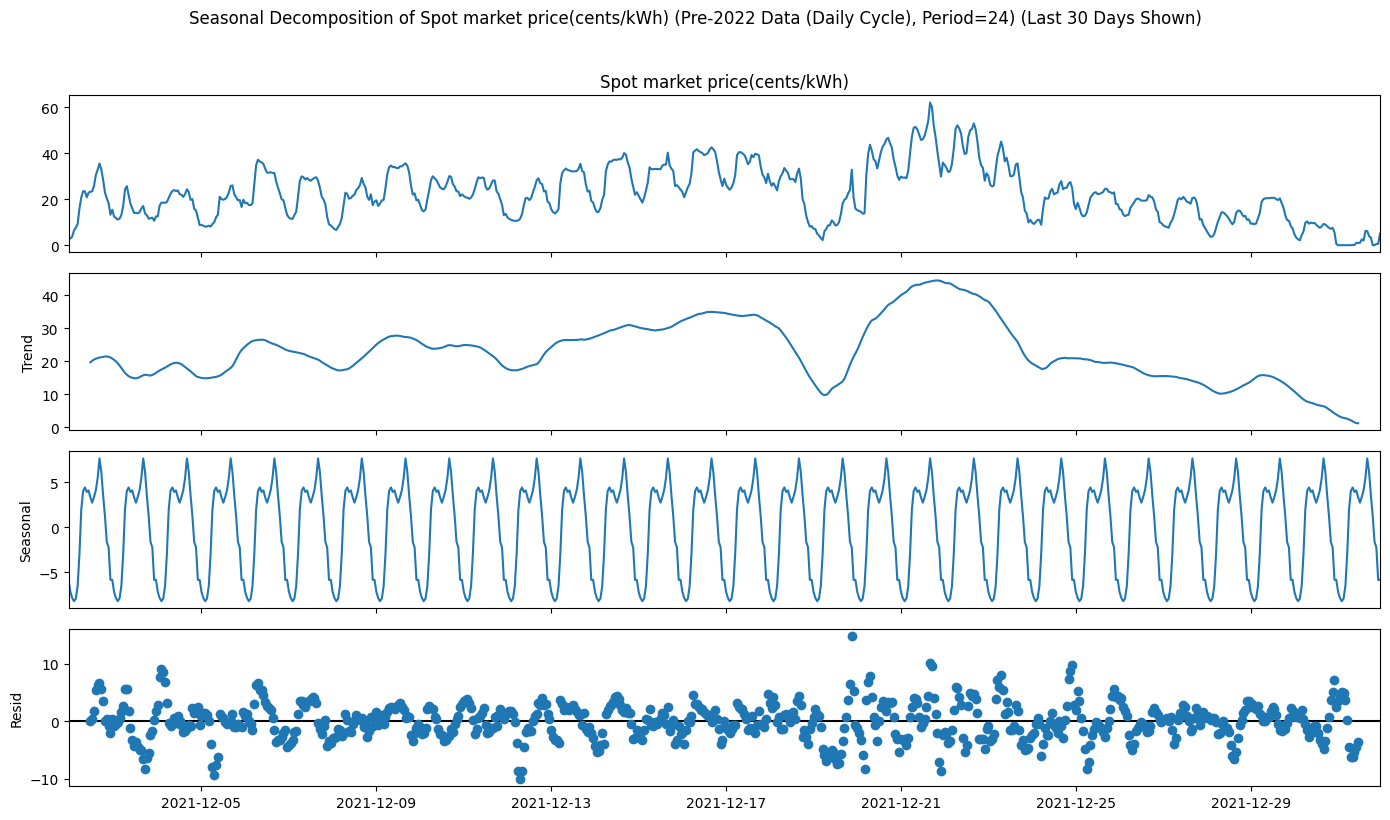


--- Performing Seasonal Decomposition on: Pre-2022 Data (Weekly Cycle) (Period=168) ---


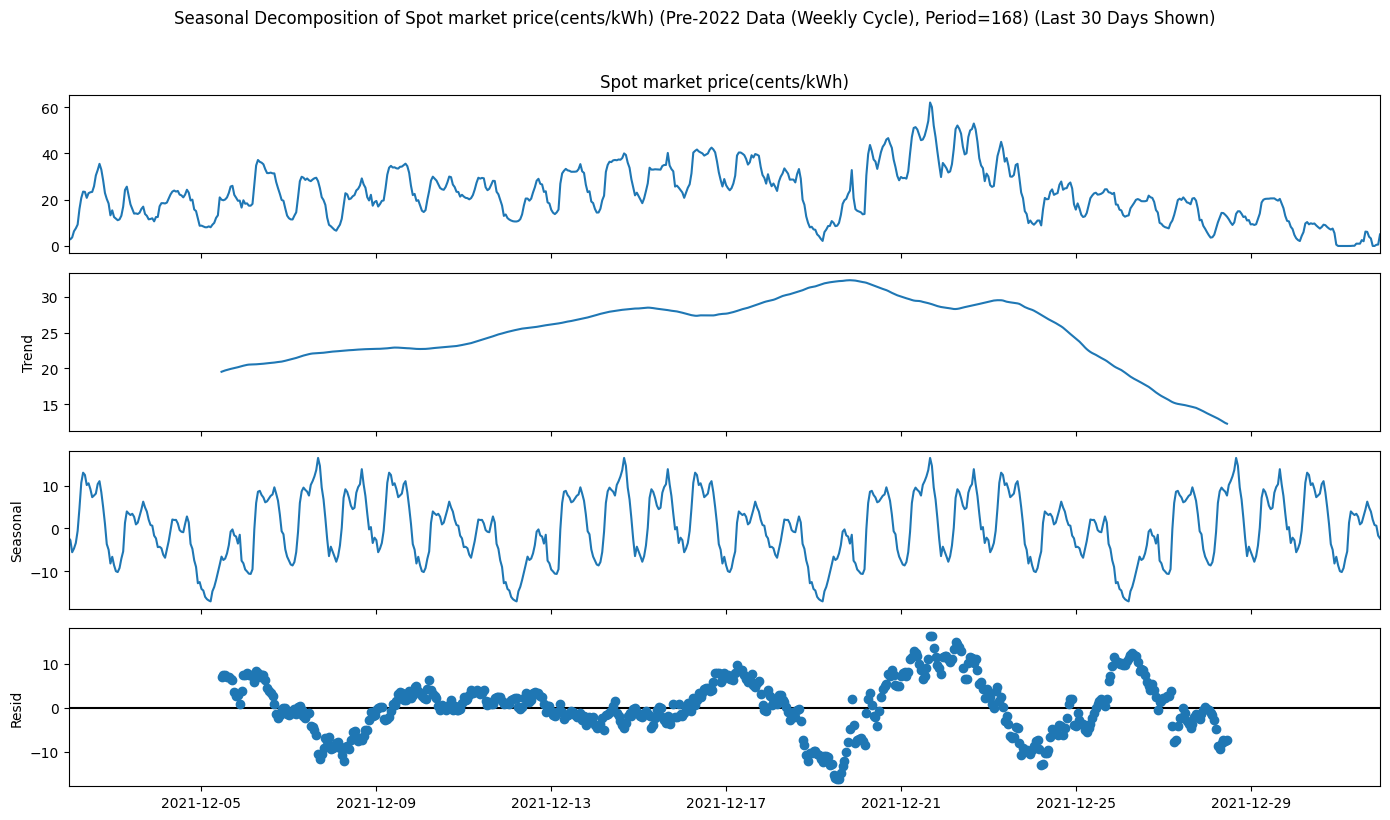


3. Decomposing post-2022 data to observe recent patterns...

--- Performing Seasonal Decomposition on: Post-2022 Data (Daily Cycle) (Period=24) ---


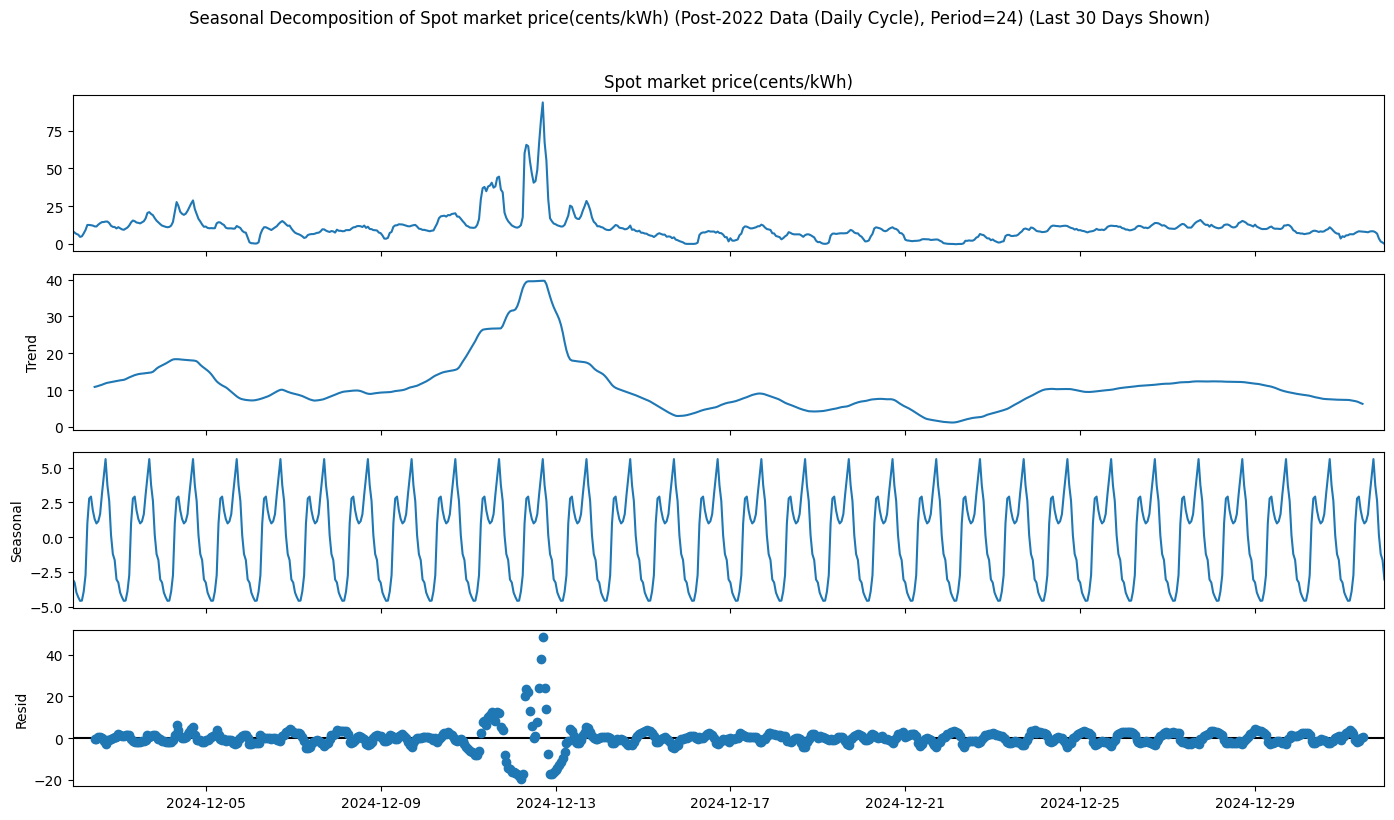


--- Performing Seasonal Decomposition on: Post-2022 Data (Weekly Cycle) (Period=168) ---


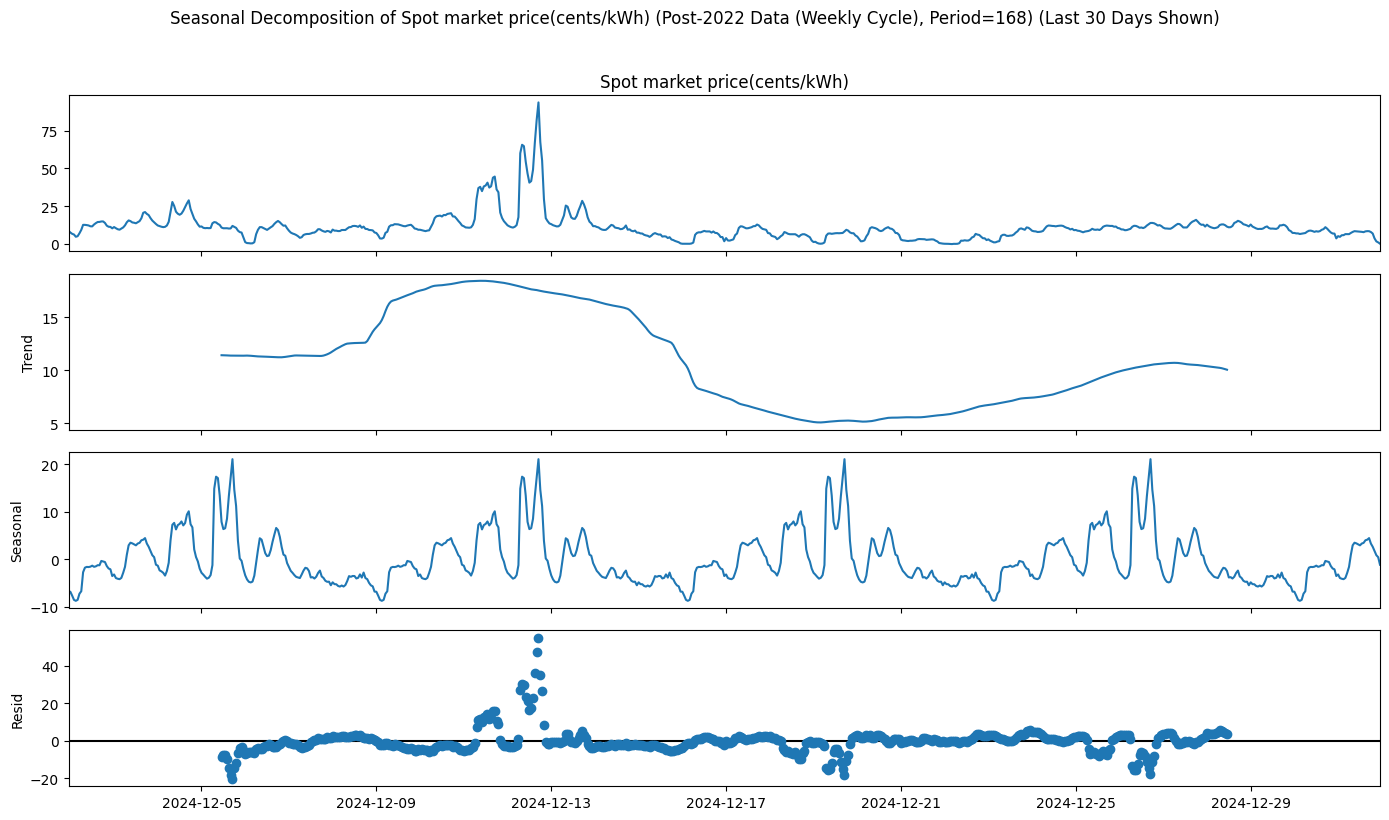


--- Analyzing Year-to-Year Negative Price Hours by Season ---

Total Negative Hours per Year, by Season:
 Season  Spring  Summer  Fall  Winter
Year                                
2015        45       3    31      47
2016        27       2    14      54
2017        33      15    48      51
2018        55       0     9      69
2019        73      37    20      81
2020       116      36    33     113
2021        87      31     7      14
2022        27       5     0      38
2023        53      99    63      85
2024       140     213    76      28


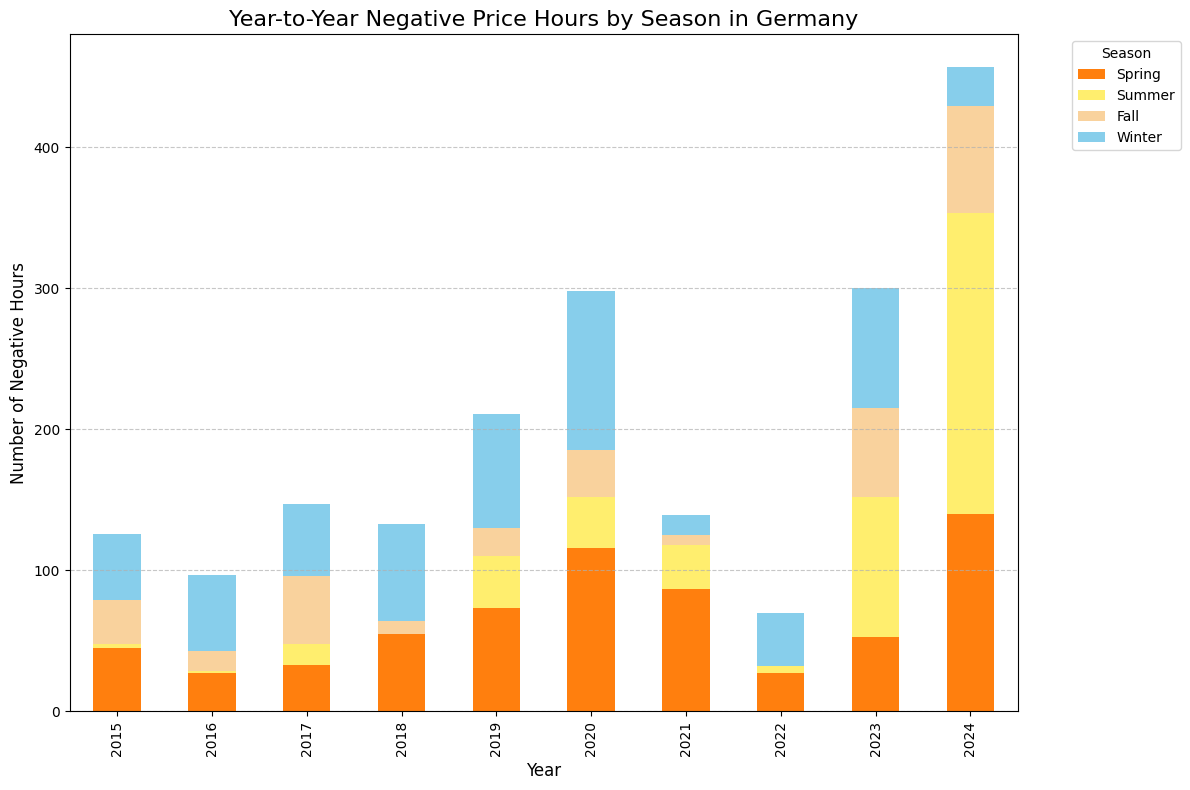


--- End of Exploratory Analysis ---


In [1]:

#EDA Analysis


import pandas as pd             # Used for working with data tables (DataFrames)
import numpy as np              # Used for numerical operations, especially with arrays (like handling infinity)
import matplotlib.pyplot as plt # Used for creating static, interactive, and animated visualizations
import seaborn as sns           # Built on matplotlib, provides a high-level interface for drawing attractive and informative statistical graphics
from statsmodels.tsa.seasonal import seasonal_decompose # Essential tool for breaking down time series into trend, seasonal, and residual components
import warnings                 # Used to manage warning messages that Python might generate

# This line tells Python to ignore common warnings that might pop up,
# especially from libraries like statsmodels, keeping the output clean and focused.
warnings.filterwarnings("ignore")

# --- SECTION 1: HELPER FUNCTIONS ---
# These are reusable blocks of code (functions) that perform specific tasks.
# Defining them at the beginning makes the main part of the script cleaner and easier to read.

def load_and_prepare(file_path, file_name=""):
    """
    Loads data from a CSV file, cleans it, and prepares it for time series analysis.
    
    Args:
        file_path (str): The path to the CSV file.
        file_name (str): A descriptive name for the file (used in print statements).
        
    Returns:
        pandas.DataFrame: The loaded and prepared DataFrame, or None if an error occurs.
    """
    print(f"\n--- Loading Data from: {file_name} ---")
    try:
        # Read the CSV file into a pandas DataFrame.
        # 'parse_dates=['Date']' tells pandas to treat the 'Date' column as actual date/time objects.
        # 'index_col='Date'' sets the 'Date' column as the DataFrame's index, which is crucial for time series.
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        
        # Loop through all columns to check if any are 'object' type (usually text/strings).
        # This is important for numerical columns that might have commas (e.g., "1,234.56")
        # and need to be converted to actual numbers.
        for col in df.columns:
            if df[col].dtype == 'object':
                # Convert the column to string, replace commas with nothing, then convert to numeric.
                # 'errors='coerce'' means if a value cannot be converted to a number, it becomes NaN (Not a Number).
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
        
        # Sort the DataFrame by its Date index to ensure chronological order.
        # 'asfreq('H')' resamples the data to an hourly frequency ('H').
        # If there are any missing hours, it inserts them and fills the values with NaN.
        df = df.sort_index().asfreq('H')
        
        # Replace any infinite values (positive or negative) with NaN.
        # Infinite values can cause issues in statistical calculations.
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        print(f"Data from '{file_name}' loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please check the file path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading and preparing data: {e}")
        return None

def data_quality_check(df, df_name=""):
    """
    Performs a basic data quality check, reporting missing values and duplicate timestamps.
    
    Args:
        df (pandas.DataFrame): The DataFrame to check.
        df_name (str): A descriptive name for the DataFrame (used in print statements).
        
    Returns:
        pandas.DataFrame: A report of missing values, or None if the DataFrame is empty.
    """
    print(f"\n--- Data Quality Report for: {df_name} ---")
    if df is None:
        print("DataFrame is empty. Cannot perform quality check.")
        return None
        
    # Check for duplicate timestamps in the DataFrame's index.
    duplicate_indices = df.index.duplicated().sum()
    if duplicate_indices > 0:
        print(f"Found {duplicate_indices} duplicate timestamps (hours) in the index.")
    else:
        print("No duplicate timestamps found.")

    # Count missing (NaN) values in each column.
    missing_values = df.isnull().sum()
    # Calculate the percentage of missing values for each column.
    missing_percent = (missing_values / len(df)) * 100
    
    # Create a small report DataFrame for missing values.
    missing_report = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_percent})
    # Filter the report to show only columns that actually have missing values.
    missing_report = missing_report[missing_report['Missing Values'] > 0]
    
    if not missing_report.empty:
        print("\nMissing Data Summary:")
        # Print the report, sorted by the number of missing values (highest first).
        print(missing_report.sort_values(by='Missing Values', ascending=False))
    else:
        print("\nNo missing values found.")
    return missing_report

def correlation_analysis(df, target_variable='Spot market price(cents/kWh)', df_name=""):
    """
    Computes and visualizes Pearson and Spearman correlations side-by-side with the target variable.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing numerical data.
        target_variable (str): The name of the column to correlate others against.
        df_name (str): A descriptive name for the DataFrame (used in print statements).
    """
    print(f"\n--- Correlation Analysis for: {df_name} ---")
    if target_variable not in df.columns:
        print(f"Target variable '{target_variable}' not found in {df_name}. Skipping correlation analysis.")
        return

    # Select only numerical columns for correlation calculation.
    df_numeric = df.select_dtypes(include=np.number)
    
    # Calculate Pearson correlation: Measures linear relationships.
    pearson_corr = df_numeric.corr(method='pearson')
    # Calculate Spearman correlation: Measures monotonic (consistently increasing/decreasing) relationships.
    spearman_corr = df_numeric.corr(method='spearman')

    print(f"\nPearson Correlation with Spot Price ({df_name}):\n", pearson_corr[target_variable].sort_values())
    print(f"\nSpearman Correlation with Spot Price ({df_name}):\n", spearman_corr[target_variable].sort_values())

    # Create a figure with two subplots arranged side-by-side.
    fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # 1 row, 2 columns
    fig.suptitle(f'Correlation Analysis with Spot Price ({df_name})', fontsize=18)

    # Plot Pearson Correlation as a heatmap.
    sns.heatmap(
        pearson_corr[[target_variable]].sort_values(by=target_variable, ascending=False), 
        annot=True,      # Show the correlation values on the heatmap.
        cmap='coolwarm', # Color map (red for negative, blue for positive correlation).
        fmt=".2f",       # Format annotation values to 2 decimal places.
        linewidths=.5,   # Add lines between cells for better separation.
        ax=axes[0]       # Plot on the first subplot.
    )
    axes[0].set_title("Pearson Correlation (Linear)", fontsize=14)

    # Plot Spearman Correlation as a heatmap on the second subplot.
    sns.heatmap(
        spearman_corr[[target_variable]].sort_values(by=target_variable, ascending=False), 
        annot=True, 
        cmap='coolwarm', 
        fmt=".2f", 
        linewidths=.5, 
        ax=axes[1] # Plot on the second subplot.
    )
    axes[1].set_title("Spearman Correlation (Monotonic)", fontsize=14)
    
    # Adjust layout to prevent titles/labels from overlapping, especially the main suptitle.
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show() # Display the correlation plots.

def seasonal_decomposition_analysis(series, period=24, series_name="", plot_days=None, show_zoomed_seasonal=True):
    """
    Performs seasonal decomposition on a time series and plots the results.
    It breaks down the series into trend, seasonal, and residual components.
    
    Args:
        series (pandas.Series): The time series data to decompose.
        period (int): The number of data points in one complete seasonal cycle (e.g., 24 for daily, 168 for weekly).
        series_name (str): A descriptive name for the series (used in plot titles).
        plot_days (int, optional): If provided, the main decomposition plot will show data
                                   only for the last 'plot_days' to improve visibility of seasonality.
        show_zoomed_seasonal (bool): If True, also plots a zoomed-in view of the seasonal component.
    """
    print(f"\n--- Performing Seasonal Decomposition on: {series_name} (Period={period}) ---")
    
    # Interpolate (fill in) any missing values in the series to ensure continuity for decomposition.
    # '.dropna()' first removes any existing NaNs to find the min/max dates.
    # '.reindex()' creates a new index with all hourly timestamps between min and max.
    # '.interpolate()' fills the newly created NaNs (and any original NaNs) linearly.
    series_filled = series.dropna().reindex(pd.date_range(start=series.dropna().index.min(), end=series.dropna().index.max(), freq='H')).interpolate()
    
    # Check if the series is long enough to perform decomposition.
    # seasonal_decompose requires at least two full periods of data.
    if len(series_filled) < 2 * period:
        print(f"Error: Time series '{series_name}' is too short for decomposition (needs at least {2 * period} data points). Skipping decomposition.")
        return None, None # Return None for decomposition and series_for_main_plot if error

    # Determine which part of the series to use for the main decomposition plot.
    # By default, it's the full series. If 'plot_days' is specified, it's a sliced version.
    series_for_main_plot = series_filled.copy()
    plot_title_suffix = "" # Suffix for the plot title, indicating if a subset is shown.

    if plot_days is not None and plot_days > 0:
        # Calculate the start date for the reduced time frame (e.g., last 3 days).
        end_date = series_filled.index.max()
        start_date_reduced = end_date - pd.DateOffset(days=plot_days)
        # Slice the series to include only the data for the specified number of days.
        series_for_main_plot = series_filled.loc[start_date_reduced:end_date]
        plot_title_suffix = f" (Last {plot_days} Day{'s' if plot_days > 1 else ''} Shown)"

        # Safety checks: If slicing results in an empty or too short series, revert to full range.
        if series_for_main_plot.empty:
            print(f"Warning: After reducing to last {plot_days} day(s), the series for plotting is empty. Plotting full range instead.")
            series_for_main_plot = series_filled.copy()
            plot_title_suffix = "" # Reset suffix
        elif len(series_for_main_plot) < 2 * period:
            print(f"Warning: After reducing to last {plot_days} day(s), the series for plotting is too short for decomposition ({len(series_for_main_plot)} points, need at least {2 * period}). Plotting full range instead.")
            series_for_main_plot = series_filled.copy()
            plot_title_suffix = "" # Reset suffix

    # Perform the seasonal decomposition on the (potentially sliced) series for plotting.
    # 'model='additive'' is used when the magnitude of the seasonal fluctuations
    # does not change with the level of the time series (e.g., seasonal peaks are roughly constant).
    decomposition = seasonal_decompose(series_for_main_plot, model='additive', period=period)
    
    # Plot the full decomposition (Original, Trend, Seasonal, Residual components).
    fig = decomposition.plot()
    fig.set_size_inches(14, 8) # Set the size of the plot for better viewing.
    # Add a main title to the entire plot, including details about the series and period.
    fig.suptitle(f'Seasonal Decomposition of {series.name} ({series_name}, Period={period}){plot_title_suffix}', y=1.02)
    plt.tight_layout() # Adjust plot layout to prevent labels/titles from overlapping.
    plt.show() # Display the plot.
    
    # --- Zoomed-in View of the Seasonal Component ---
    # This plot is crucial for high-frequency data over long periods.
    # The 'Seasonal' component in the main plot might look like a solid block
    # because many cycles are compressed into a small space. This zoomed-in plot
    # shows the actual repeating pattern clearly.
    if show_zoomed_seasonal:
        print(f"\n--- Zoomed-in View of the Seasonal Component for: {series_name} (Period={period}) ---")
        plt.figure(figsize=(12, 5)) # Create a new, smaller figure for this specific plot.
        
        # 'decomposition.seasonal.head(period * 3)' takes the first 3 full cycles of the extracted seasonal pattern.
        # For daily (period=24), this shows 3 days of hourly seasonal pattern.
        # For weekly (period=168), this shows 3 weeks of hourly seasonal pattern.
        decomposition.seasonal.head(period * 3).plot()
        
        plt.title(f'Isolated Seasonal Pattern for {series_name} (First 3 Cycles)')
        plt.xlabel('Time within Cycle') # A more appropriate label for a few repeating cycles.
        plt.ylabel('Seasonal Component')
        plt.grid(True) # Add a grid for easier reading of values.
        plt.show() # Display this zoomed-in plot.

    return decomposition, series_for_main_plot # Return decomposition object and the series that was plotted

# Removed plot_comparative_seasonal_components_grid function as per user request.

def plot_yearly_negative_hours_by_season(df, target_variable='Spot market price(cents/kWh)'):
    """
    Calculates and plots the total number of hours with negative spot prices per year,
    stacked by season (Winter, Spring, Summer, Fall).
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the spot price data.
        target_variable (str): The name of the column containing spot prices.
    """
    print("\n--- Analyzing Year-to-Year Negative Price Hours by Season ---")
    
    # Filter the DataFrame to include only rows where the target_variable (spot price) is less than 0.
    negative_prices = df[df[target_variable] < 0].copy()
    
    if negative_prices.empty:
        print("No negative price hours found to plot in the dataset. Skipping this analysis.")
        return
        
    # Define a mapping from month numbers to seasons.
    month_to_season = {
        1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
    }
    
    # Extract the year from the DataFrame's index (Date).
    negative_prices['Year'] = negative_prices.index.year
    # Map the month of each timestamp to its corresponding season.
    negative_prices['Season'] = negative_prices.index.month.map(month_to_season)
    
    # Create a pivot table to count the number of negative price hours for each season, per year.
    # 'index='Year'' makes years the rows.
    # 'columns='Season'' makes seasons the columns.
    # 'aggfunc='size'' counts the number of occurrences (hours).
    # 'fill_value=0' ensures that if a season has no negative hours in a year, it shows 0 instead of NaN.
    seasonal_yearly_counts = negative_prices.pivot_table(index='Year', columns='Season', aggfunc='size', fill_value=0)
    
    # Ensure all seasons are present in the columns, even if they had no negative hours.
    # This ensures consistent plotting order.
    all_seasons = ['Spring', 'Summer', 'Fall', 'Winter']
    for season in all_seasons:
        if season not in seasonal_yearly_counts.columns: 
            seasonal_yearly_counts[season] = 0 # Add column with zeros if season is missing.
    seasonal_yearly_counts = seasonal_yearly_counts[all_seasons] # Reorder columns for consistent display.
    
    print("\nTotal Negative Hours per Year, by Season:\n", seasonal_yearly_counts)
    
    # Create a bar plot to visualize the results.
    fig, ax = plt.subplots(figsize=(12, 8)) # Set the figure size.
    
    # Plot stacked bars: each bar represents a year, segmented by season.
    seasonal_yearly_counts.plot(
        kind='bar', 
        stacked=True, # Stack the seasonal counts on top of each other.
        ax=ax,        # Plot on the created axes.
        color=['#ff7f0e', '#ffee6e', '#f9d29d', '#87ceeb'] # Custom colors for seasons.
    )
    
    ax.set_title('Year-to-Year Negative Price Hours by Season in Germany', fontsize=16)
    ax.set_xlabel('Year', fontsize=12) # Label for the horizontal axis.
    ax.set_ylabel('Number of Negative Hours', fontsize=12) # Label for the vertical axis.
    ax.tick_params(axis='x', rotation=90) # Rotate x-axis labels for better readability.
    ax.grid(axis='y', linestyle='--', alpha=0.7) # Add a horizontal grid.
    
    # Add a legend outside the plot area to avoid overlapping with bars.
    plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout() # Adjust layout.
    plt.show() # Display the plot.


# --- MAIN EXECUTION BLOCK ---
# This is where the script starts running and calls the functions defined above.
if __name__ == "__main__":
    # Define paths to your data files.
    full_data_path = "./Spot EU Gas Merged_Hourly_Data.csv"
    clean_data_path = "./Spot Price_less variables_Hourly_Data.csv"
    
    # --- Step 1: Analyze the initial, larger dataset ---
    # This step is included to show an example of analyzing a potentially larger dataset,
    # and to justify why a 'cleaner' dataset might be preferred for further analysis.
    df_full = load_and_prepare(full_data_path, "Spot EU Gas Merged_Hourly_Data.csv")
    if df_full is not None: # Only proceed if data loaded successfully.
        data_quality_check(df_full, "Spot EU Gas Merged_Hourly_Data.csv")
        correlation_analysis(df_full, 'Spot market price(cents/kWh)', "Spot EU Gas Merged_Hourly_Data.csv")

    # --- Step 2: Analyze the cleaner, 'less variables' dataset ---
    # This is often the primary dataset for detailed modeling due to fewer variables or better quality.
    df_clean = load_and_prepare(clean_data_path, "Spot Price_less variables_Hourly_Data.csv")
    
    if df_clean is not None: # Only proceed if the clean data loaded successfully.
        target_variable = 'Spot market price(cents/kWh)' # The key variable we are interested in.
        
        # Re-added Data Quality and Correlation Analysis.
        data_quality_check(df_clean, "Spot Price_less variables_Hourly_Data.csv")
        correlation_analysis(df_clean, target_variable, "Spot Price_less variables_Hourly_Data.csv")
        
        print("\n--- Investigating Seasonality using Decomposition ---")
        
        # --- Prepare Pre- and Post-2022 Data ---
        # Create copies to avoid SettingWithCopyWarning and ensure original data isn't modified.
        df_pre_2022 = df_clean[df_clean.index.year < 2022].copy()
        df_post_2022 = df_clean[df_clean.index.year >= 2022].copy()
        
        # --- Seasonal Decomposition for Pre-2022 Data (Daily and Weekly Cycles) ---
        # Decomposing a stable, pre-crisis period can help find true underlying seasonality
        # without the influence of recent market disruptions.
        print("\n2. Decomposing pre-2022 data to find more stable and underlying seasonal patterns...")
        if not df_pre_2022.empty:
            # Test for daily seasonality (24-hour period) on pre-2022 data.
            # 'plot_days=30' for clear visualization of the daily cycle over a month.
            seasonal_decomposition_analysis(df_pre_2022[target_variable], period=24, series_name="Pre-2022 Data (Daily Cycle)", plot_days=30, show_zoomed_seasonal=False)
            
            # Test for weekly seasonality (168-hour period) on pre-2022 data.
            # 'plot_days=30' is used here to clearly show the weekly pattern over ~4 weeks.
            seasonal_decomposition_analysis(df_pre_2022[target_variable], period=168, series_name="Pre-2022 Data (Weekly Cycle)", plot_days=30, show_zoomed_seasonal=False)
        else:
            print("No data available before 2022 to perform a stable decomposition. Skipping this step.")

        # --- Seasonal Decomposition for Post-2022 Data (Daily and Weekly Cycles) ---
        # Analyzing data from 2022 onwards to observe patterns after potential structural breaks.
        print("\n3. Decomposing post-2022 data to observe recent patterns...")
        if not df_post_2022.empty:
            # Test for daily seasonality (24-hour period) on post-2022 data.
            # 'plot_days=30' for clear visualization of the daily cycle over a month.
            seasonal_decomposition_analysis(df_post_2022[target_variable], period=24, series_name="Post-2022 Data (Daily Cycle)", plot_days=30, show_zoomed_seasonal=False)
            
            # Test for weekly seasonality (168-hour period) on post-2022 data.
            # 'plot_days=30' is used here to clearly show the weekly pattern over ~4 weeks.
            seasonal_decomposition_analysis(df_post_2022[target_variable], period=168, series_name="Post-2022 Data (Weekly Cycle)", plot_days=30, show_zoomed_seasonal=False)
        else:
            print("No data available from 2022 onwards to perform decomposition. Skipping this step.")
        
     
        plot_yearly_negative_hours_by_season(df_clean, target_variable)
    else:
        print("Could not load the clean dataset. Halting all further analysis.")

    print("\n--- End of Exploratory Analysis ---")


In [ ]:
#SARIMA search without Exog. Variables

Data shape after filtering for 2021 onwards: (35064, 9)
Data loaded successfully from './Spot Price_less variables_Hourly_Data.csv'. Initial shape: (35063, 9)

Using ORIGINAL target variable: 'Spot market price(cents/kWh)' (NO transformation).

--- Auto ARIMA for Each Season (Full SARIMAX Order) ---

--- Season 1 ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=34696.159, Time=0.30 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=31196.878, Time=8.53 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=31952.020, Time=9.46 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=34694.160, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=32796.375, Time=0.54 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=28.87 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=31733.008, Time=7.47 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=31955.974, Time=4.98 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=31194.596, Time=8.03 sec
 ARIMA(2,1,0)(0,0,0)[24] interc

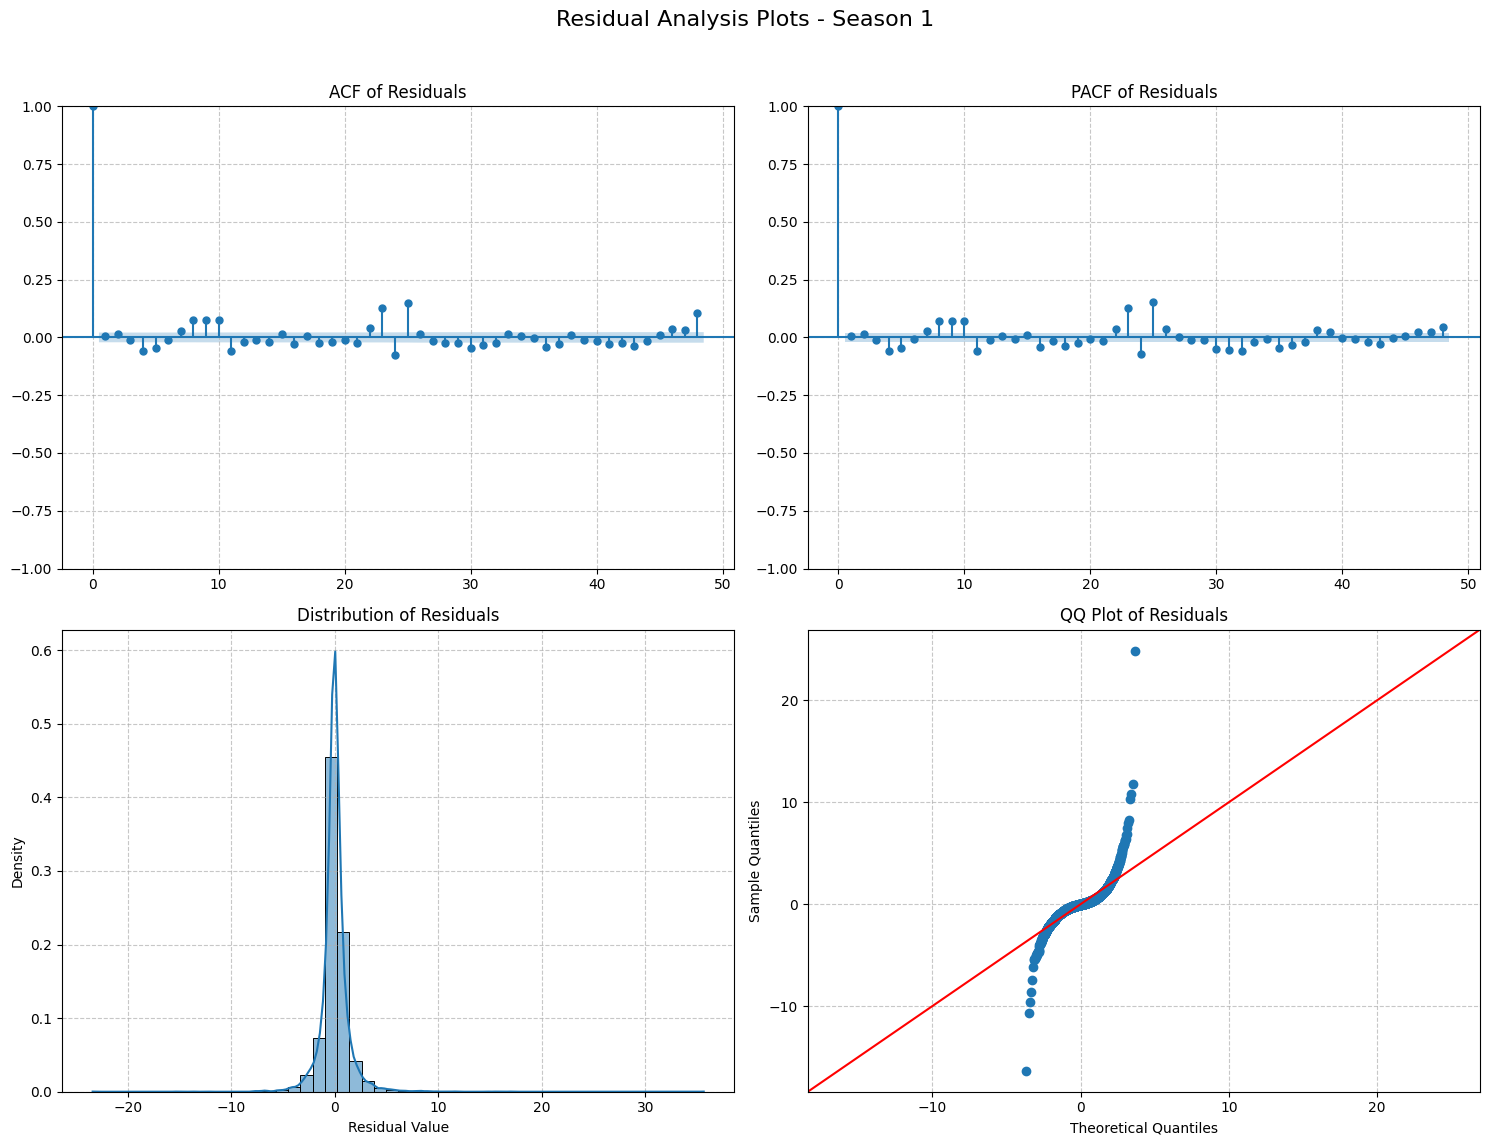


--- Season 2 ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=35148.353, Time=0.34 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=29402.147, Time=11.95 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=30664.396, Time=11.39 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=35146.354, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=32261.945, Time=0.82 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=28.03 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=30564.392, Time=8.68 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=30022.584, Time=7.21 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=29367.419, Time=15.23 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=31951.269, Time=1.20 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=40.95 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=30463.370, Time=10.22 sec
 ARIMA(3,1,0)(1,0,0)[24] intercept   : AIC=29305.593, Time=16.60 sec
 ARIMA(3,1,0)(0,0,0)[24] intercept   : AIC=31704.398, Time=1

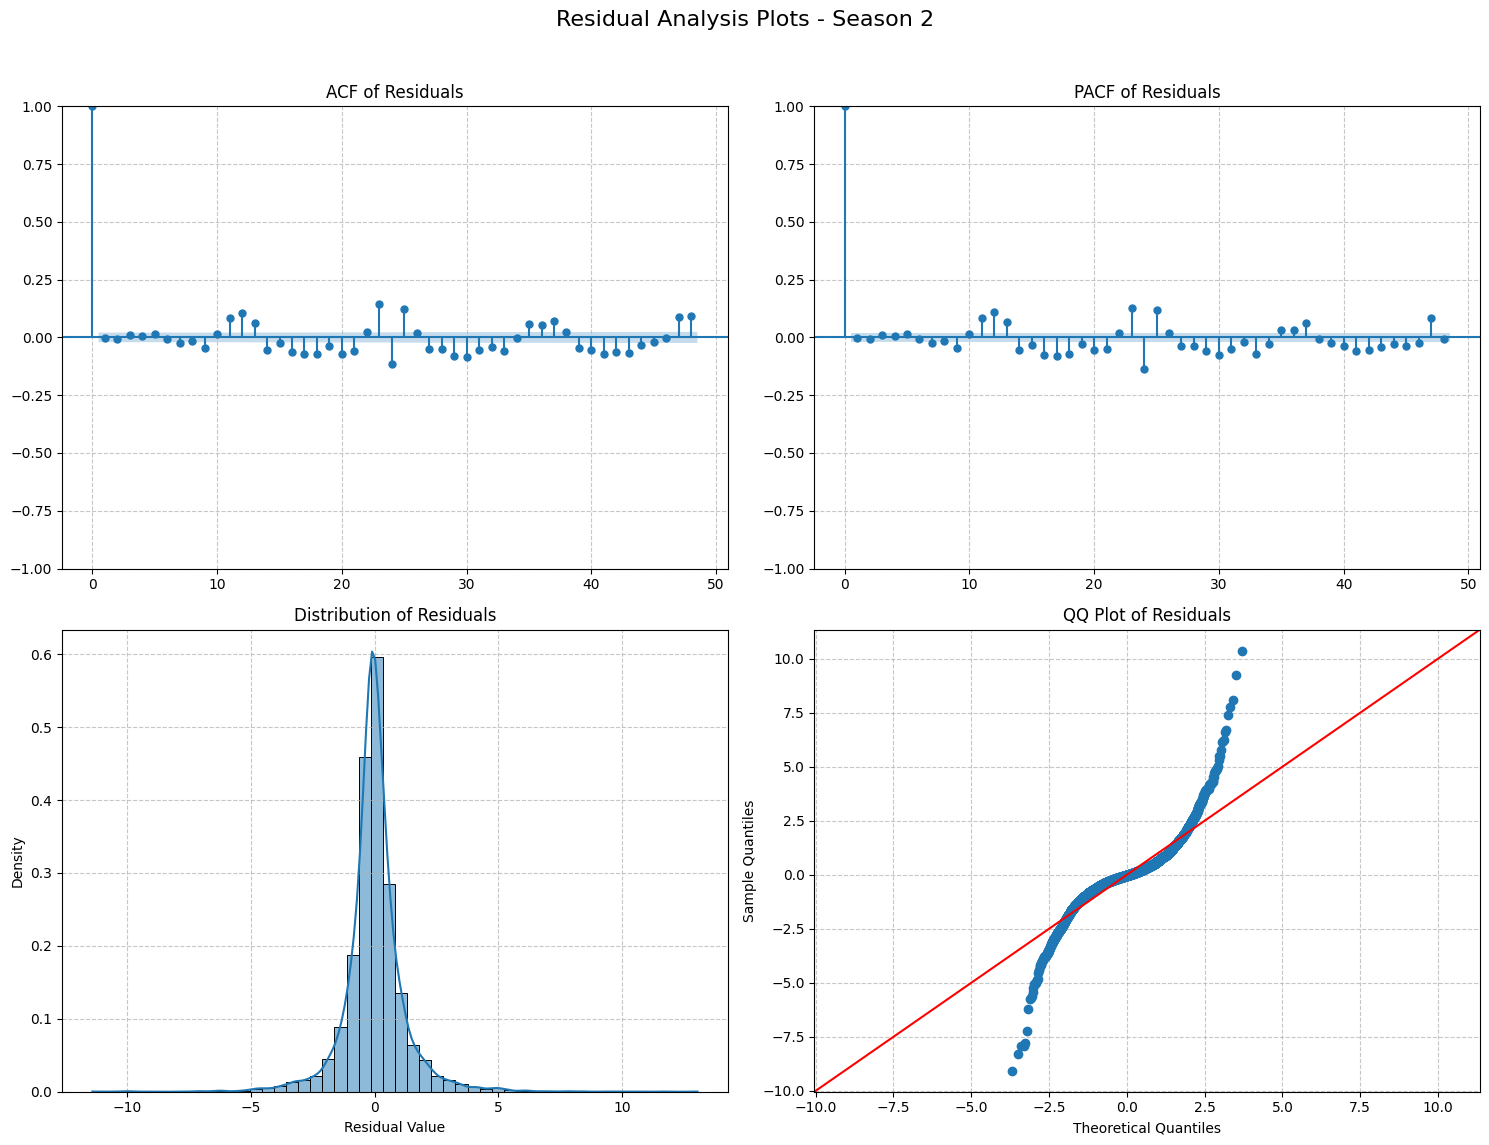


--- Season 3 ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=47015.793, Time=0.35 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=45635.260, Time=9.75 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=45718.860, Time=11.31 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=47013.793, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=46213.274, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=33.26 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=45810.055, Time=8.91 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=45977.181, Time=6.20 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=45499.785, Time=13.87 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=46107.222, Time=0.95 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=44.65 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=45692.139, Time=11.84 sec
 ARIMA(3,1,0)(1,0,0)[24] intercept   : AIC=45488.938, Time=16.74 sec
 ARIMA(3,1,0)(0,0,0)[24] intercept   : AIC=46089.064, Time=1.

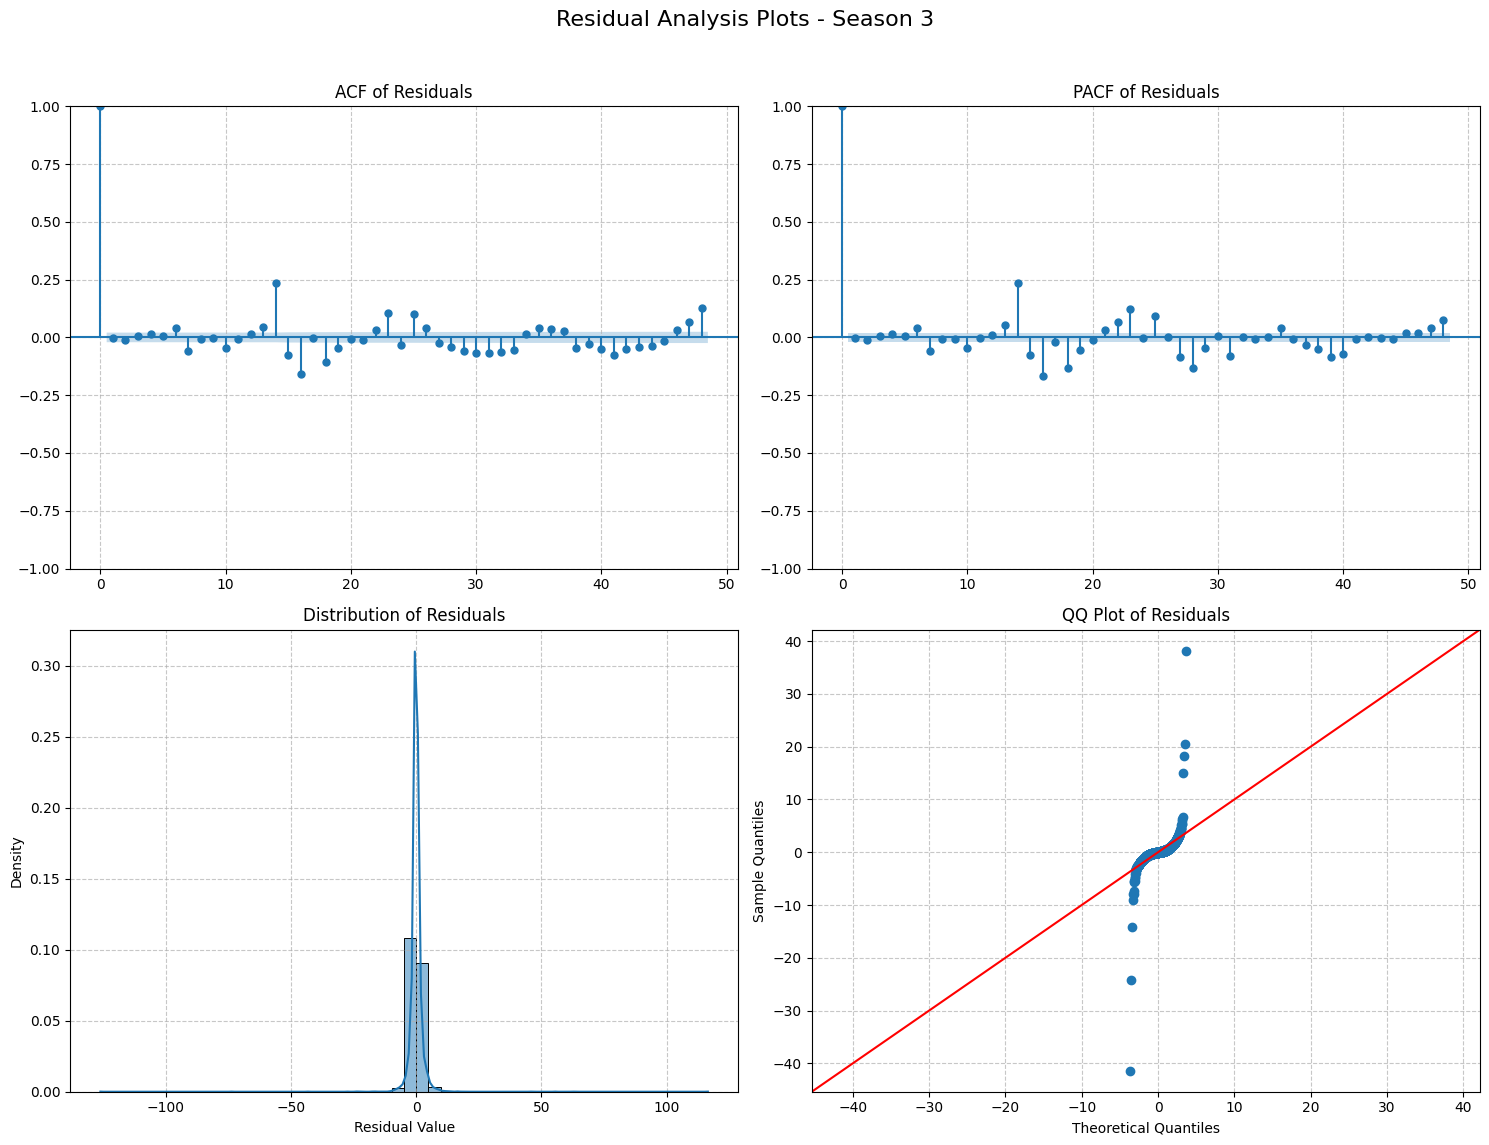


--- Season 4 ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=42900.025, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=37977.701, Time=8.28 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=39037.081, Time=7.39 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=42898.025, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=40890.550, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=16.69 sec
 ARIMA(1,1,0)(0,0,1)[24] intercept   : AIC=39063.190, Time=6.31 sec
 ARIMA(0,1,0)(1,0,0)[24] intercept   : AIC=38453.912, Time=4.88 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=37883.424, Time=10.79 sec
 ARIMA(2,1,0)(0,0,0)[24] intercept   : AIC=40610.883, Time=0.83 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=26.49 sec
 ARIMA(2,1,0)(0,0,1)[24] intercept   : AIC=38938.808, Time=8.67 sec
 ARIMA(3,1,0)(1,0,0)[24] intercept   : AIC=37796.859, Time=12.18 sec
 ARIMA(3,1,0)(0,0,0)[24] intercept   : AIC=40400.360, Time=0.95

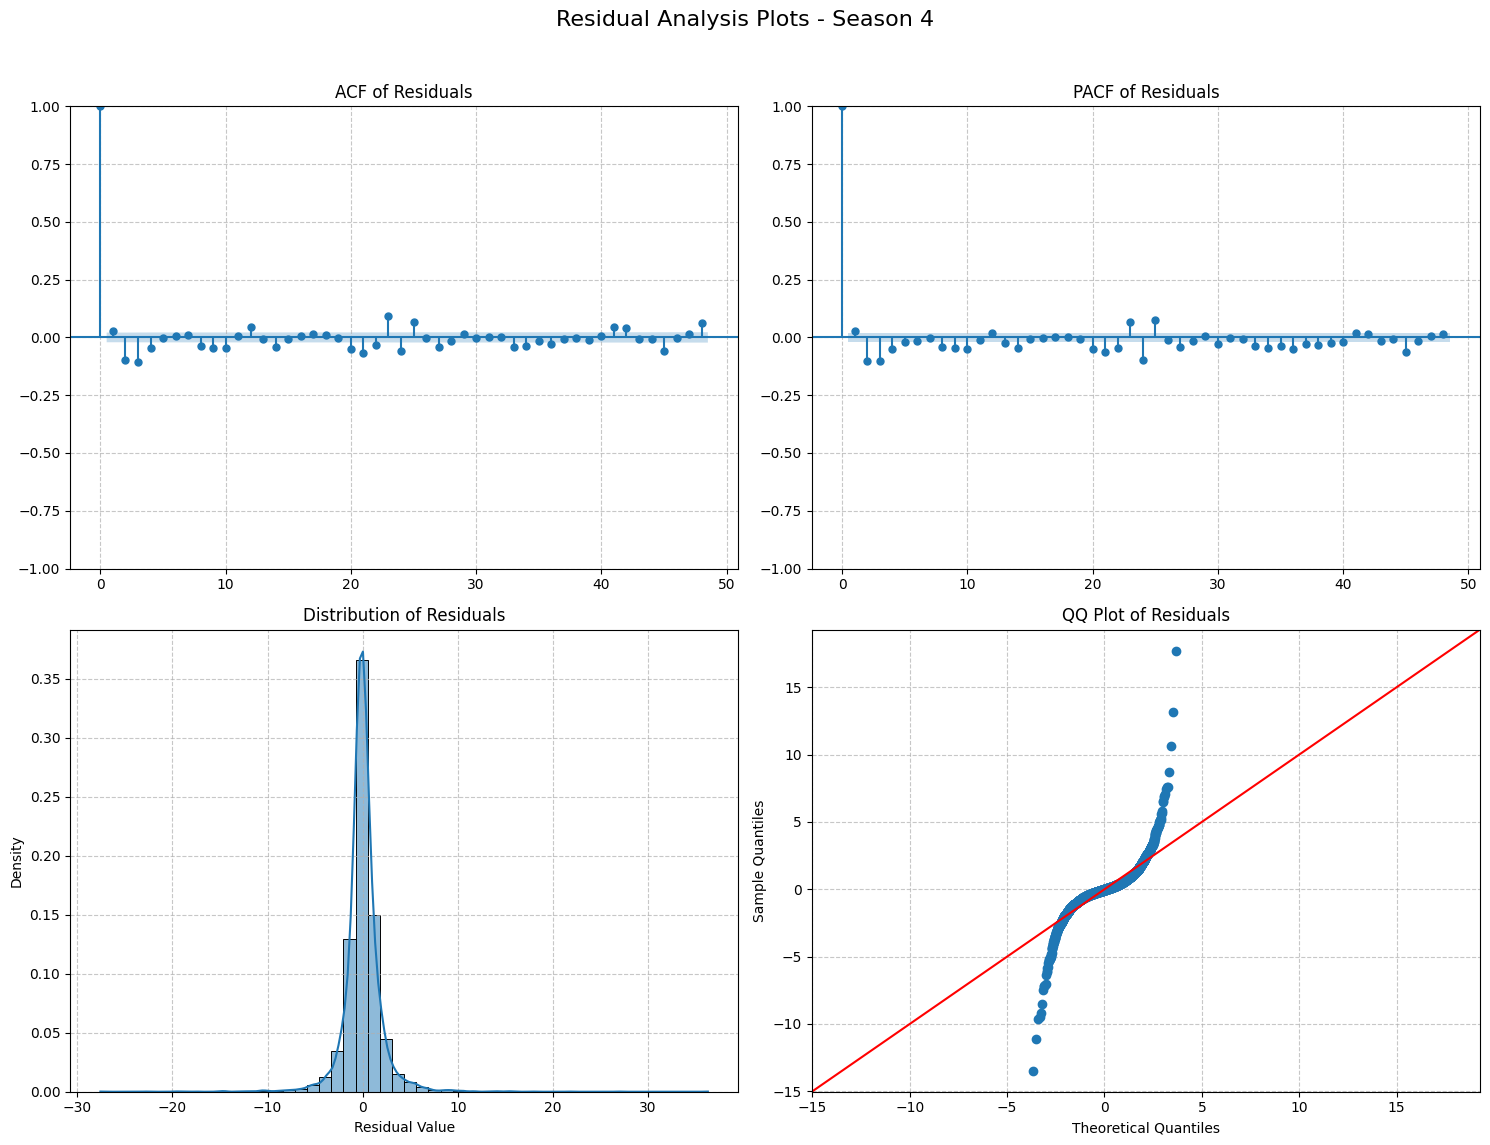


Final Best SARIMAX Orders per Season (p, d, q)(P, D, Q, m):
Season 1: ((3, 1, 2), (1, 0, 0, 24))
Season 2: ((3, 1, 1), (1, 0, 0, 24))
Season 3: ((3, 1, 3), (1, 0, 0, 24))
Season 4: ((3, 1, 2), (1, 0, 0, 24))

--- End of Second Part ---


In [1]:
import pandas as pd
import numpy as np
import sys
import warnings
from pmdarima import auto_arima # Correctly import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox # Import Ljung-Box test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import ACF and PACF plots
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting
import seaborn as sns # Import seaborn for distribution plot
import statsmodels.api as sm # Import statsmodels for QQ plot

# Suppress warnings for cleaner output during extensive calculations
warnings.filterwarnings("ignore")

# 1. Load and Prepare Data (re-included for self-contained snippet)
def load_and_prepare(file_path="./Spot Price_less variables_Hourly_Data.csv"):
    """Loads, cleans, and prepares the spot price data."""
    try:
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date').sort_index().asfreq('H')
        df = df.loc['2021-01-01':]
        print(f"Data shape after filtering for 2021 onwards: {df.shape}")
        for col in df.columns:
            # Replace comma with nothing, then convert to numeric
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
        # Drop rows where target variable is NaN, then replace any remaining inf/-inf with NaN
        df = df.dropna(subset=['Spot market price(cents/kWh)']).replace([np.inf, -np.inf], np.nan)
        return df
    except Exception as e:
        print(f"Error loading and preparing data: {e}")
        return None

# Main Execution - Second Part (after the first part in the same script)
if __name__ == "__main__":
    # --- Configuration ---
    target_variable = 'Spot market price(cents/kWh)'

    # --- Data Loading ---
    csv_file_path = './Spot Price_less variables_Hourly_Data.csv'
    try:
        df = load_and_prepare(csv_file_path) # Use the load_and_prepare function
    except FileNotFoundError:
        print(f"Error: Data file '{csv_file_path}' not found. Please ensure it's in the same directory.")
        sys.exit(1) # Exit if the primary data file is missing
    except Exception as e:
        print(f"Error during initial data loading/preparation: {e}")
        sys.exit(1)

    # Handle duplicate indices and sort the DataFrame by Date (redundant if load_and_prepare handles it, but kept for robustness)
    df = df[~df.index.duplicated(keep='first')].sort_index()
    print(f"Data loaded successfully from '{csv_file_path}'. Initial shape: {df.shape}\n")

    # --- Use ORIGINAL target variable (NO TRANSFORMATION) ---
    target_series = df[target_variable].copy()
    print(f"Using ORIGINAL target variable: '{target_variable}' (NO transformation).")

    seasonal_data = {}
    for season in range(1, 5): # Iterate for seasons 1, 2, 3, 4
        # Assuming season mapping: 1=Winter, 2=Spring, 3=Summer, 4=Fall
        # (month % 12 // 3 + 1) -> maps Jan-Mar to 1, Apr-Jun to 2, Jul-Sep to 3, Oct-Dec to 4
        # Adjust if your season definition is different
        seasonal_data[season] = df[df.index.month % 12 // 3 + 1 == season][target_variable].dropna()

    best_arima_orders_seasonal = {}
    print("\n--- Auto ARIMA for Each Season (Full SARIMAX Order) ---")
    for season, series in seasonal_data.items():
        if not series.empty:
            print(f"\n--- Season {season} ---")
            try:
                # Apply auto ARIMA to find full SARIMAX (p, d, q)(P, D, Q, m) order
                auto_arima_model = auto_arima(
                    series,
                    start_p=0,
                    start_q=0,
                    max_p=3,# Increased max_p/q for more flexibility
                    max_q=3, #Increased max_p/q for more flexibility
                    start_P=0,# Start seasonal P
                    start_Q=0, # Start seasonal Q
                    
                    max_P=1, #Max seasonal P
                    max_Q=1, # Max seasonal Q
                    m=24,#t seasonal period to 24 for hourly data (daily seasonality)
                    stepwise=True,
                    trace=True, # Show search progress
                    error_action='ignore',
                    suppress_warnings=True,
                    seasonal=True, # Crucial: We are now finding seasonal orders here
                    d=None,# Let auto_arima determine 'd' (non-seasonal differencing)
                    D=None, # Let auto_arima determine 'D' (seasonal differencing)
                    max_d=1,# Max non-seasonal differencing order
                    max_D=1, # Max seasonal differencing order
                    information_criterion='aic'
                )
                best_arima_orders_seasonal[season] = (auto_arima_model.order, auto_arima_model.seasonal_order)
                print(f"Best SARIMAX order for Season {season}: {auto_arima_model.order}{auto_arima_model.seasonal_order}")

                # --- Ljung-Box Test and Residual Plots ---
                print(f"Performing Ljung-Box test on residuals for Season {season}...")
                # Get residuals from the fitted auto_arima model
                residuals = auto_arima_model.resid()
                # Perform Ljung-Box test for several lags
                ljung_box_results = acorr_ljungbox(residuals, lags=[24, 48, 72], return_df=True)
                print(ljung_box_results)
                # Interpretation: If p-values are greater than a significance level (e.g., 0.05),
                # we fail to reject the null hypothesis, meaning residuals are white noise (no autocorrelation).

                # Create a 2x2 grid for all residual plots
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))
                fig.suptitle(f'Residual Analysis Plots - Season {season}', fontsize=16)

                # Plot ACF of residuals
                plot_acf(residuals, lags=48, ax=axes[0, 0], title='ACF of Residuals')
                axes[0, 0].grid(True, linestyle='--', alpha=0.7)

                # Plot PACF of residuals
                plot_pacf(residuals, lags=48, ax=axes[0, 1], title='PACF of Residuals')
                axes[0, 1].grid(True, linestyle='--', alpha=0.7)

                # Plot Distribution of Residuals (Histogram and KDE)
                sns.histplot(residuals, kde=True, stat='density', bins=50, ax=axes[1, 0])
                axes[1, 0].set_title('Distribution of Residuals')
                axes[1, 0].set_xlabel('Residual Value')
                axes[1, 0].set_ylabel('Density')
                axes[1, 0].grid(True, linestyle='--', alpha=0.7)

                # Plot QQ Plot of Residuals
                sm.qqplot(residuals, line='45', fit=True, ax=axes[1, 1])
                axes[1, 1].set_title('QQ Plot of Residuals')
                axes[1, 1].grid(True, linestyle='--', alpha=0.7)

                plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
                plt.show()

                # --- End Ljung-Box Test and Residual Plots ---

            except Exception as e:
                print(f"Auto ARIMA or Ljung-Box test/plotting failed for Season {season}: {e}")
                best_arima_orders_seasonal[season] = None
        else:
            print(f"No data for Season {season}. Skipping Auto ARIMA search, Ljung-Box test, and residual plots.")
            best_arima_orders_seasonal[season] = None

    print("\nFinal Best SARIMAX Orders per Season (p, d, q)(P, D, Q, m):")
    for season, order in best_arima_orders_seasonal.items():
        print(f"Season {season}: {order}")

    print("\n--- End of Second Part ---")


In [ ]:
#Seasonality Check,ACF,PACF plots for seasonal, non-seasonal orders, Li-Jung Box Evaluation

Data shape after filtering for 2015 onwards: (87672, 9)
Data loaded successfully from './Spot Price_less variables_Hourly_Data.csv'. Initial shape: (87672, 9)

Using ORIGINAL target variable: 'Spot market price(cents/kWh)' (NO transformation).
Dropped 1 rows due to NaNs in target or exogenous variables. Remaining rows: 87671

             PLOTS FOR ORIGINAL EXOGENOUS VARIABLES (ALL DATA, 2015-2024)

Descriptive Statistics for Original Exogenous Variables (All Data, 2015-2024):
          Gas price  EU Carbon price  Wind onshore [MWh]  Photovoltaics [MWh]  \
count  87671.000000     87671.000000        87671.000000         87671.000000   
mean      40.752878        37.119657        10649.910378          5186.179620   
std       50.569863        30.561125         8838.703431          8175.640282   
min        4.680000         3.930000           46.500000             0.000000   
25%       16.010000         7.790000         3861.375000             0.000000   
50%       20.120000        25.11

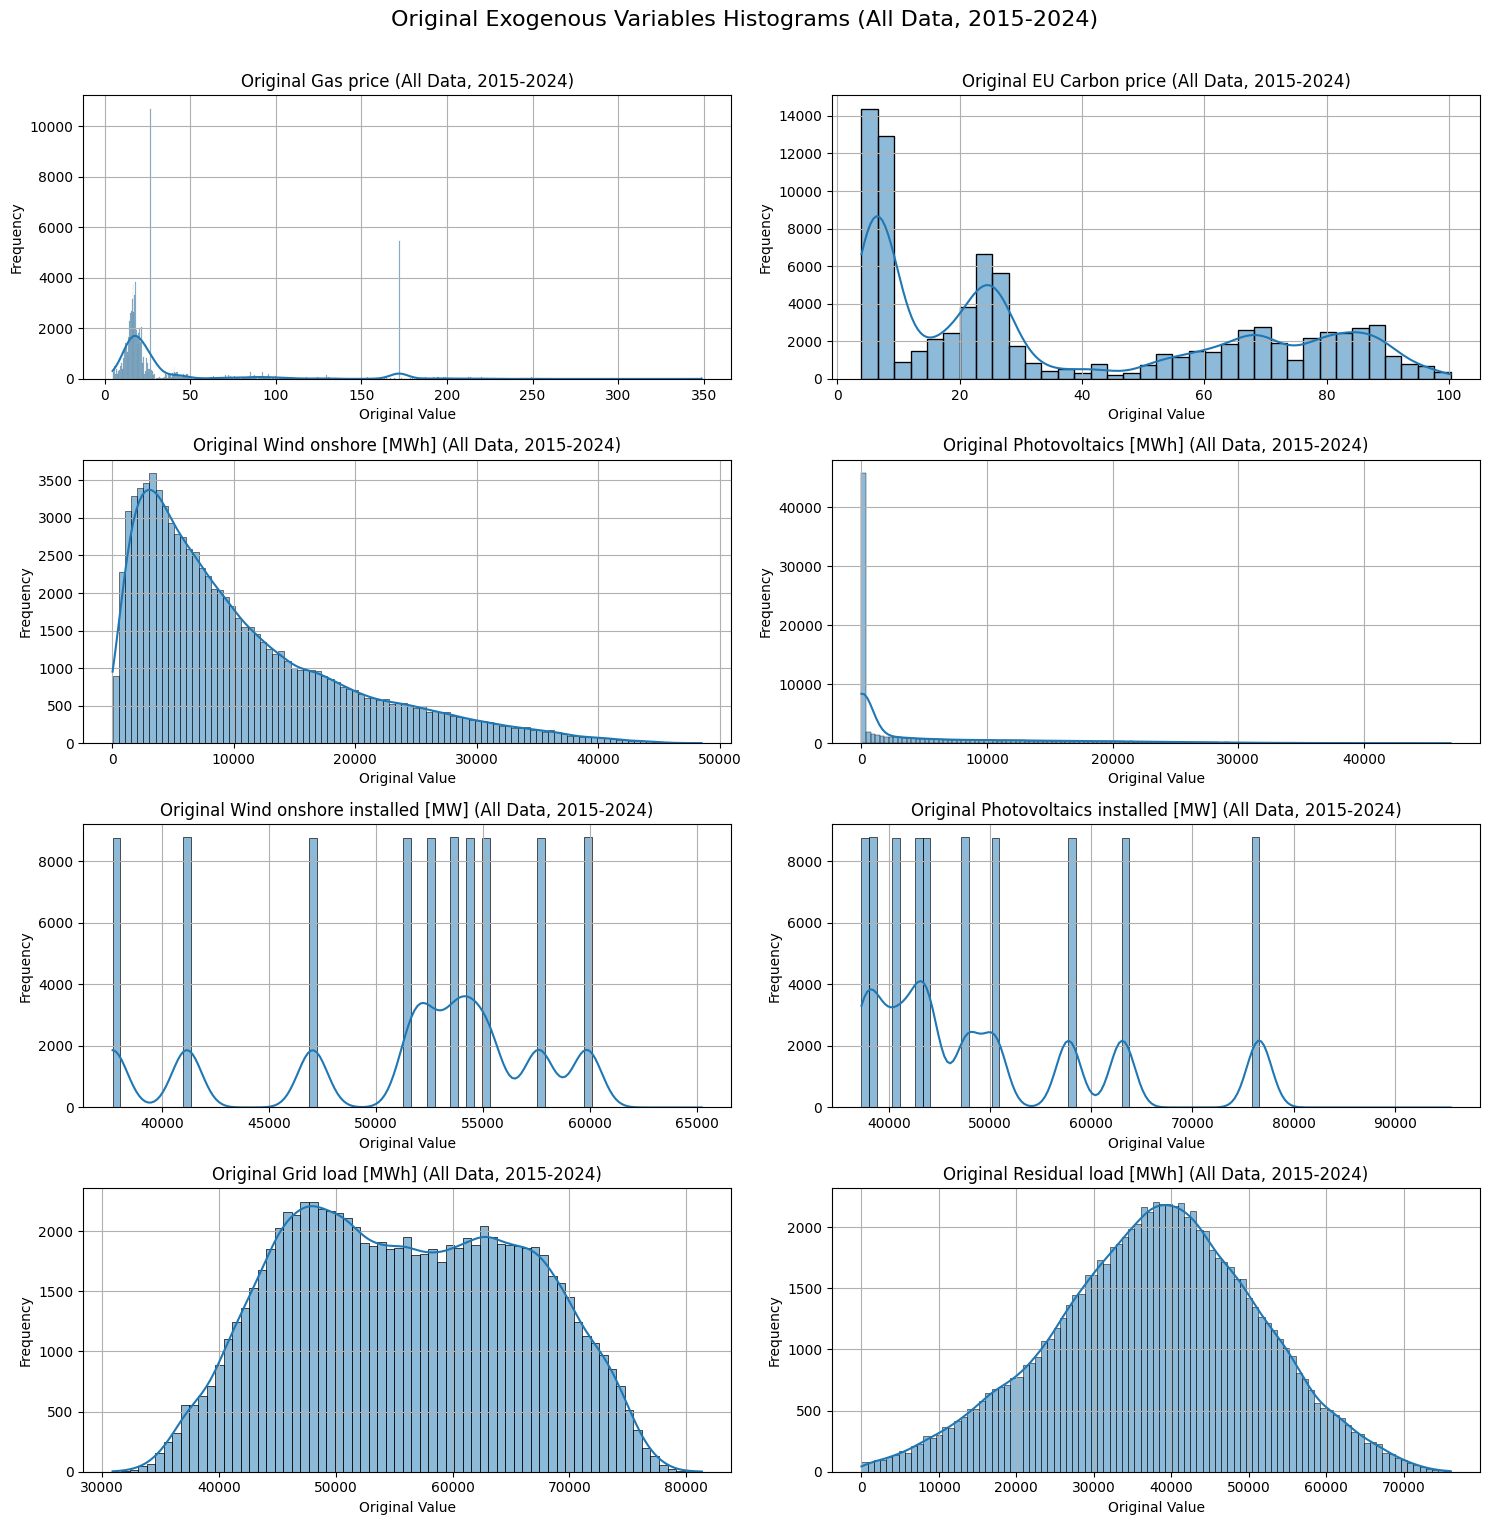


             PHASE 1: SEASONAL EDA AND ORDER IDENTIFICATION
             (You will visually inspect plots and input ARIMA orders)

             ANALYZING SEASON 1: WINTER (Months: [12, 1, 2])

Seasonal period (m) for this analysis is fixed at 24 hours (daily seasonality).
Data points for Winter (Target): 8664
Data points for Winter (Original Exogenous, filtered 2021-2024): 8664

--- Exogenous Variables Distribution during Negative Spot Prices in Winter (Histograms of ORIGINAL Values, 2015-2024) ---
Found 580 instances of negative spot prices in Winter (2015-2024).

Descriptive Statistics for ORIGINAL Exogenous Variables during Negative Prices:
        Gas price  EU Carbon price  Wind onshore [MWh]  Photovoltaics [MWh]  \
count  580.000000       580.000000          580.000000           580.000000   
mean    31.031086        33.740690        30766.910345           971.948276   
std     41.063250        28.896152         5095.194271          2881.627717   
min      8.940000         4.970

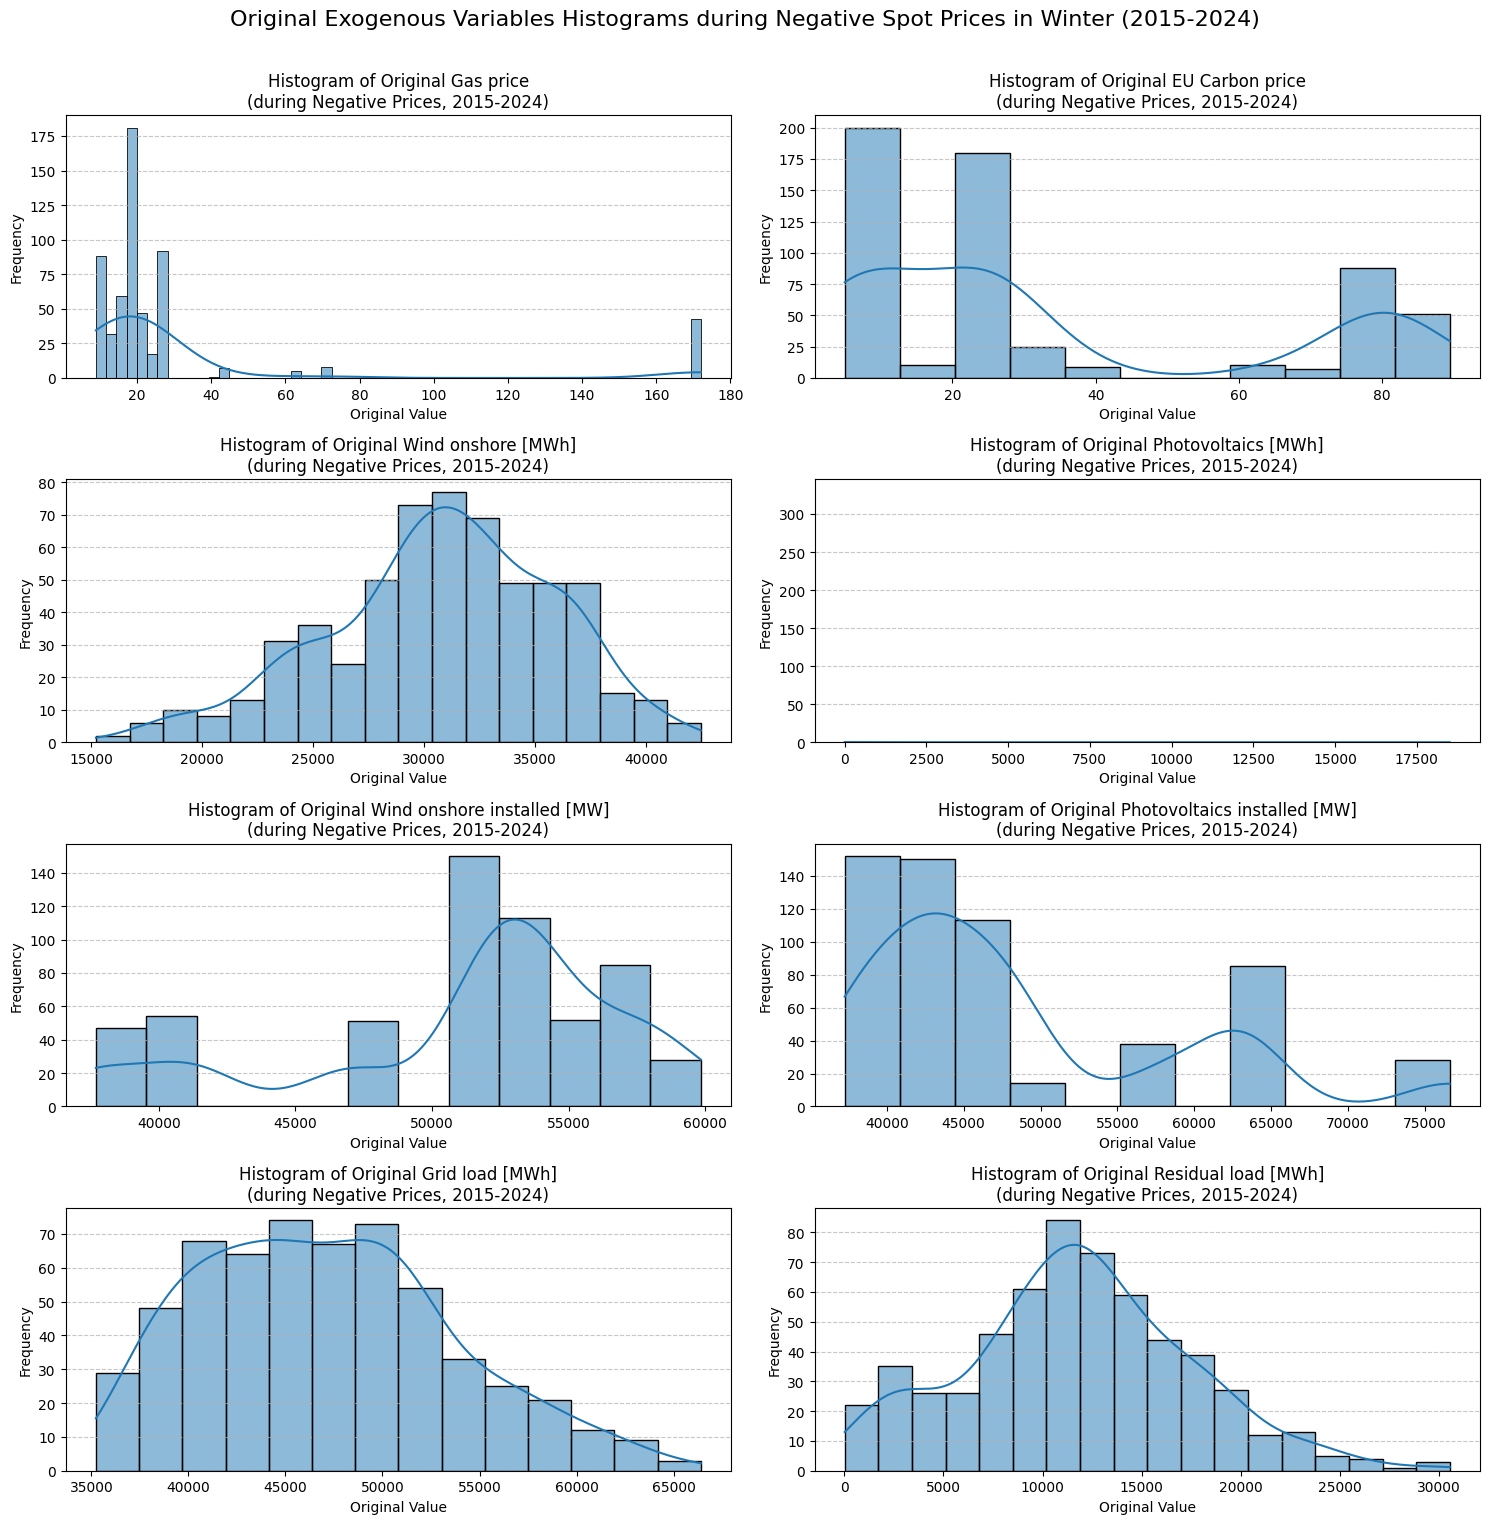


--- NON-SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---

--- Current Series for Non-Seasonal Differencing (d_total=0) ---

--- Stationarity Tests (Non-seasonal): ---
  ADF Test: Statistic=-4.6376, p-value=0.0001
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=1.5333, p-value=0.0100
  Result: Appears Non-Stationary (KPSS p-value < 0.05). (Reject H0: Stationarity)


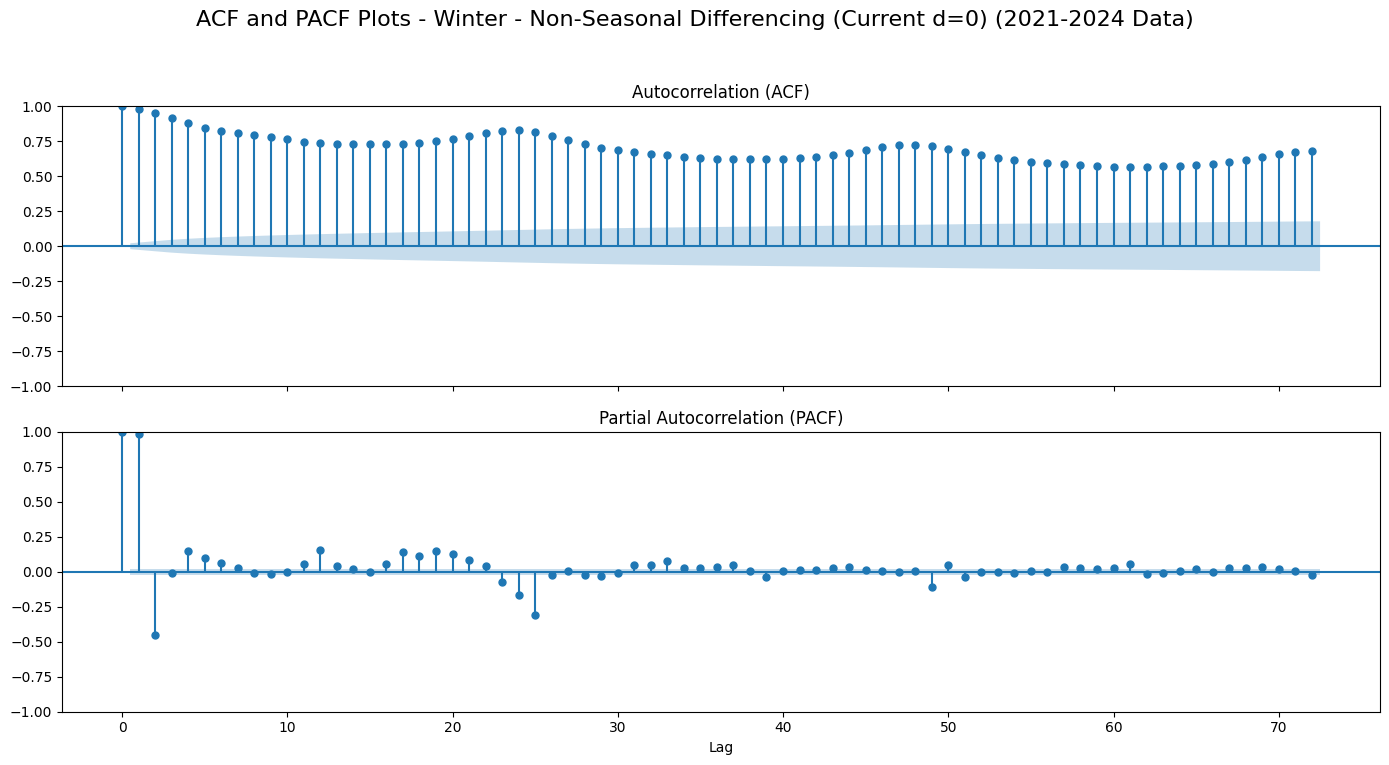

Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: yes
Non-seasonal differencing applied. New total d: 1

--- Current Series for Non-Seasonal Differencing (d_total=1) ---

--- Stationarity Tests (Non-seasonal): ---
  ADF Test: Statistic=-18.8440, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0203, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


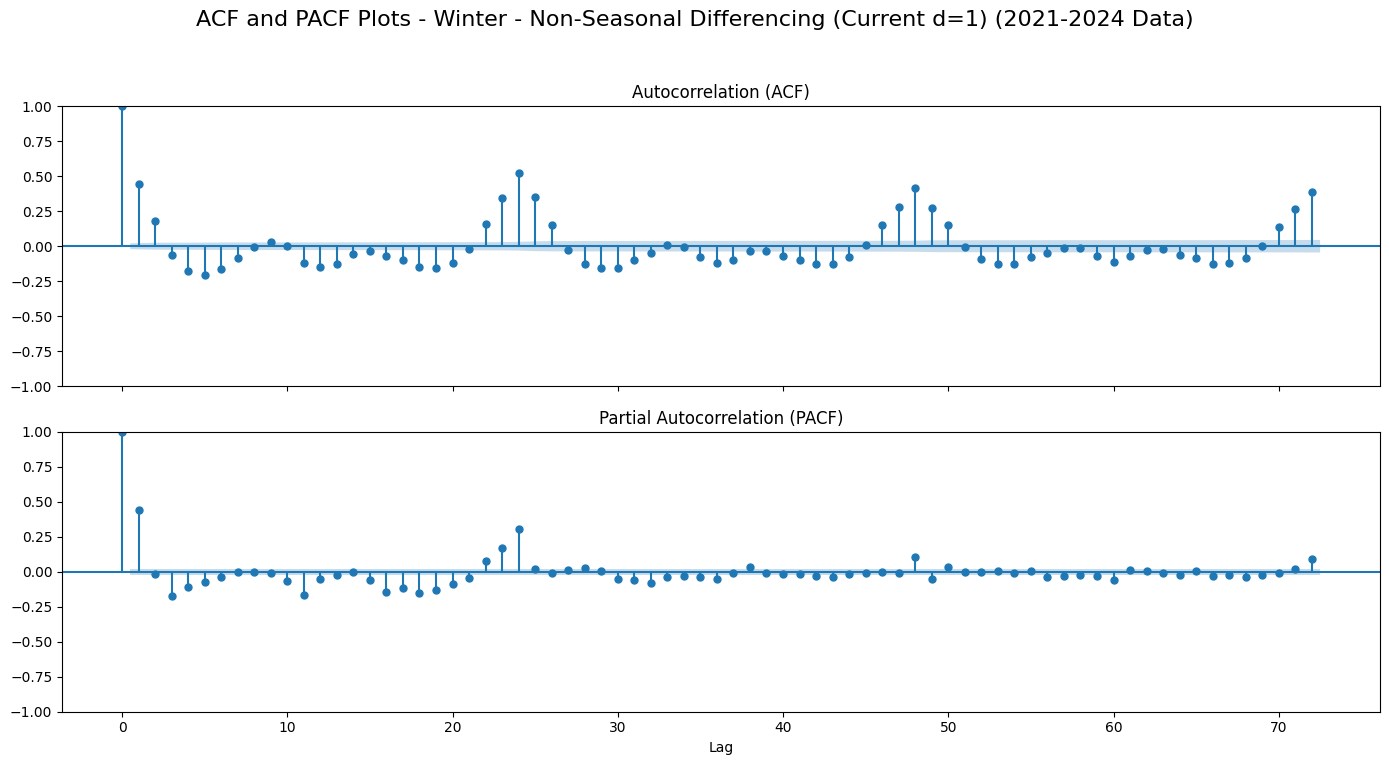

Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: no

--- SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---

--- Current Series for Seasonal Differencing (D_total=0, m=24) ---

--- Stationarity Tests (Seasonal): ---
  ADF Test: Statistic=-18.8440, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0203, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


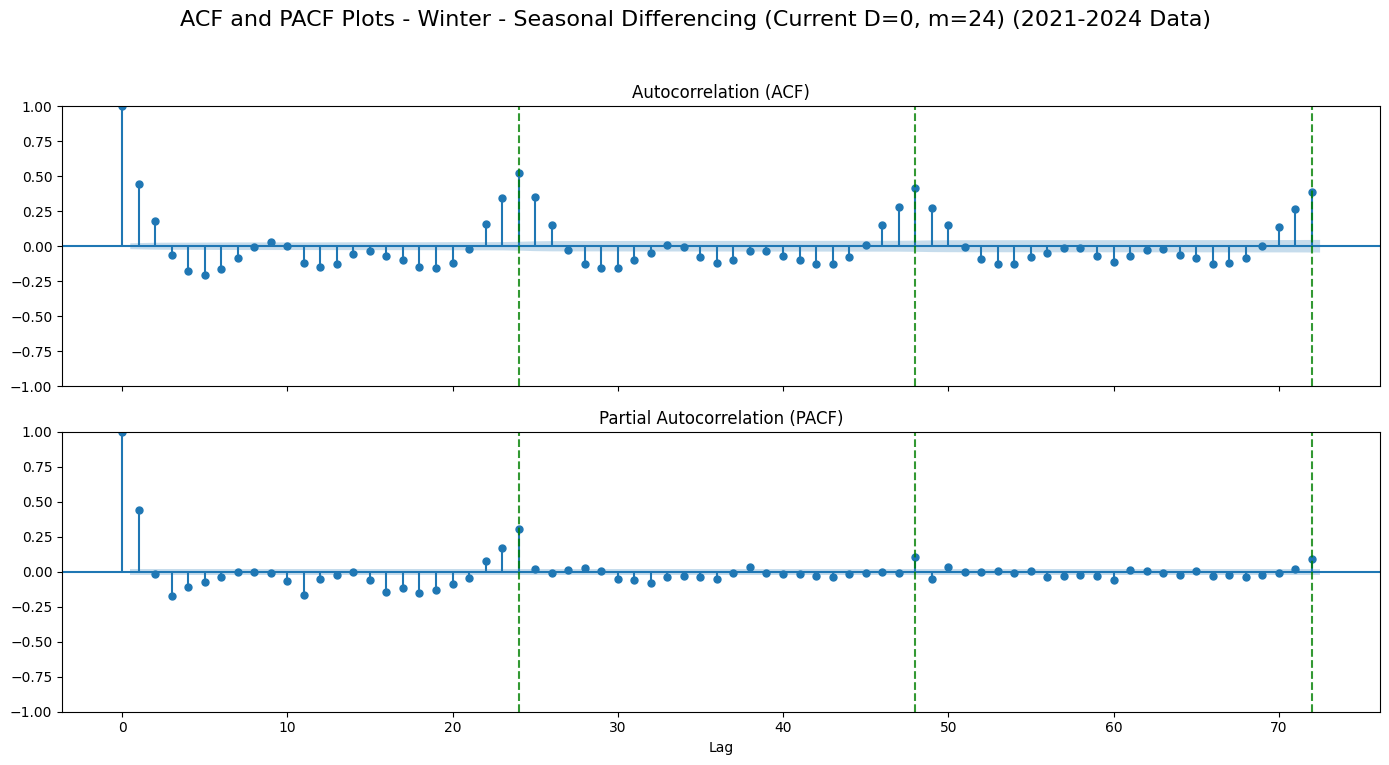

Do you want to apply seasonal differencing (D) for m=24? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: yes 
Seasonal differencing applied. New total D: 1

--- Current Series for Seasonal Differencing (D_total=1, m=24) ---

--- Stationarity Tests (Seasonal): ---
  ADF Test: Statistic=-20.6082, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0022, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


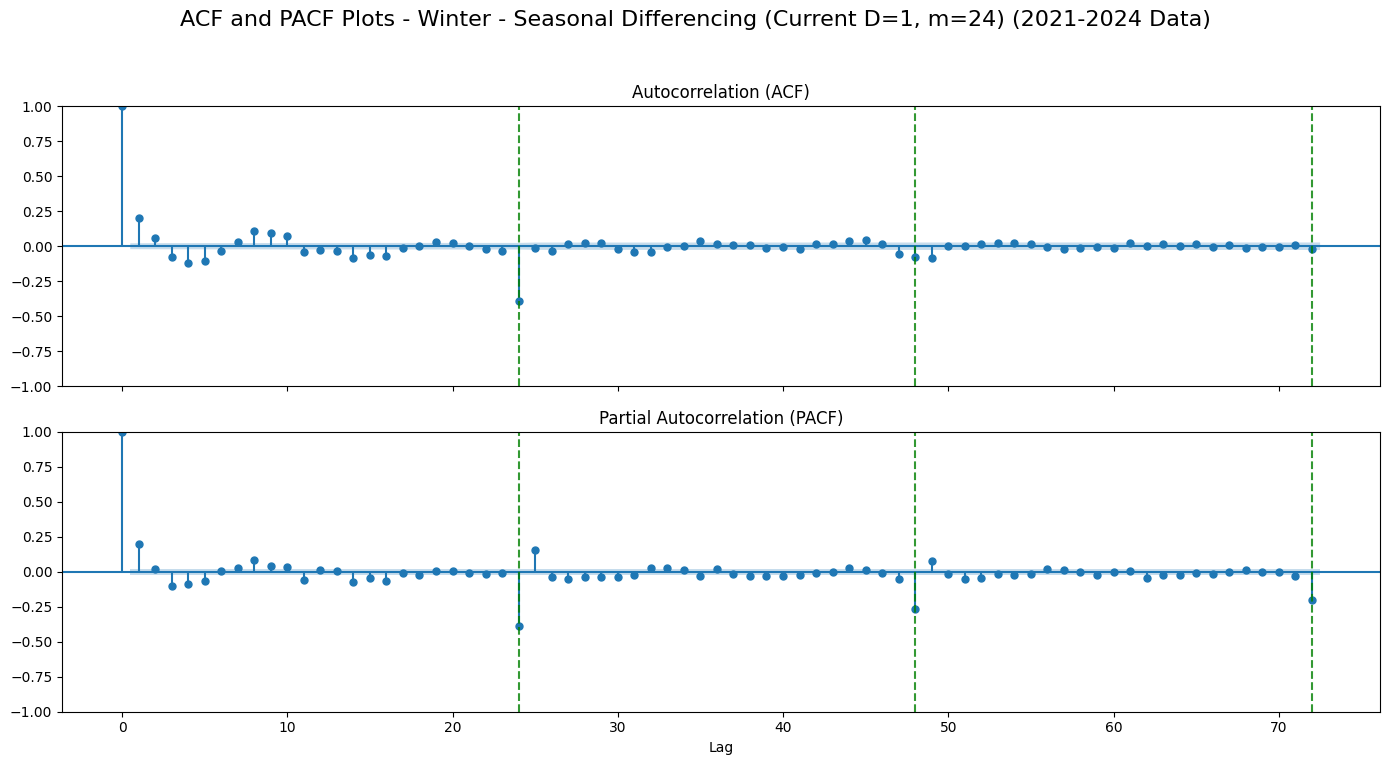

Do you want to apply seasonal differencing (D) for m=24? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: no

--- USER INPUT: Non-Seasonal ARIMA (p,d,q) ---
Based on the final differenced series (d_total=1, D_total=1, m=24),
please select p and q values for the non-seasonal part.
Enter NON-SEASONAL (p,d,q) for Season 1 (e.g., 1,1,1): 3,1,2

--- USER INPUT: Seasonal SARIMA (P,D,Q) ---
Based on the final differenced series (d_total=1, D_total=1, m=24),
please select P and Q values for the seasonal part.
Enter SEASONAL (P,D,Q) for Season 1 (e.g., 1,1,1): 1,0,1

             ORDER IDENTIFICATION COMPLETE FOR THIS SEASON.
             Moving to the next season (or final model fitting).

             ANALYZING SEASON 2: SPRING (Months: [3, 4, 5])

Seasonal period (m) for this analysis is fixed at 24 hours (daily seasonality).
Data points for Spring (Target): 8832
Data points for Spring (Original Exogenous, filtered 2021-2024): 8832

--- 

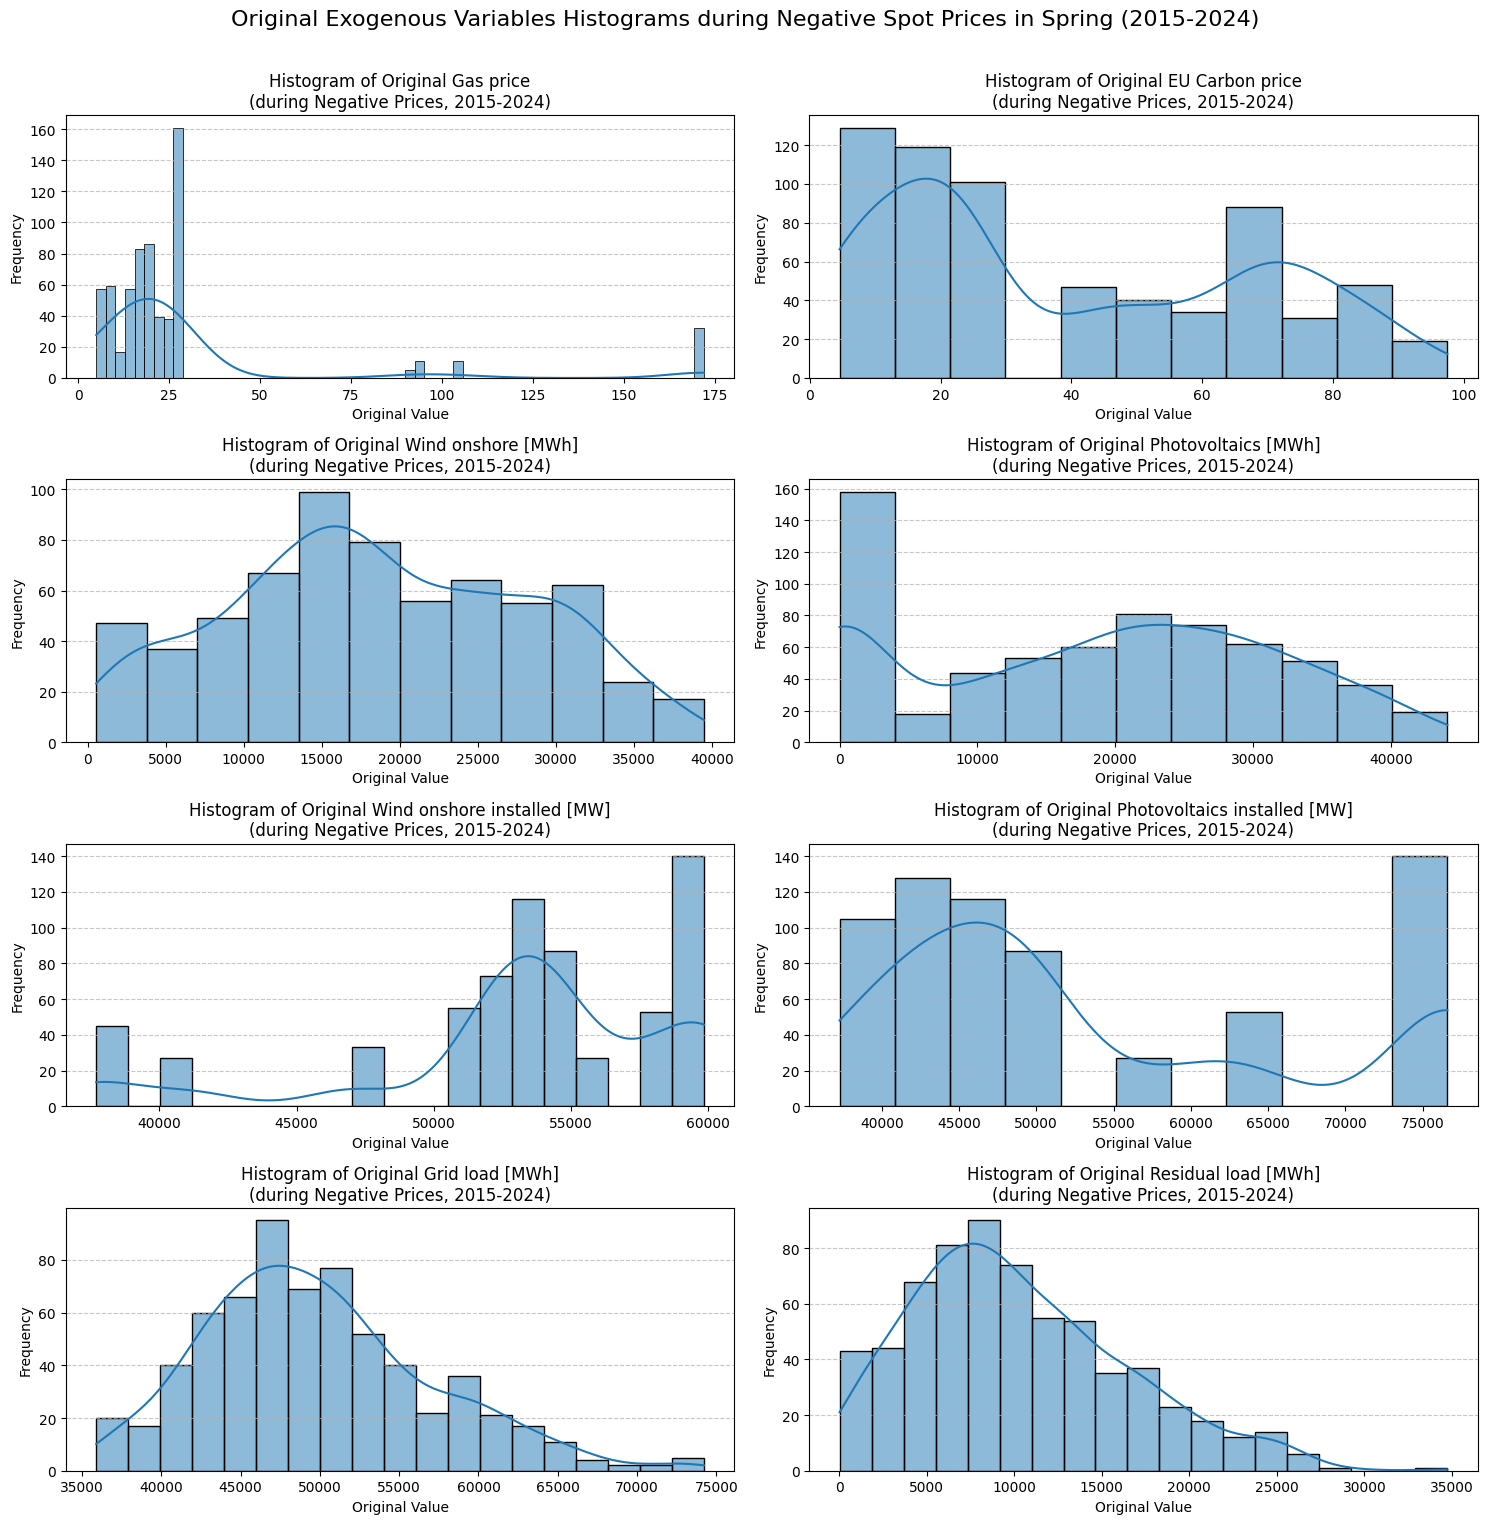


--- NON-SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---

--- Current Series for Non-Seasonal Differencing (d_total=0) ---

--- Stationarity Tests (Non-seasonal): ---
  ADF Test: Statistic=-5.5766, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=2.0701, p-value=0.0100
  Result: Appears Non-Stationary (KPSS p-value < 0.05). (Reject H0: Stationarity)


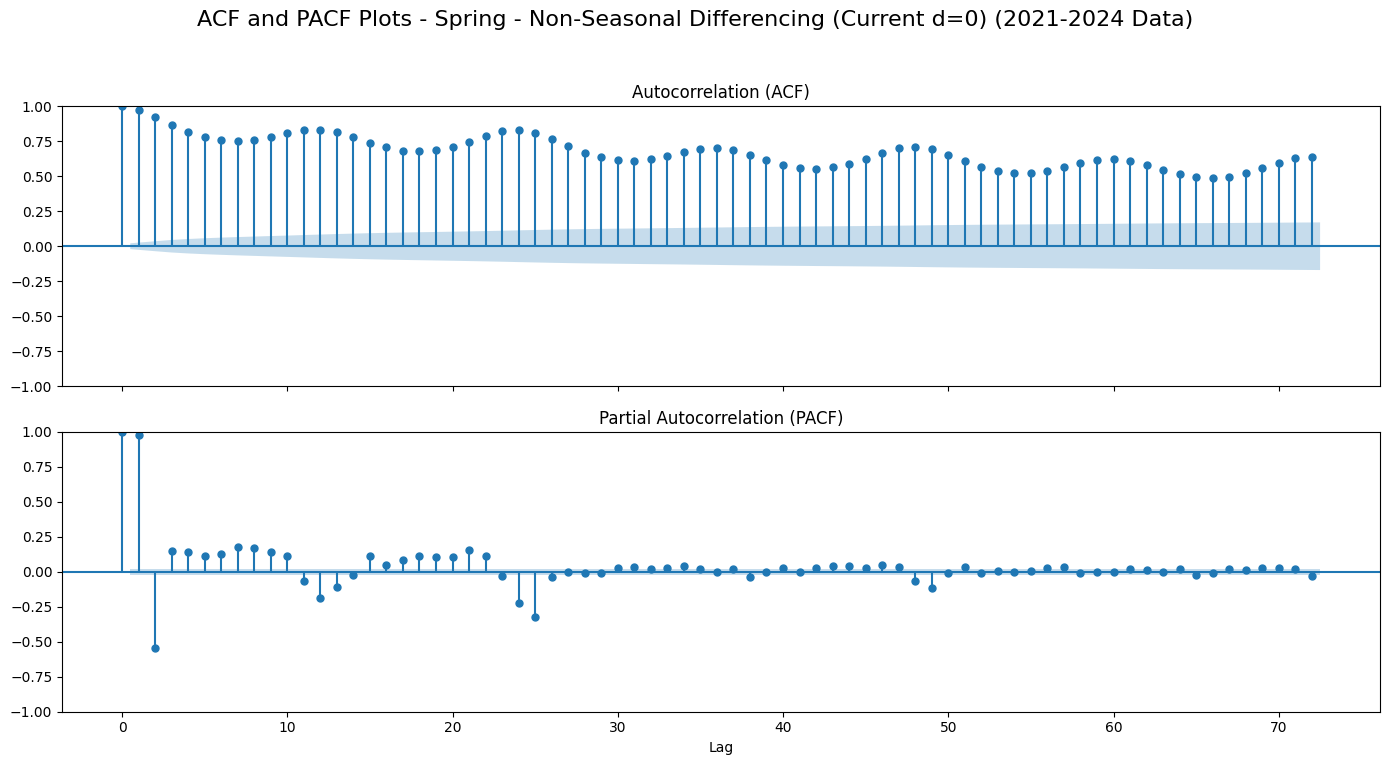

Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: yes
Non-seasonal differencing applied. New total d: 1

--- Current Series for Non-Seasonal Differencing (d_total=1) ---

--- Stationarity Tests (Non-seasonal): ---
  ADF Test: Statistic=-17.2438, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0308, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


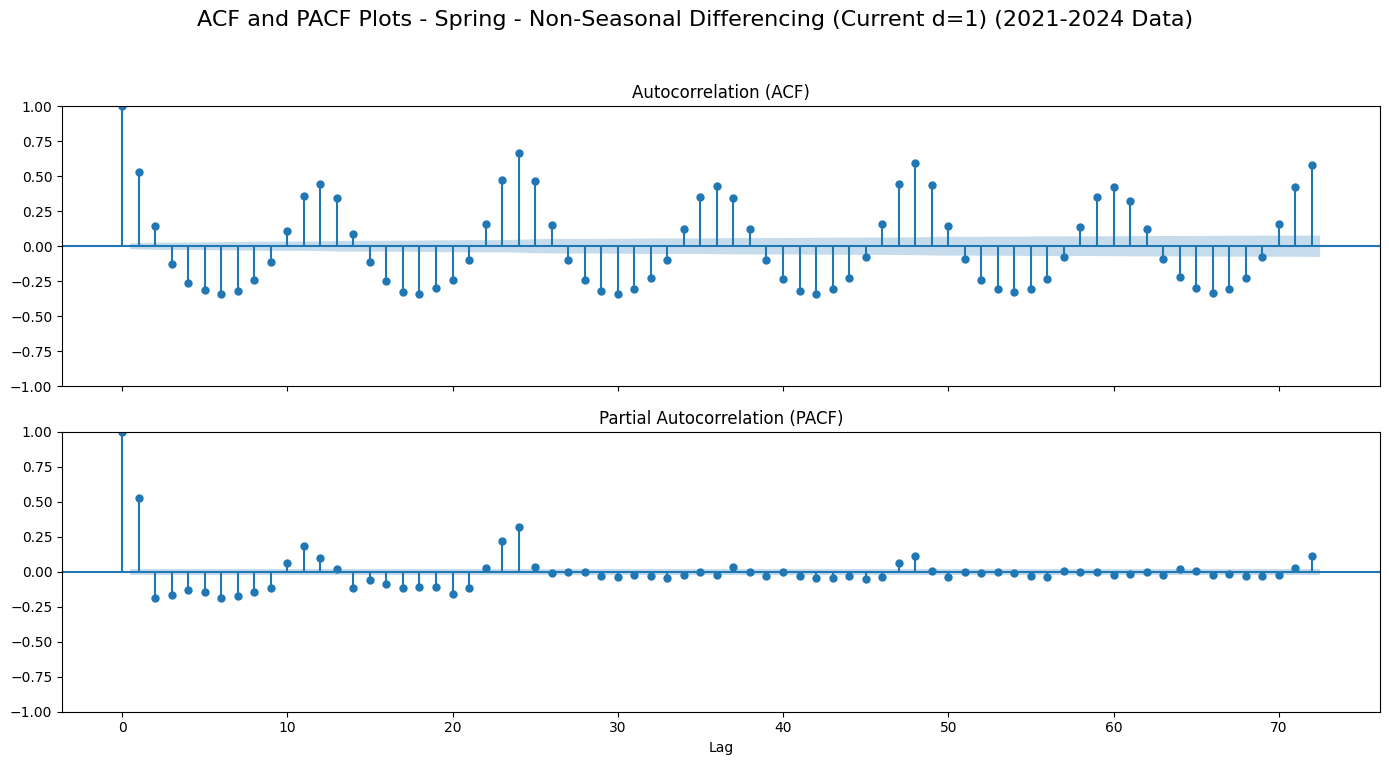

Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: no

--- SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---

--- Current Series for Seasonal Differencing (D_total=0, m=24) ---

--- Stationarity Tests (Seasonal): ---
  ADF Test: Statistic=-17.2438, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0308, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


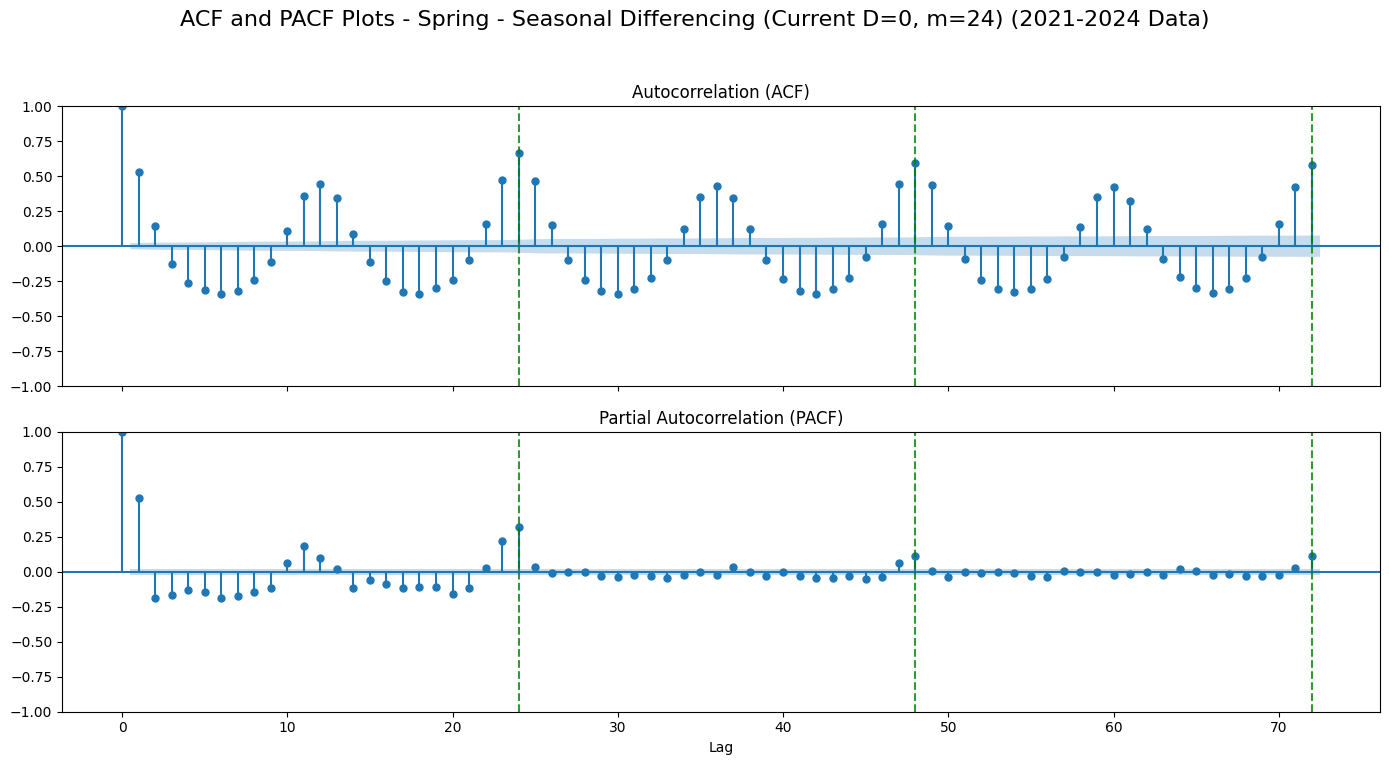

Do you want to apply seasonal differencing (D) for m=24? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: yes
Seasonal differencing applied. New total D: 1

--- Current Series for Seasonal Differencing (D_total=1, m=24) ---

--- Stationarity Tests (Seasonal): ---
  ADF Test: Statistic=-20.5568, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0012, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


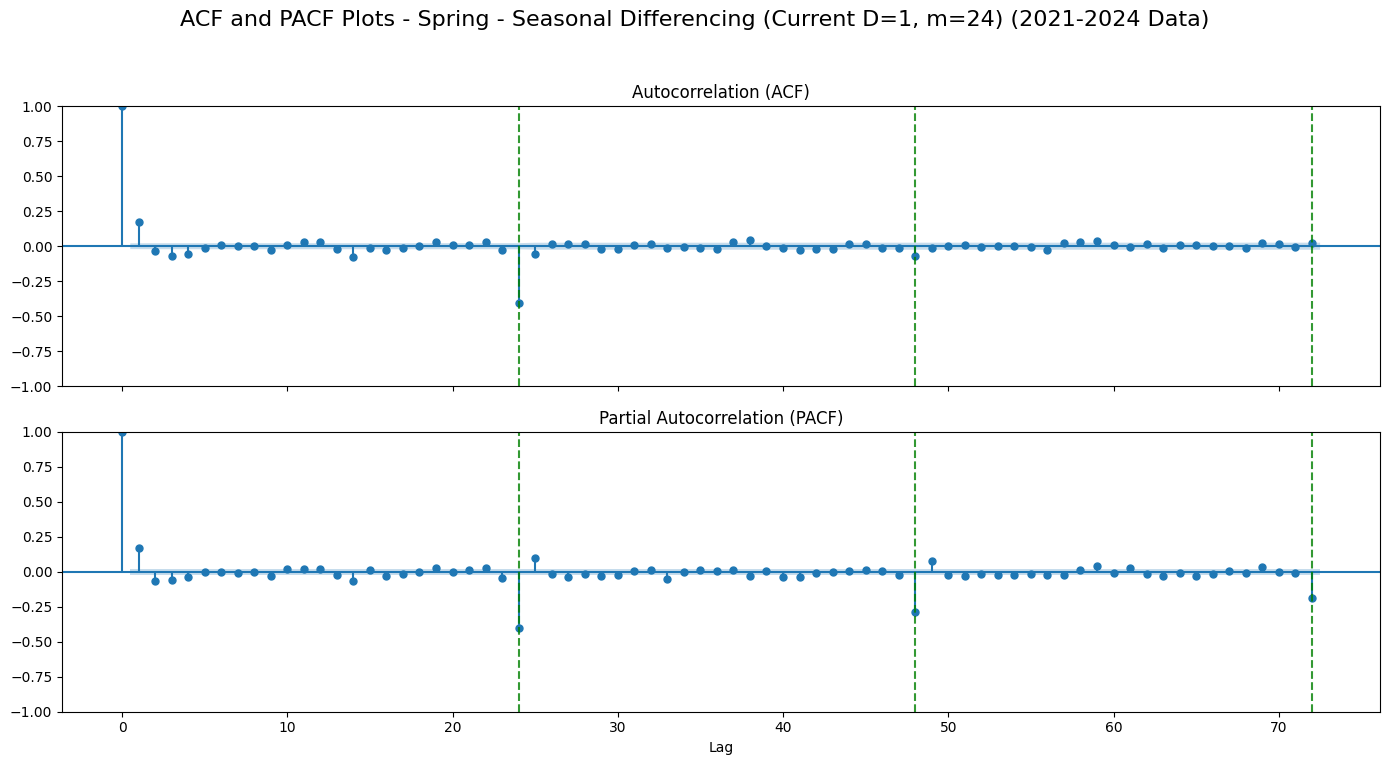

Do you want to apply seasonal differencing (D) for m=24? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: no

--- USER INPUT: Non-Seasonal ARIMA (p,d,q) ---
Based on the final differenced series (d_total=1, D_total=1, m=24),
please select p and q values for the non-seasonal part.
Enter NON-SEASONAL (p,d,q) for Season 2 (e.g., 1,1,1): 3,1,1

--- USER INPUT: Seasonal SARIMA (P,D,Q) ---
Based on the final differenced series (d_total=1, D_total=1, m=24),
please select P and Q values for the seasonal part.
Enter SEASONAL (P,D,Q) for Season 2 (e.g., 1,1,1): 1,0,0

             ORDER IDENTIFICATION COMPLETE FOR THIS SEASON.
             Moving to the next season (or final model fitting).

             ANALYZING SEASON 3: SUMMER (Months: [6, 7, 8])

Seasonal period (m) for this analysis is fixed at 24 hours (daily seasonality).
Data points for Summer (Target): 8832
Data points for Summer (Original Exogenous, filtered 2021-2024): 8832

--- 

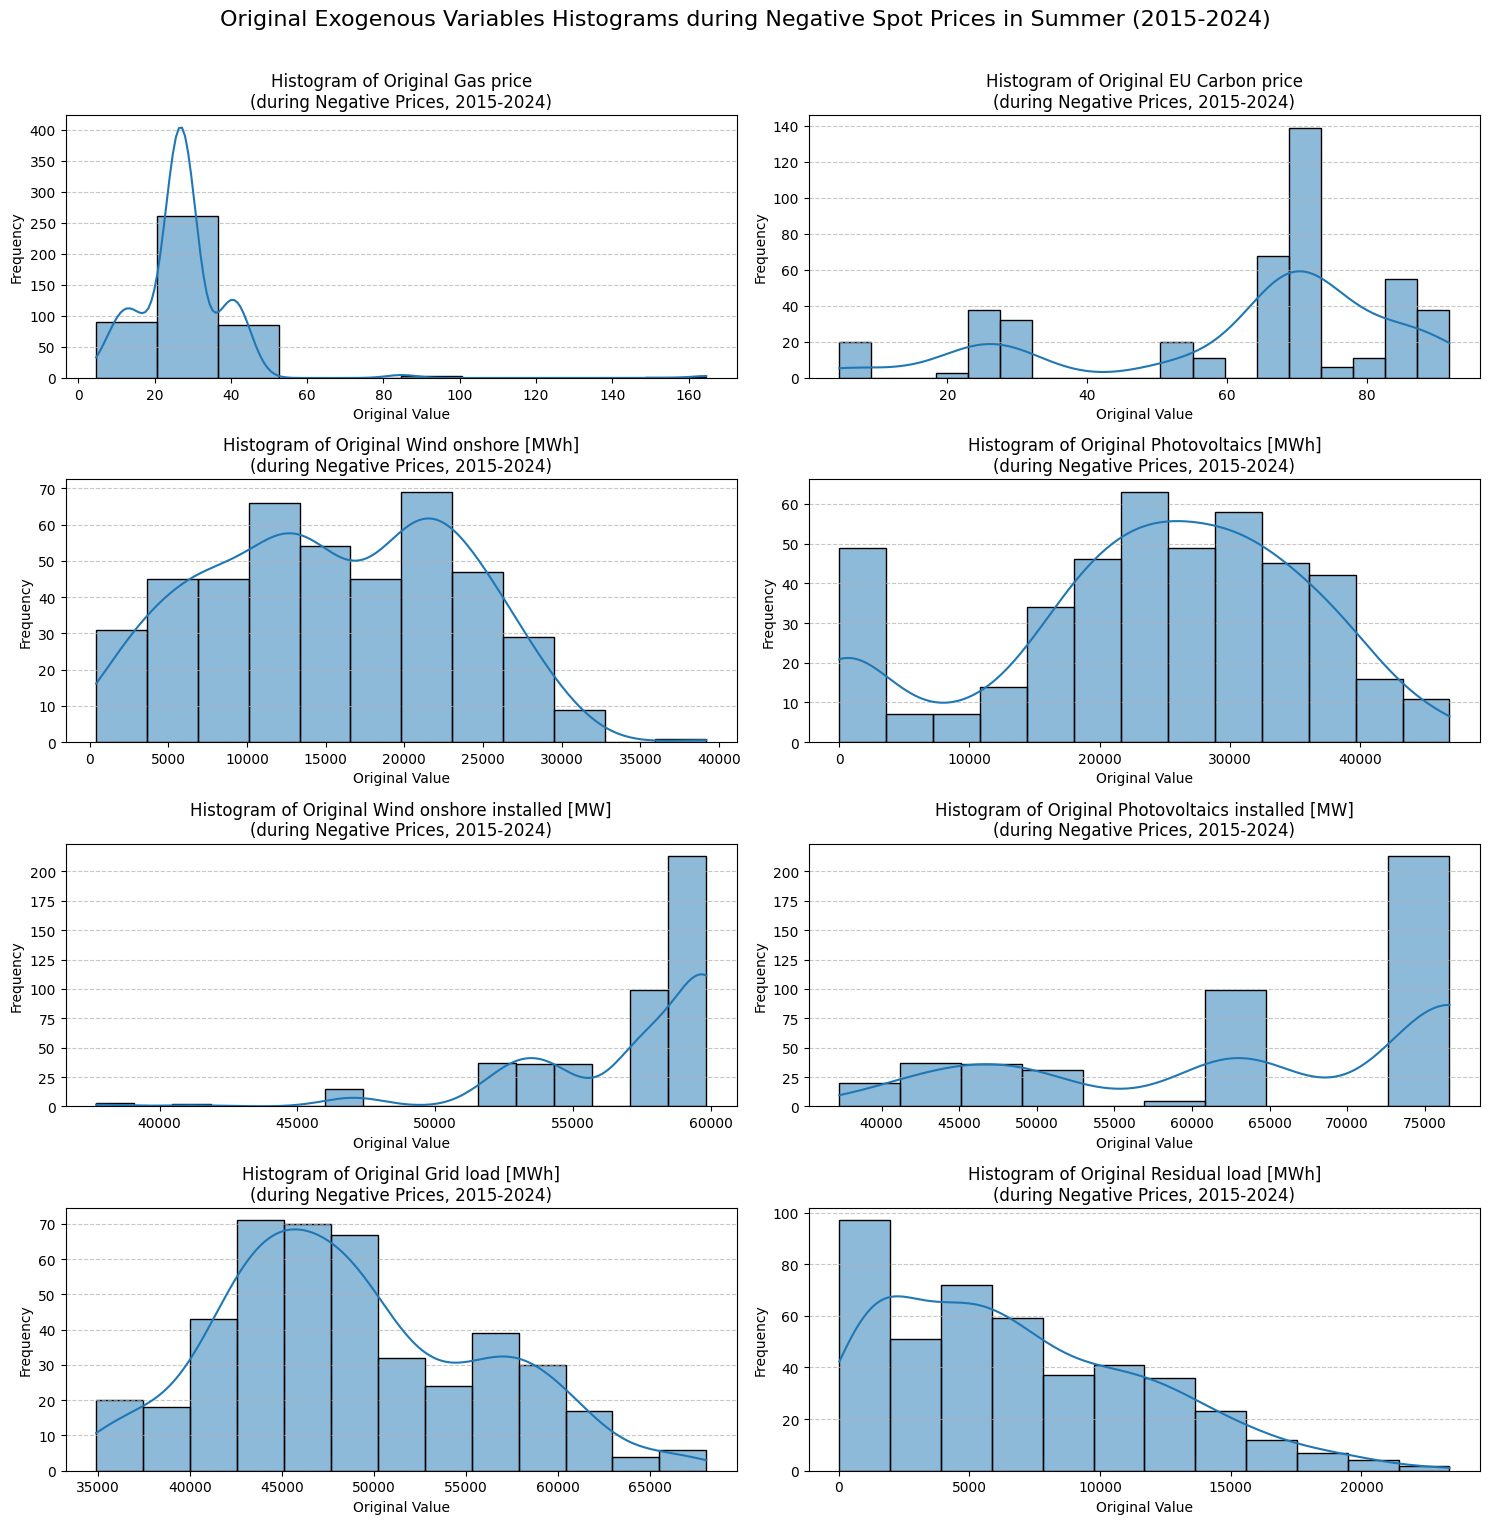


--- NON-SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---

--- Current Series for Non-Seasonal Differencing (d_total=0) ---

--- Stationarity Tests (Non-seasonal): ---
  ADF Test: Statistic=-5.0195, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=2.2447, p-value=0.0100
  Result: Appears Non-Stationary (KPSS p-value < 0.05). (Reject H0: Stationarity)


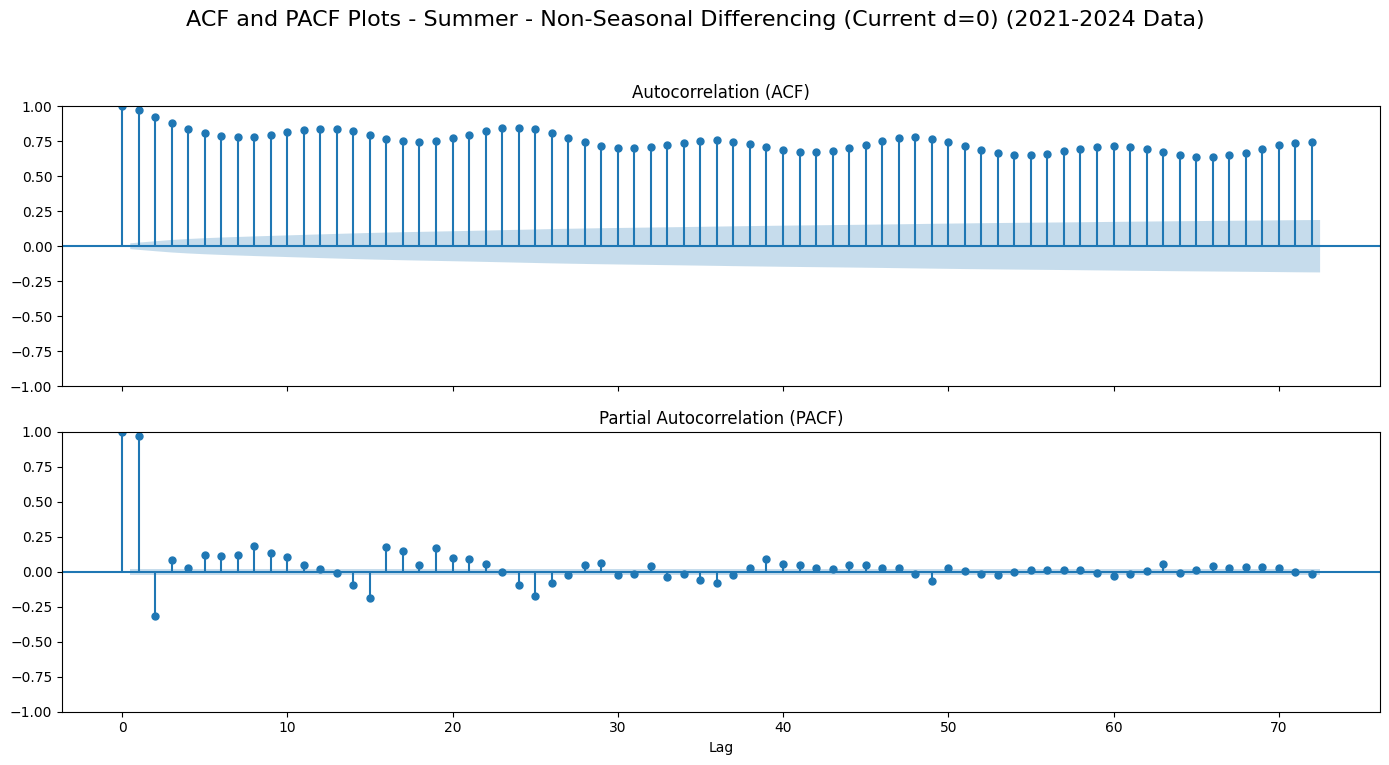

Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: yes
Non-seasonal differencing applied. New total d: 1

--- Current Series for Non-Seasonal Differencing (d_total=1) ---

--- Stationarity Tests (Non-seasonal): ---
  ADF Test: Statistic=-17.0536, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0514, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


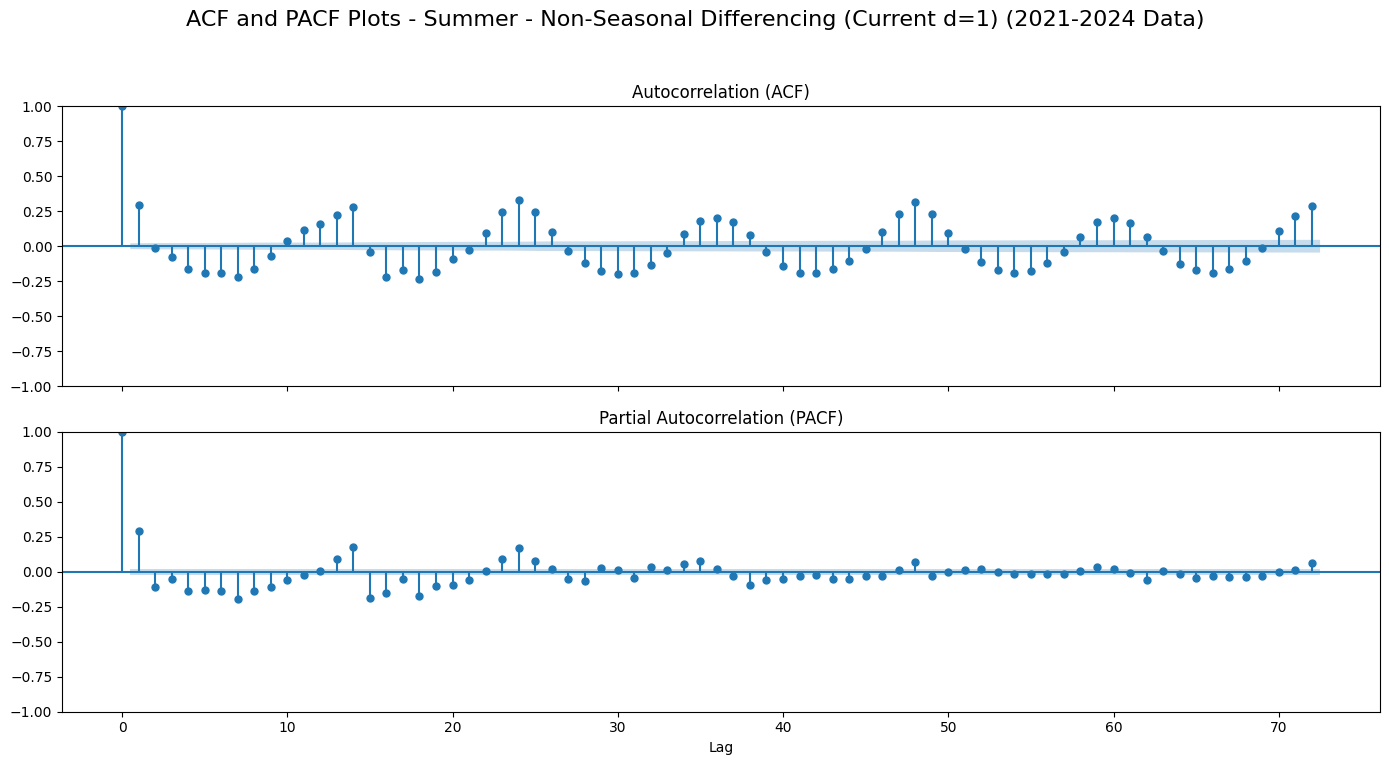

Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: no

--- SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---

--- Current Series for Seasonal Differencing (D_total=0, m=24) ---

--- Stationarity Tests (Seasonal): ---
  ADF Test: Statistic=-17.0536, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0514, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


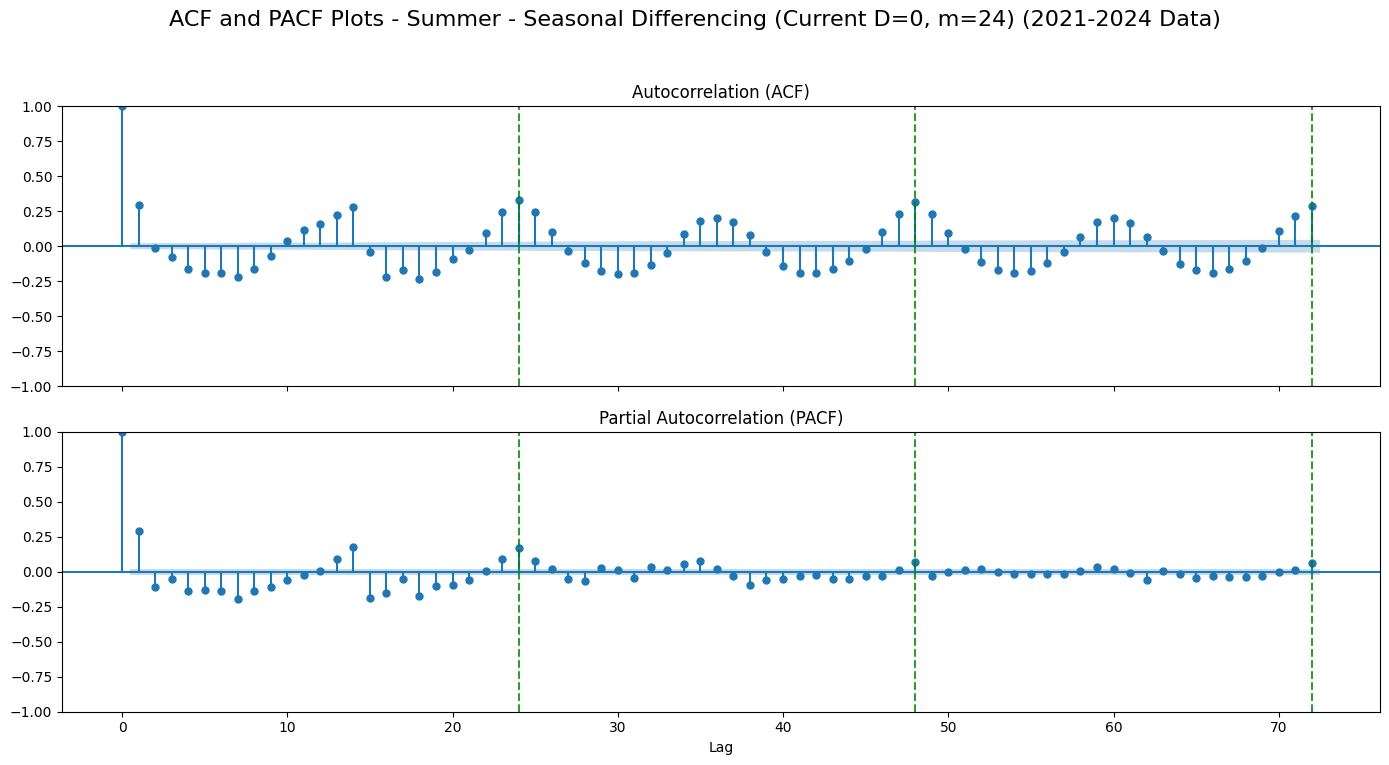

Do you want to apply seasonal differencing (D) for m=24? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: yes
Seasonal differencing applied. New total D: 1

--- Current Series for Seasonal Differencing (D_total=1, m=24) ---

--- Stationarity Tests (Seasonal): ---
  ADF Test: Statistic=-21.9842, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0046, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


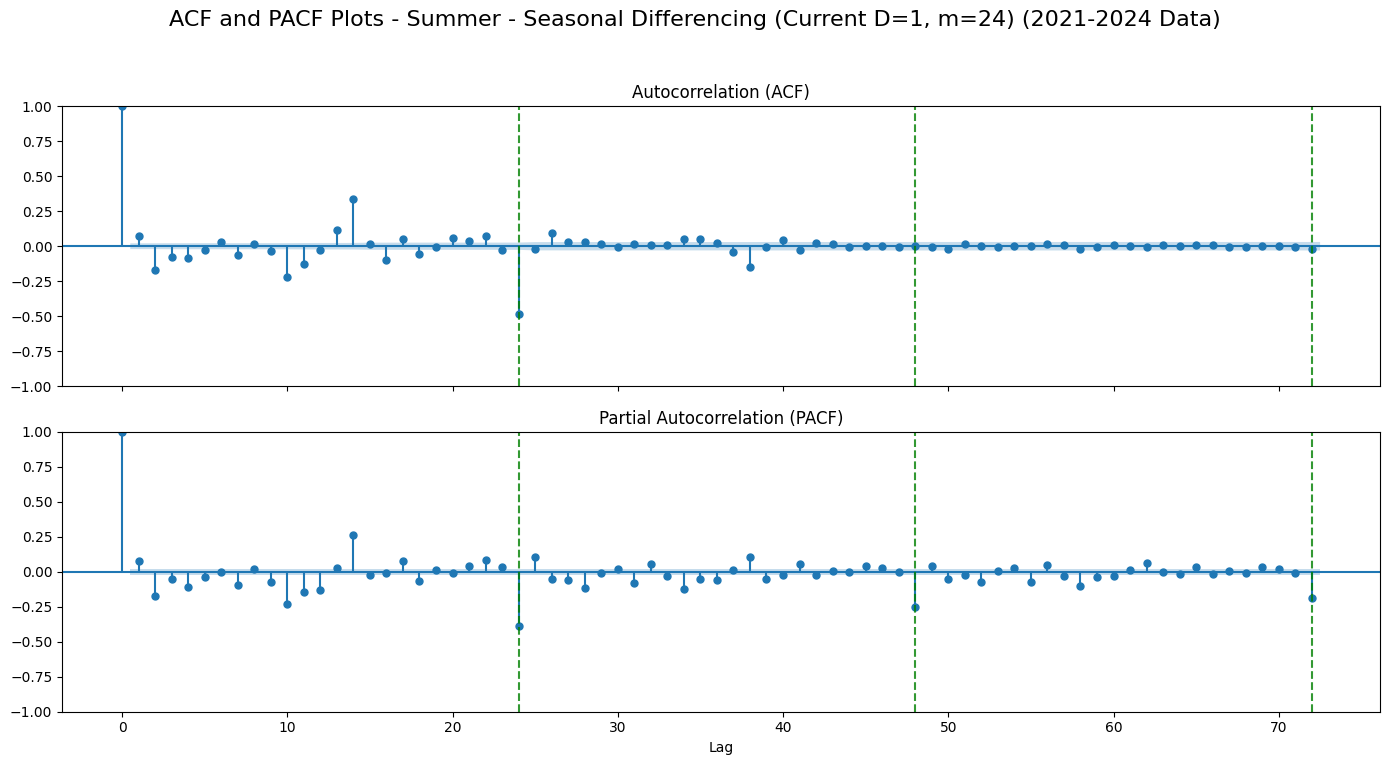

Do you want to apply seasonal differencing (D) for m=24? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: no

--- USER INPUT: Non-Seasonal ARIMA (p,d,q) ---
Based on the final differenced series (d_total=1, D_total=1, m=24),
please select p and q values for the non-seasonal part.
Enter NON-SEASONAL (p,d,q) for Season 3 (e.g., 1,1,1): 3,1,3

--- USER INPUT: Seasonal SARIMA (P,D,Q) ---
Based on the final differenced series (d_total=1, D_total=1, m=24),
please select P and Q values for the seasonal part.
Enter SEASONAL (P,D,Q) for Season 3 (e.g., 1,1,1): 0,0,1

             ORDER IDENTIFICATION COMPLETE FOR THIS SEASON.
             Moving to the next season (or final model fitting).

             ANALYZING SEASON 4: AUTUMN (Months: [9, 10, 11])

Seasonal period (m) for this analysis is fixed at 24 hours (daily seasonality).
Data points for Autumn (Target): 8735
Data points for Autumn (Original Exogenous, filtered 2021-2024): 8735

--

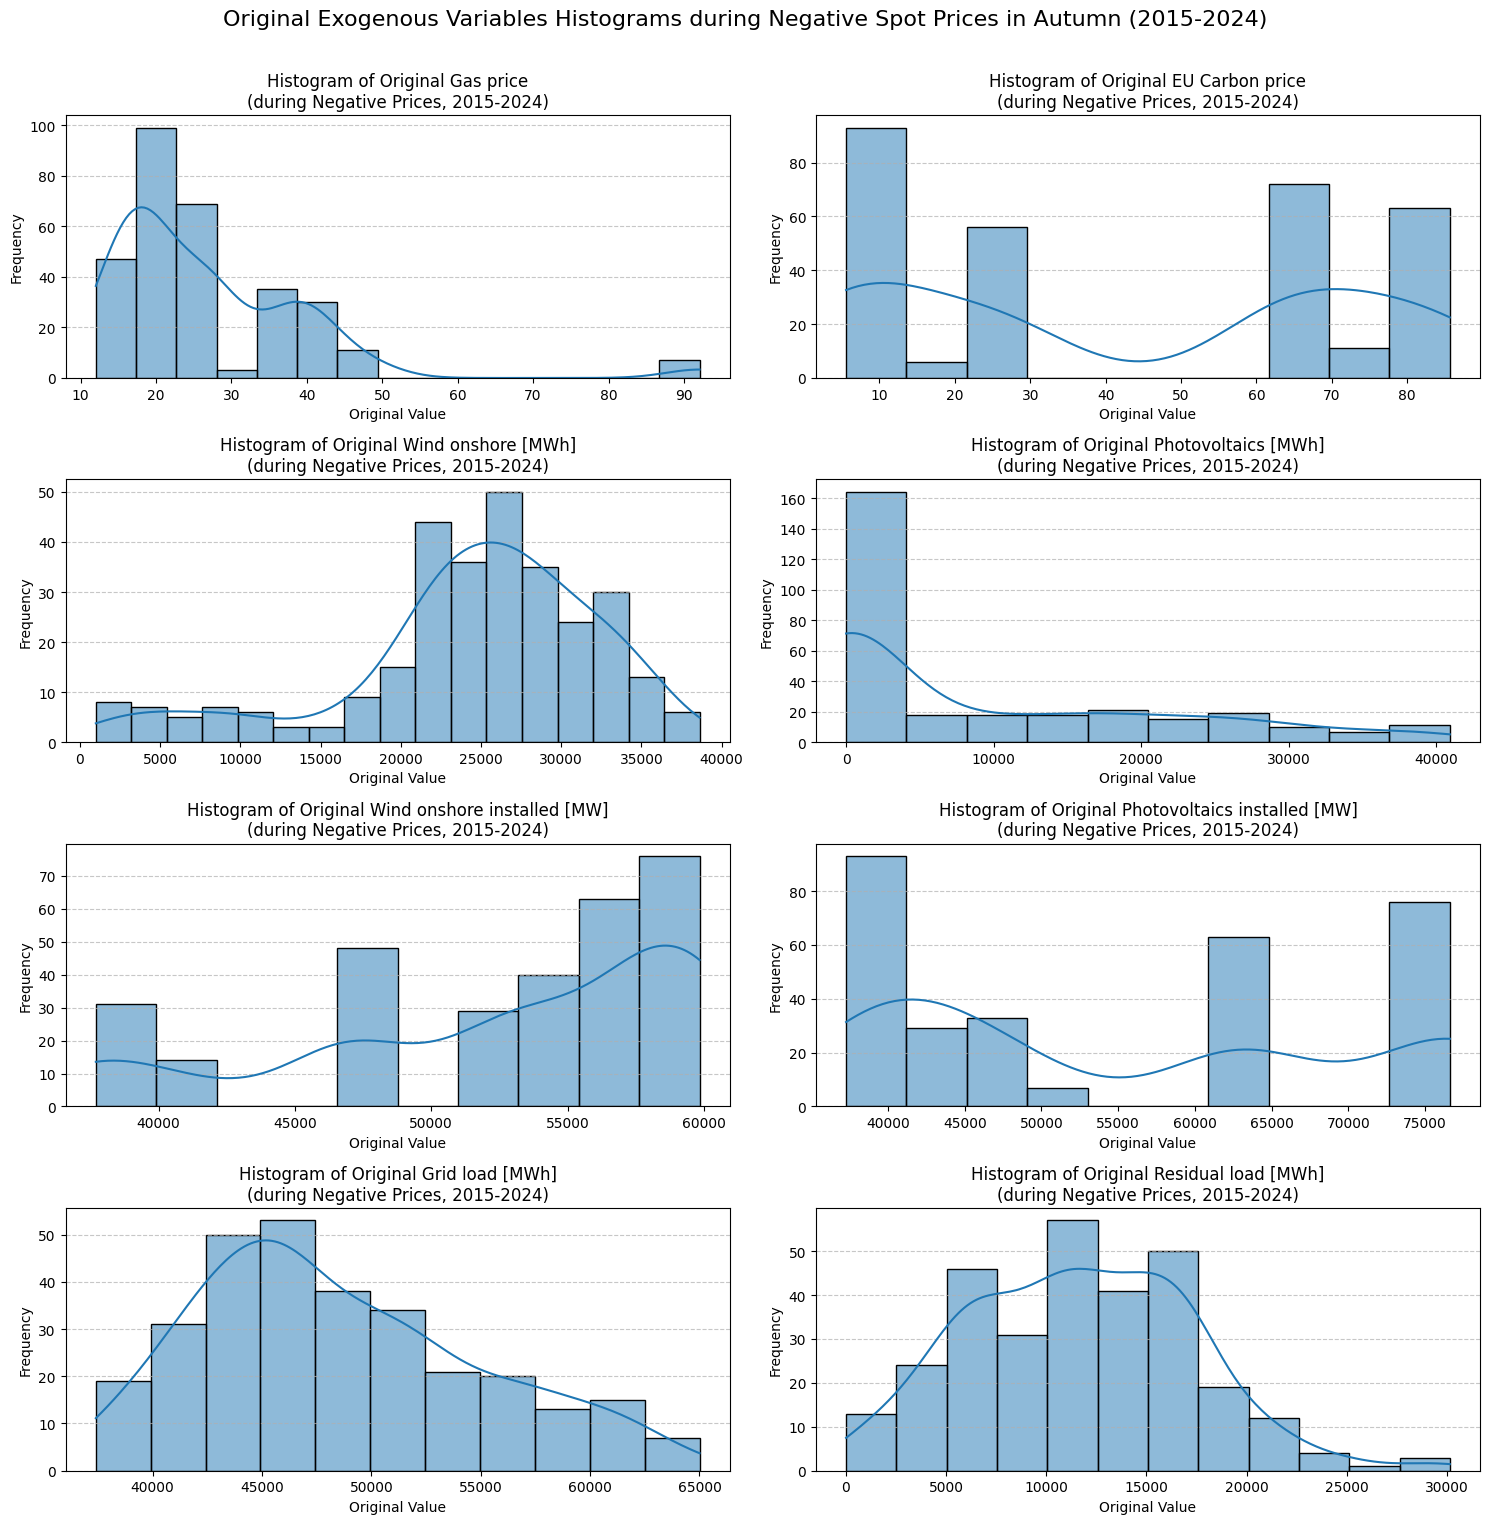


--- NON-SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---

--- Current Series for Non-Seasonal Differencing (d_total=0) ---

--- Stationarity Tests (Non-seasonal): ---
  ADF Test: Statistic=-6.2983, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=4.1183, p-value=0.0100
  Result: Appears Non-Stationary (KPSS p-value < 0.05). (Reject H0: Stationarity)


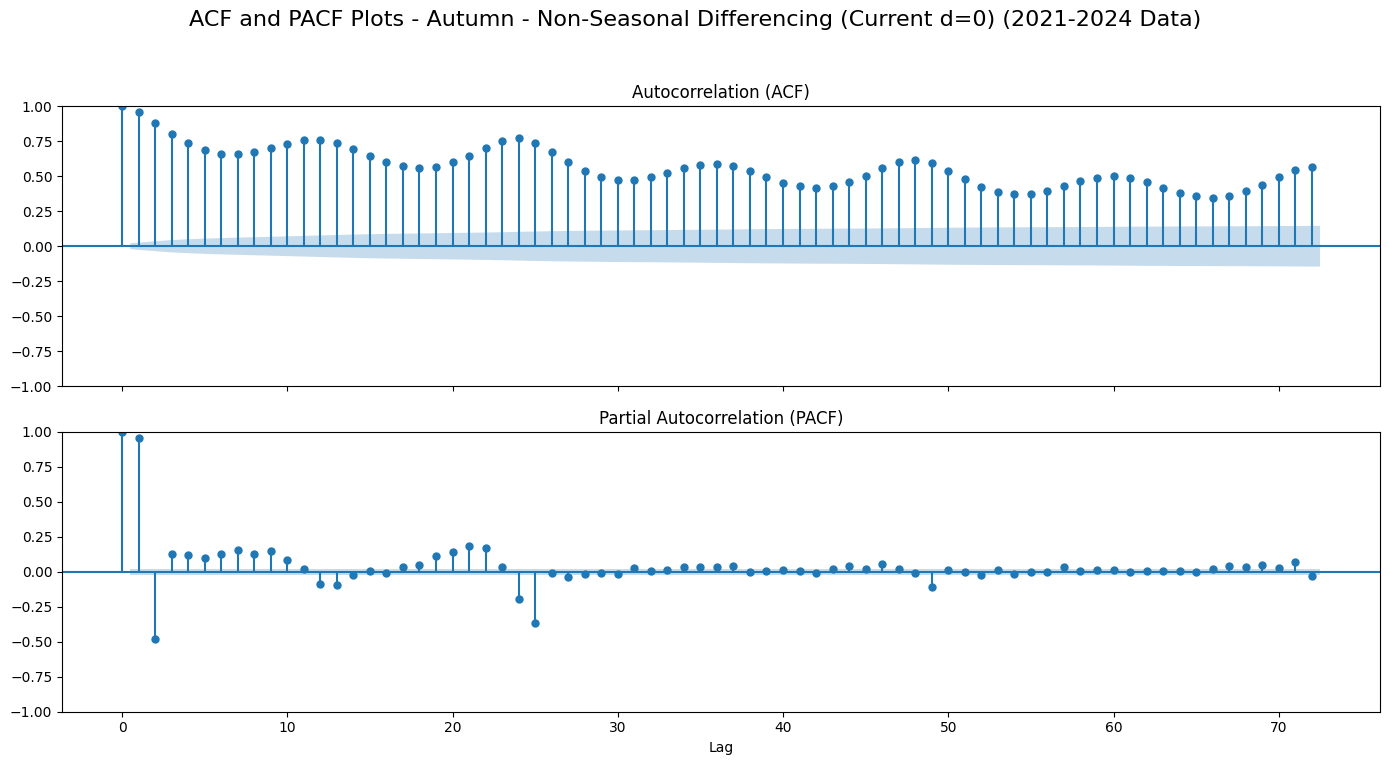

Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: yes
Non-seasonal differencing applied. New total d: 1

--- Current Series for Non-Seasonal Differencing (d_total=1) ---

--- Stationarity Tests (Non-seasonal): ---
  ADF Test: Statistic=-18.8810, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0270, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


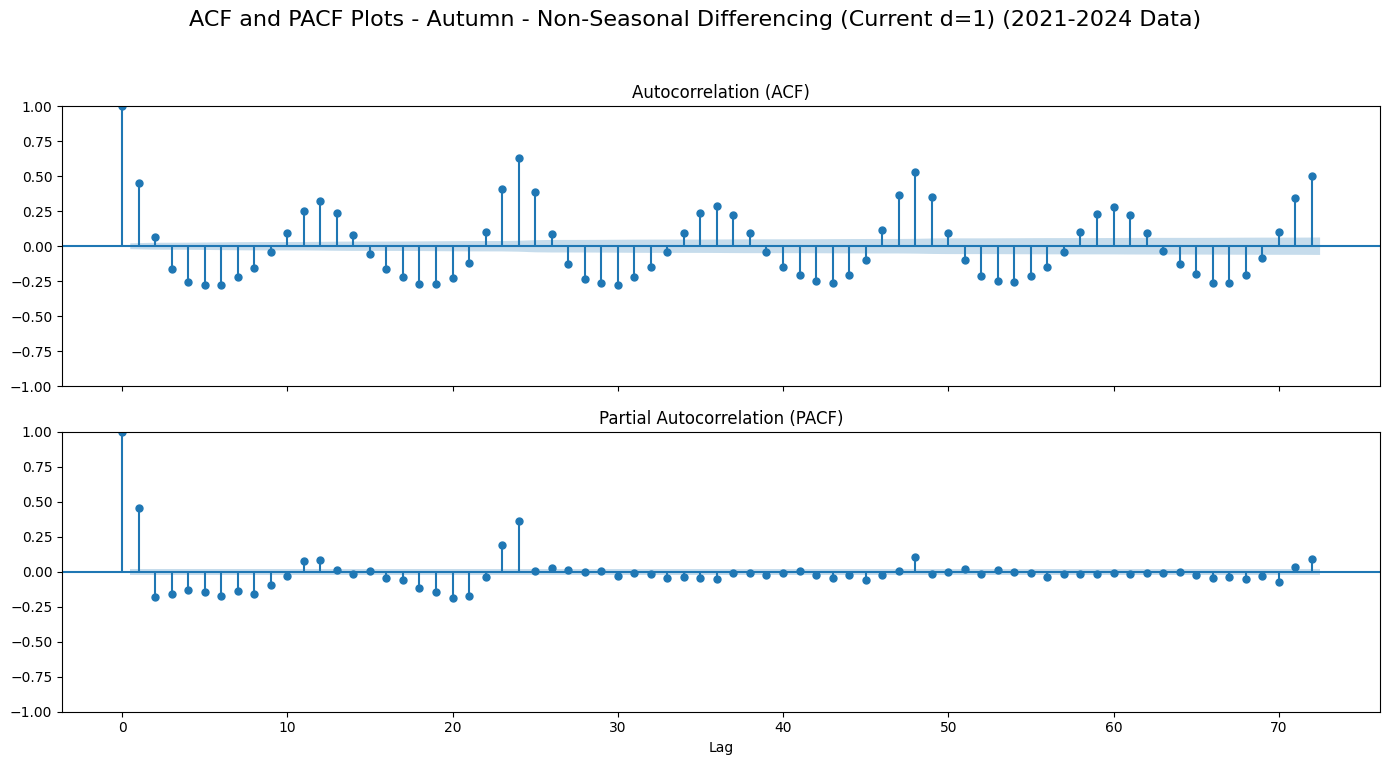

Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: no

--- SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---

--- Current Series for Seasonal Differencing (D_total=0, m=24) ---

--- Stationarity Tests (Seasonal): ---
  ADF Test: Statistic=-18.8810, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0270, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


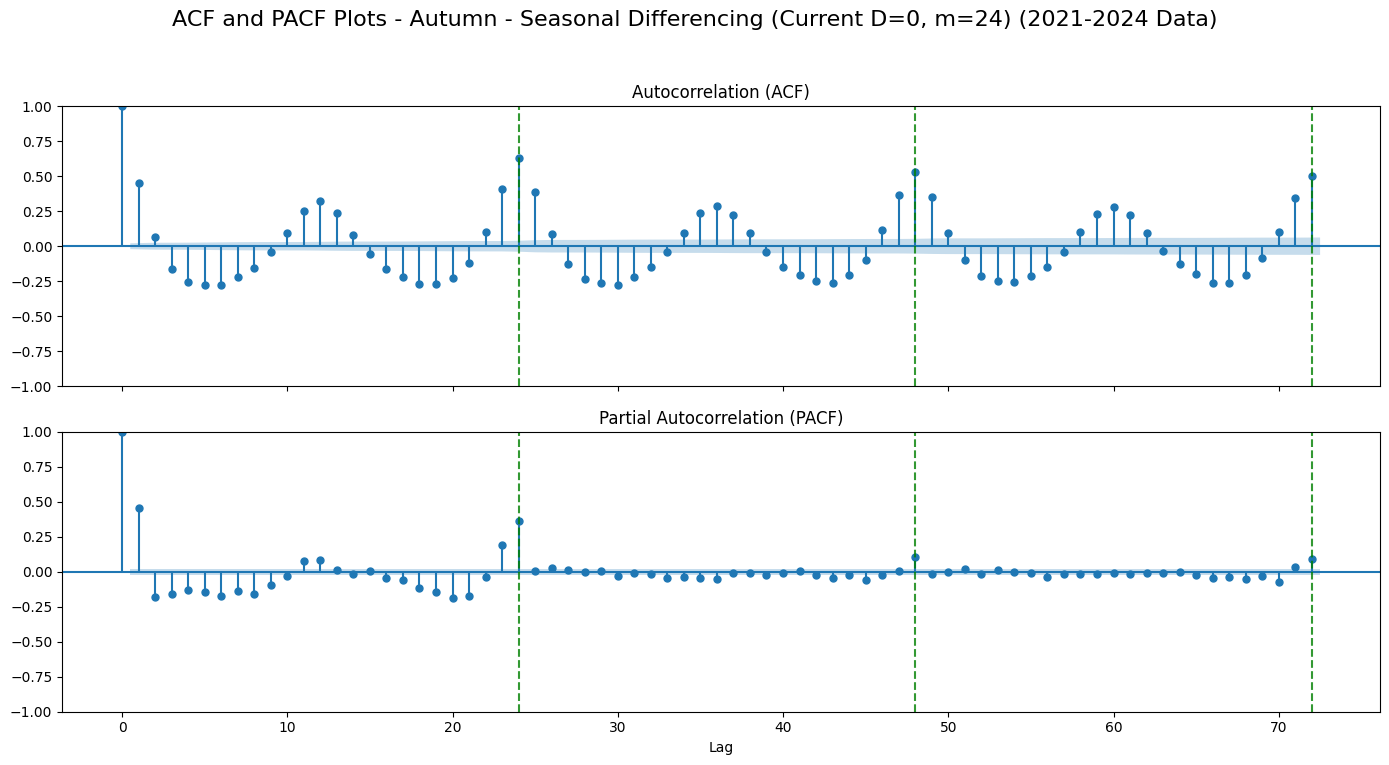

Do you want to apply seasonal differencing (D) for m=24? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: yes
Seasonal differencing applied. New total D: 1

--- Current Series for Seasonal Differencing (D_total=1, m=24) ---

--- Stationarity Tests (Seasonal): ---
  ADF Test: Statistic=-25.2530, p-value=0.0000
  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)
  KPSS Test: Statistic=0.0024, p-value=0.1000
  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)


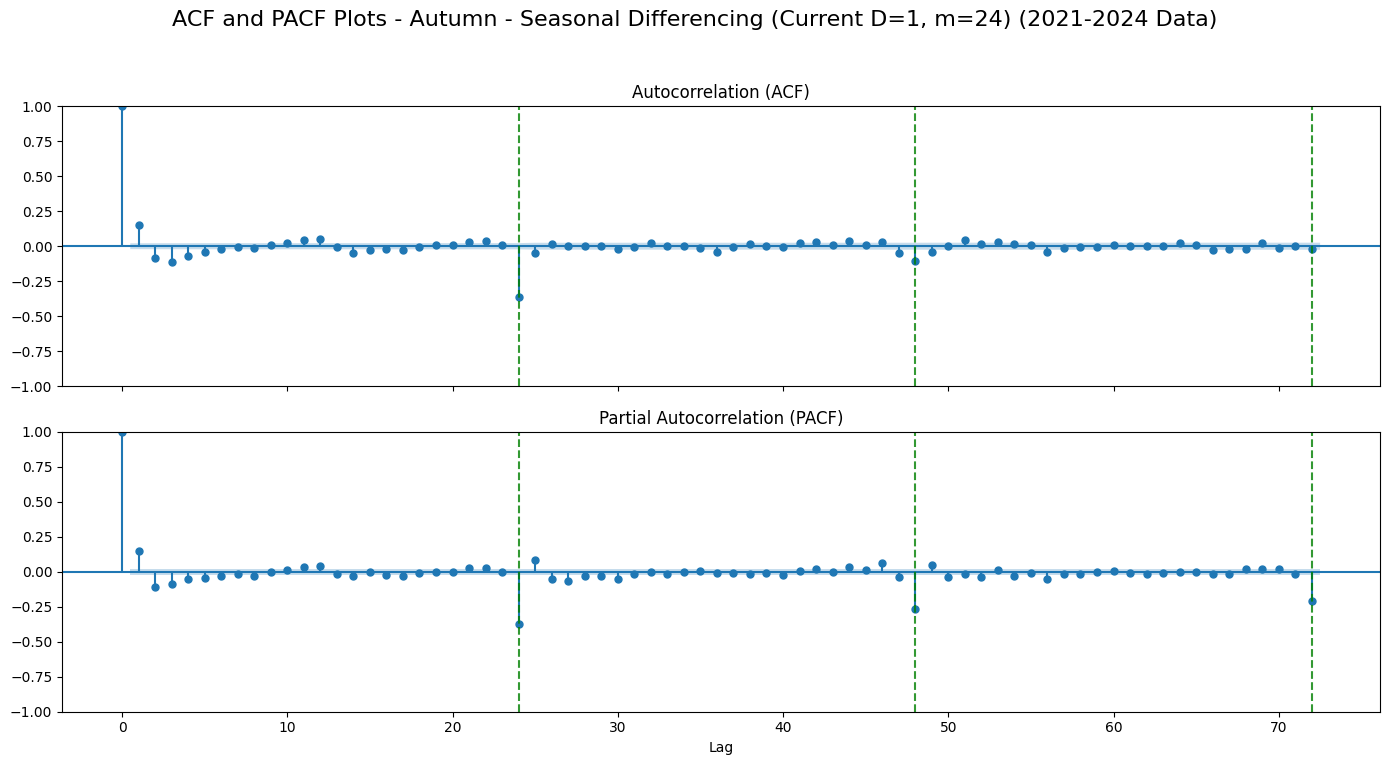

Do you want to apply seasonal differencing (D) for m=24? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: no

--- USER INPUT: Non-Seasonal ARIMA (p,d,q) ---
Based on the final differenced series (d_total=1, D_total=1, m=24),
please select p and q values for the non-seasonal part.
Enter NON-SEASONAL (p,d,q) for Season 4 (e.g., 1,1,1): 3,1,2

--- USER INPUT: Seasonal SARIMA (P,D,Q) ---
Based on the final differenced series (d_total=1, D_total=1, m=24),
please select P and Q values for the seasonal part.
Enter SEASONAL (P,D,Q) for Season 4 (e.g., 1,1,1): 1,0,0

             ORDER IDENTIFICATION COMPLETE FOR THIS SEASON.
             Moving to the next season (or final model fitting).

             POST-ANALYSIS: COMPARATIVE ACF/PACF PLOTS OF DIFFERENCING EFFECTS
             (Original, d=1, and d=1D=1 series for visual comparison)

             COMPARATIVE ACF/PACF PLOTS OF DIFFERENCING EFFECTS


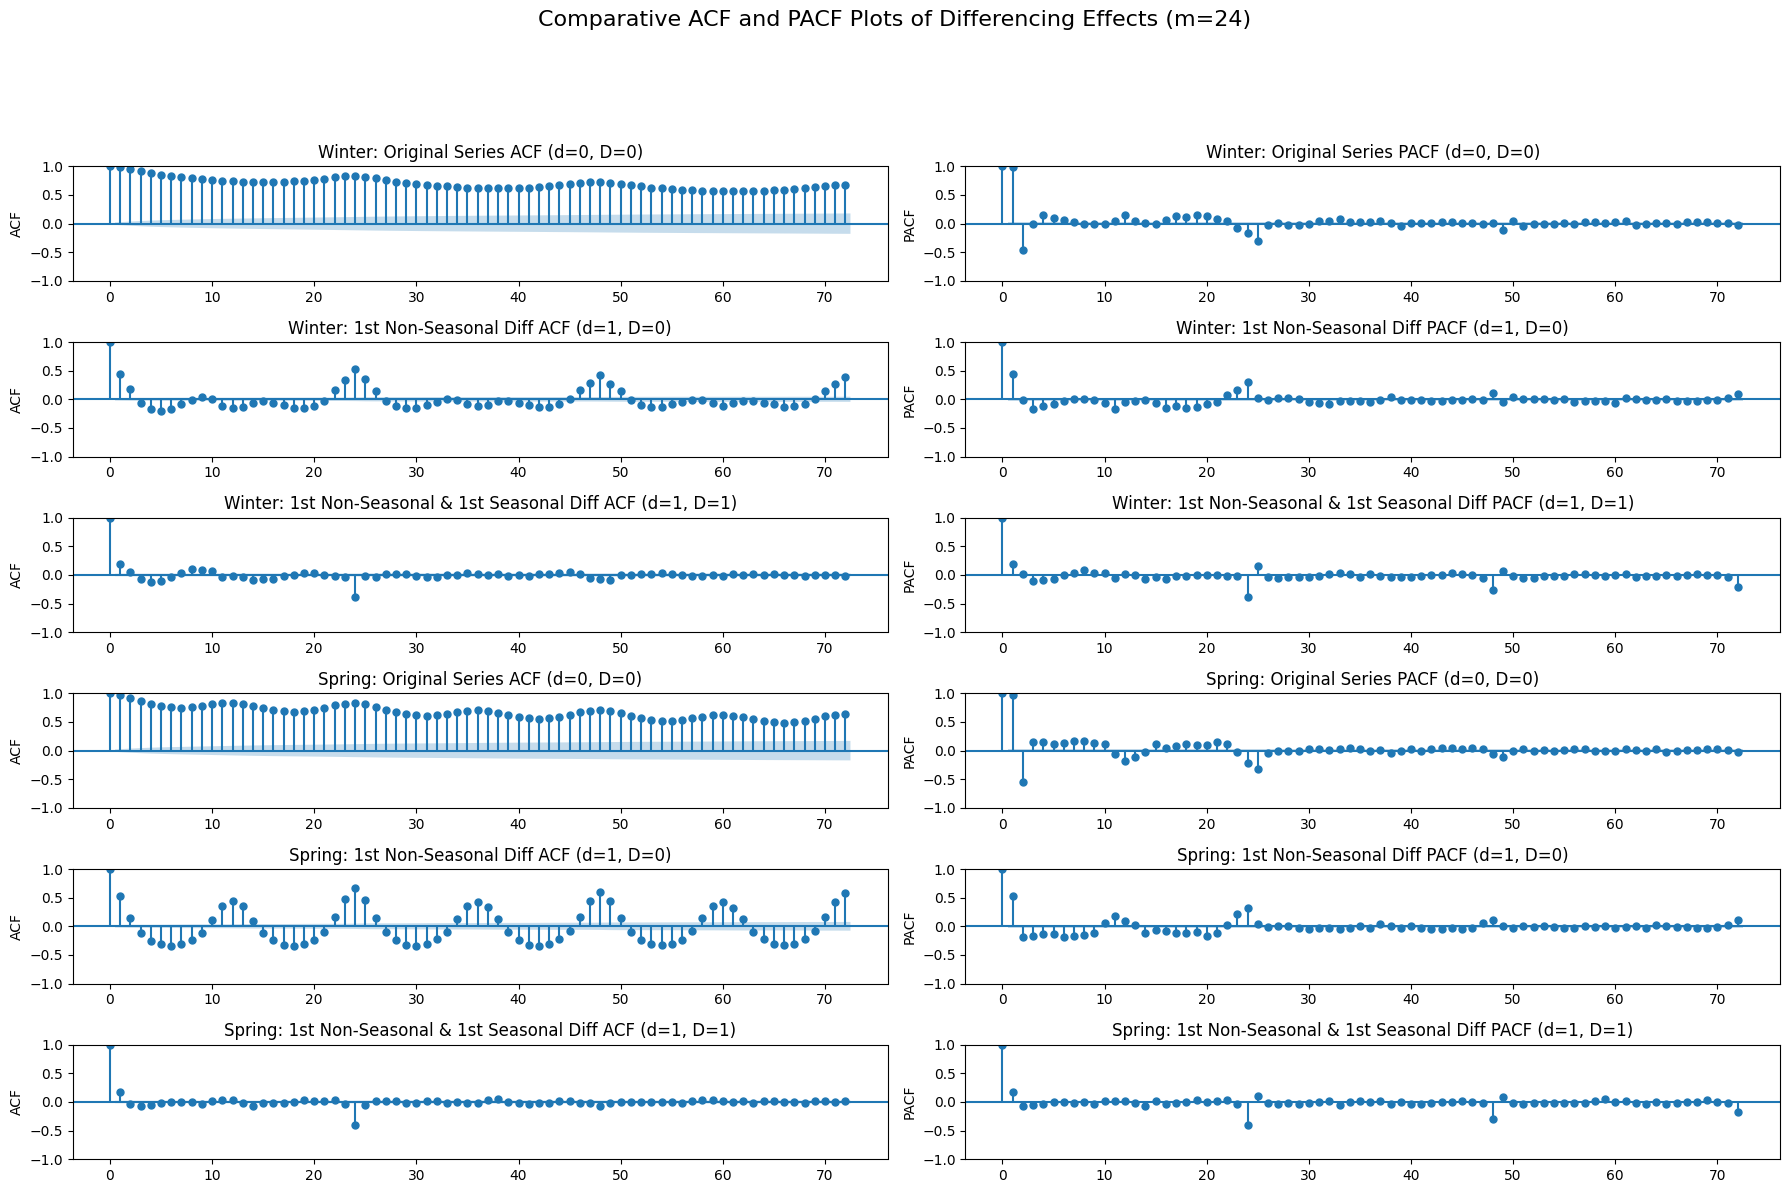


             COMPARATIVE ACF/PACF PLOTS OF DIFFERENCING EFFECTS


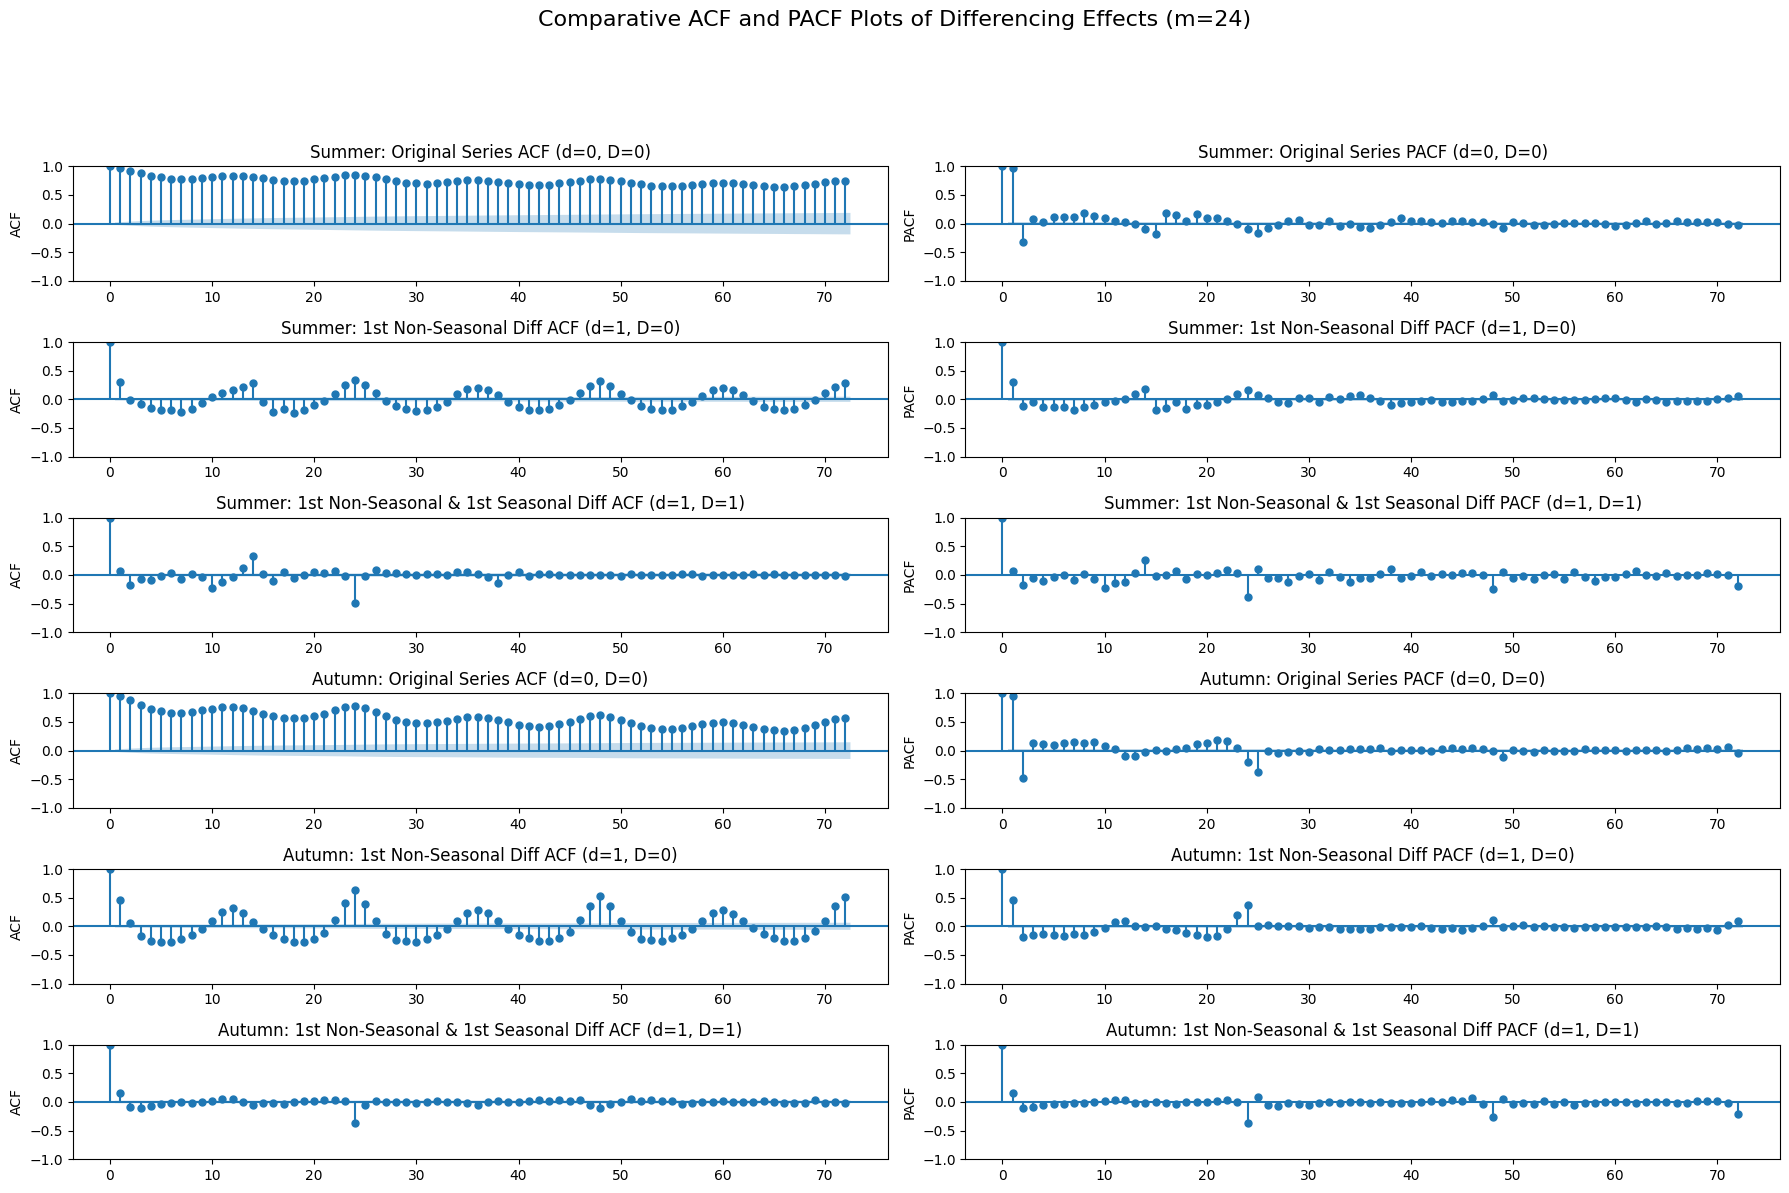


             COMPARATIVE TIME SERIES PLOTS OF DIFFERENCING EFFECTS
Time series plots for differencing effects (e.g., Original, d=1, d=2) for ['Summer', 'Spring'] would go here.
Time series plots for differencing effects (e.g., Original, d=1, d=2) for ['Winter', 'Autumn'] would go here.

             PHASE 2: BATCH MODEL FITTING AND EVALUATION
             (Applying user-identified orders and performing Ljung-Box tests)

--- Fitting and Evaluating Model for Season: WINTER ---
  Using orders: ARIMA(3, 1, 2) x Seasonal(1, 0, 1, 24)
  Model fitted successfully for Winter: AIC=29815.002, BIC=29871.511

Ljung-Box Test for Residual Autocorrelation:
       lb_stat     lb_pvalue
72  652.084006  2.519061e-94
Result: Residuals likely have significant autocorrelation (min p-value = 0.000 < 0.05).
  Ljung-Box Test (min p-value): 0.000
  Autocorrelation Pass (p>=0.05): No

--- Full Residual Diagnostics for Fitted Model (Season Winter) ---


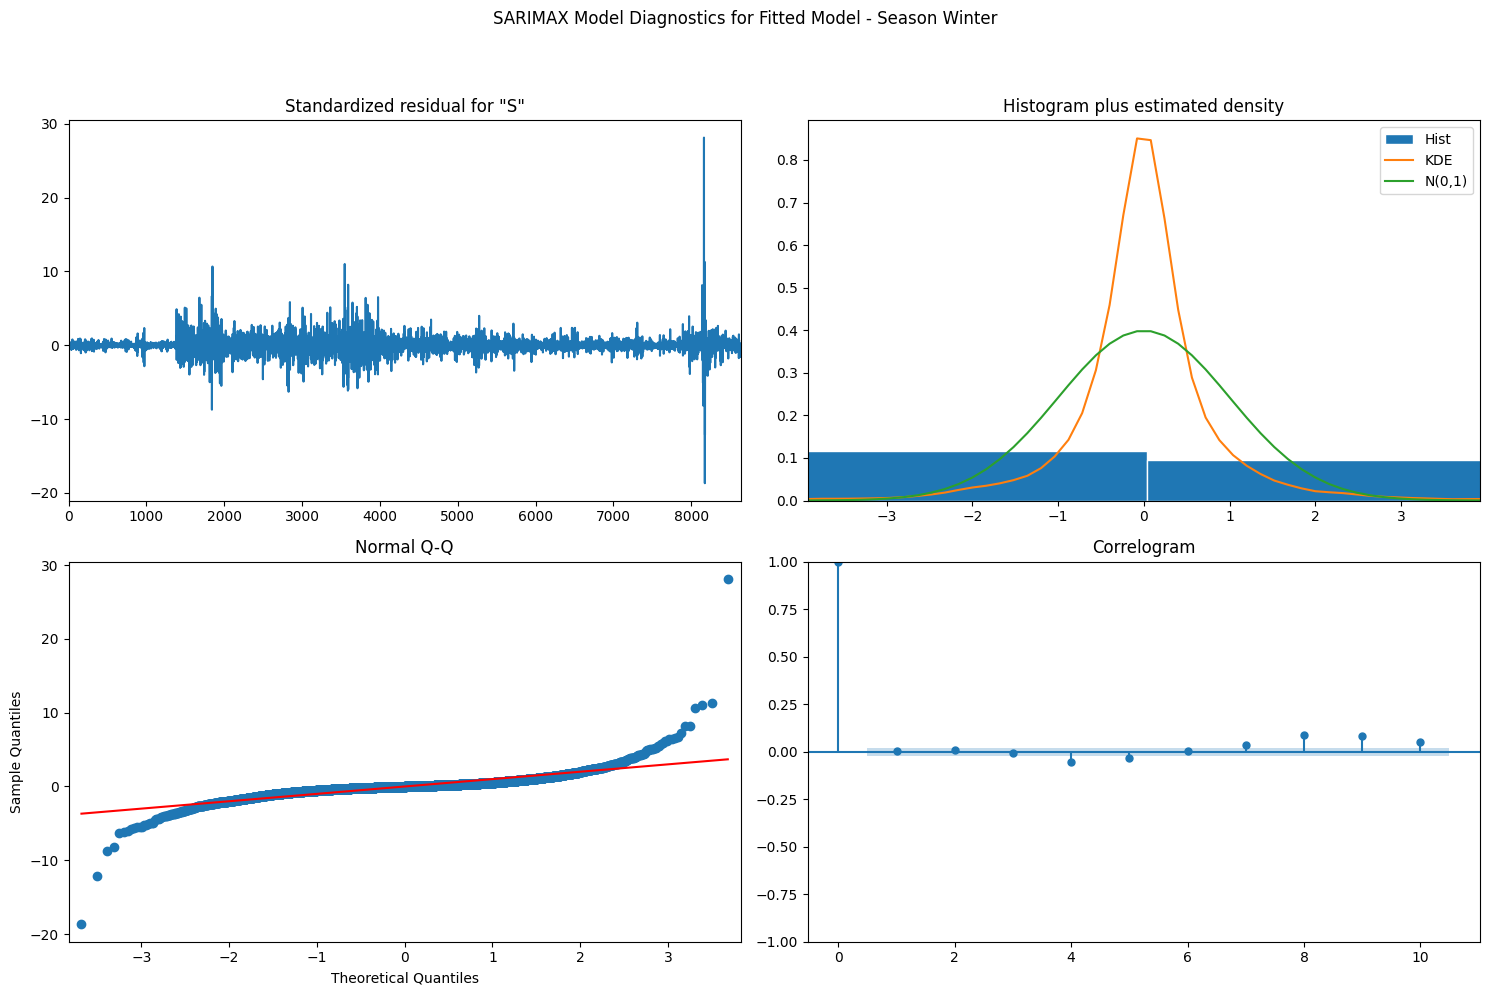

The diagnostic plots include: Standardized Residuals, Histogram with KDE, Normal Q-Q plot, and Correlogram (ACF).
NOTE: The Histogram and Q-Q plots are shown for general residual behavior, but the Ljung-Box test (Autocorr_Pass) is the primary criterion for model selection in this script.

--- Fitting and Evaluating Model for Season: SPRING ---
  Using orders: ARIMA(3, 1, 1) x Seasonal(1, 0, 0, 24)
  Model fitted successfully for Spring: AIC=28966.894, BIC=29009.391

Ljung-Box Test for Residual Autocorrelation:
        lb_stat  lb_pvalue
48  1715.192830        0.0
72  2507.484255        0.0
Result: Residuals likely have significant autocorrelation (min p-value = 0.000 < 0.05).
  Ljung-Box Test (min p-value): 0.000
  Autocorrelation Pass (p>=0.05): No

--- Full Residual Diagnostics for Fitted Model (Season Spring) ---


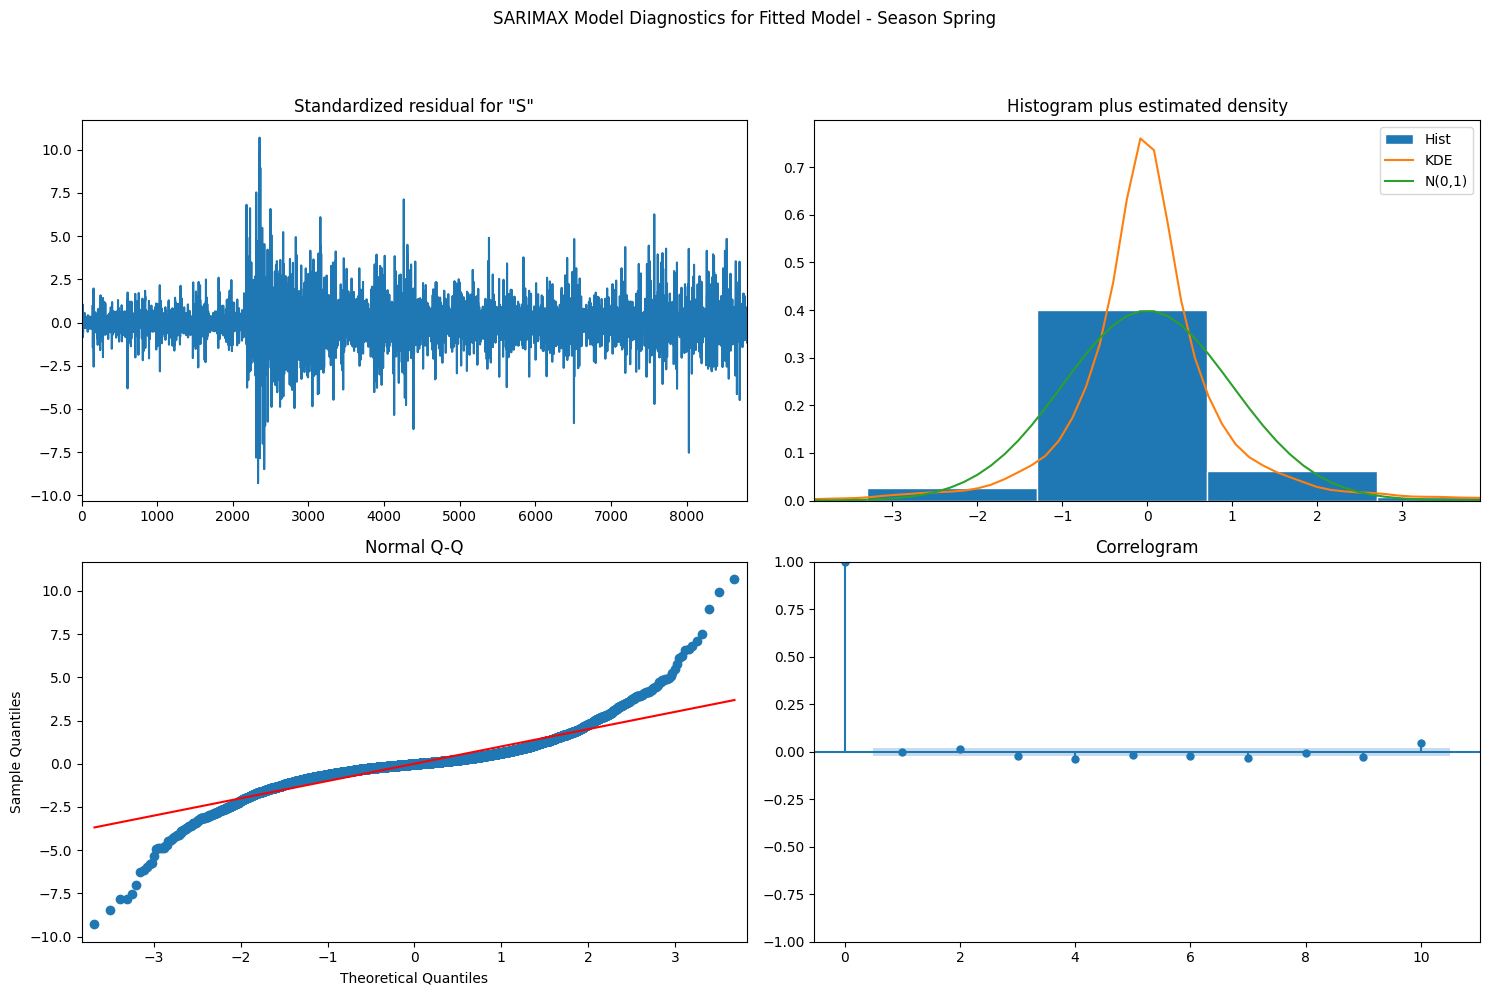

The diagnostic plots include: Standardized Residuals, Histogram with KDE, Normal Q-Q plot, and Correlogram (ACF).
NOTE: The Histogram and Q-Q plots are shown for general residual behavior, but the Ljung-Box test (Autocorr_Pass) is the primary criterion for model selection in this script.

--- Fitting and Evaluating Model for Season: SUMMER ---
  Using orders: ARIMA(3, 1, 3) x Seasonal(0, 0, 1, 24)
  Model fitted successfully for Summer: AIC=44735.940, BIC=44792.603

Ljung-Box Test for Residual Autocorrelation:
        lb_stat  lb_pvalue
48  1879.704466        0.0
72  2403.537392        0.0
Result: Residuals likely have significant autocorrelation (min p-value = 0.000 < 0.05).
  Ljung-Box Test (min p-value): 0.000
  Autocorrelation Pass (p>=0.05): No

--- Full Residual Diagnostics for Fitted Model (Season Summer) ---


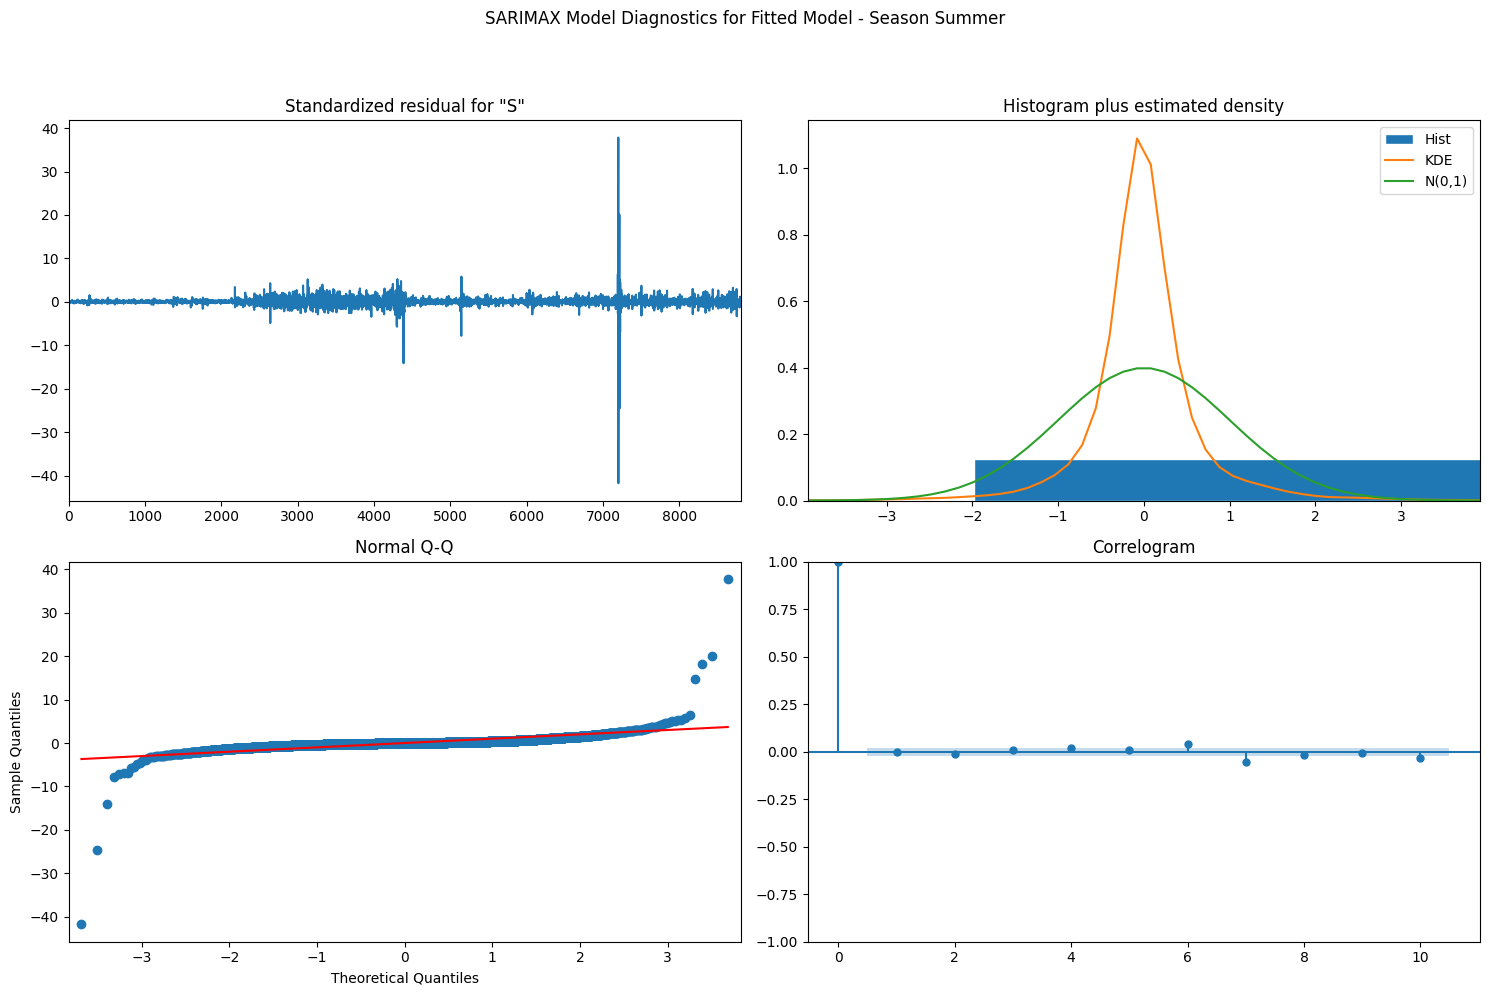

The diagnostic plots include: Standardized Residuals, Histogram with KDE, Normal Q-Q plot, and Correlogram (ACF).
NOTE: The Histogram and Q-Q plots are shown for general residual behavior, but the Ljung-Box test (Autocorr_Pass) is the primary criterion for model selection in this script.

--- Fitting and Evaluating Model for Season: AUTUMN ---
  Using orders: ARIMA(3, 1, 2) x Seasonal(1, 0, 0, 24)
  Model fitted successfully for Autumn: AIC=37445.182, BIC=37494.685

Ljung-Box Test for Residual Autocorrelation:
        lb_stat      lb_pvalue
48  1068.302309  2.311849e-192
72  1495.174657  8.159762e-265
Result: Residuals likely have significant autocorrelation (min p-value = 0.000 < 0.05).
  Ljung-Box Test (min p-value): 0.000
  Autocorrelation Pass (p>=0.05): No

--- Full Residual Diagnostics for Fitted Model (Season Autumn) ---


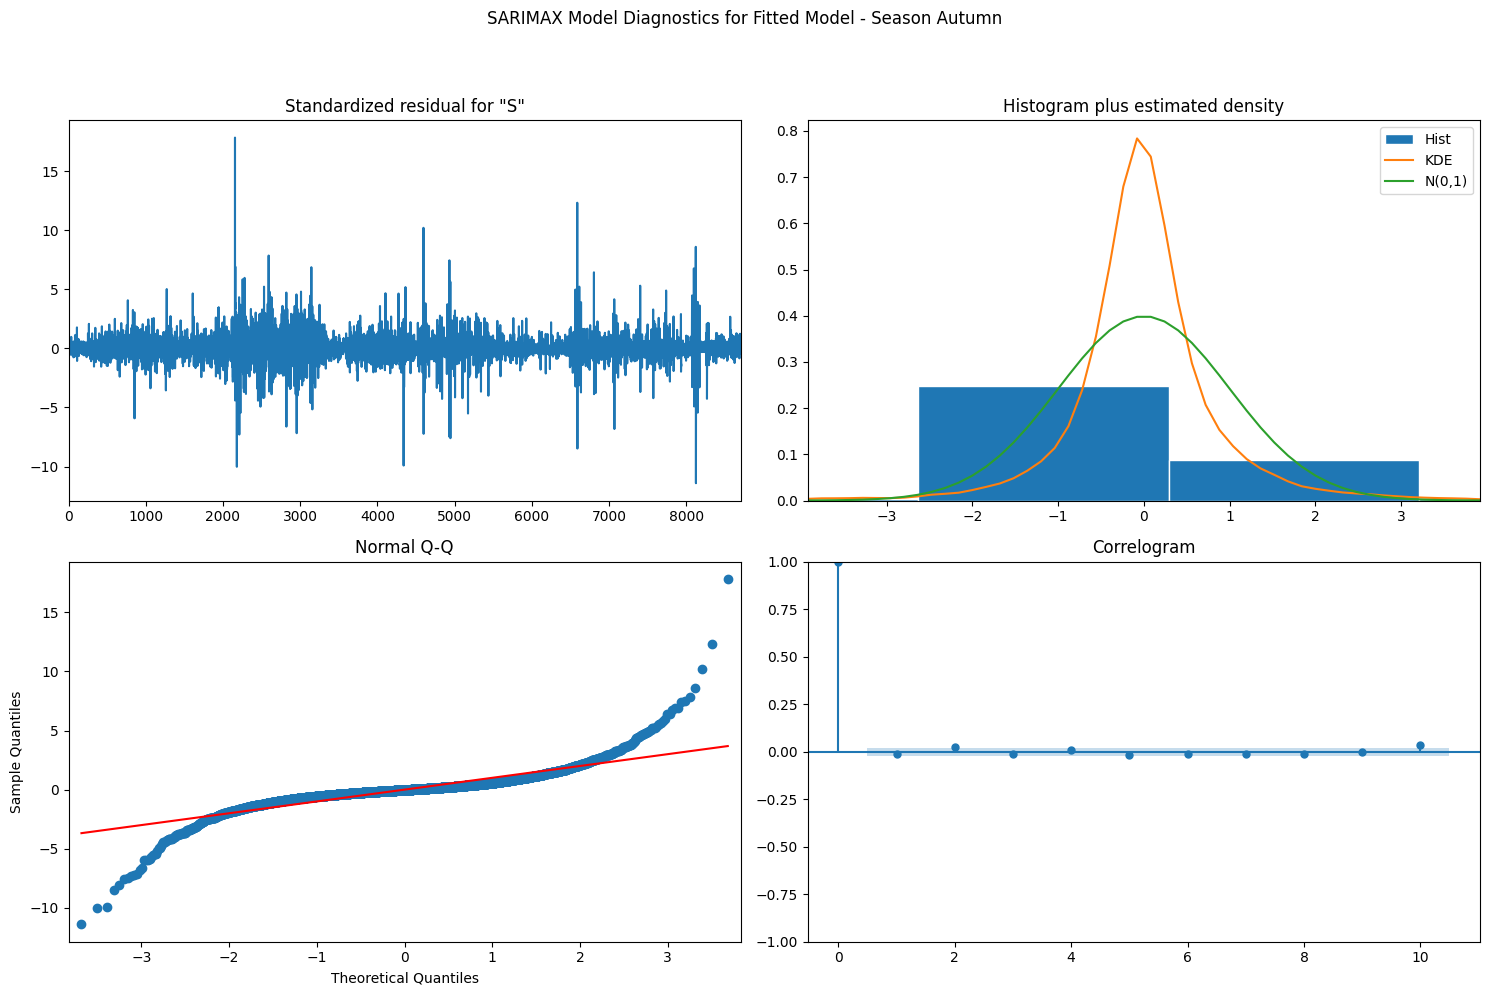

The diagnostic plots include: Standardized Residuals, Histogram with KDE, Normal Q-Q plot, and Correlogram (ACF).
NOTE: The Histogram and Q-Q plots are shown for general residual behavior, but the Ljung-Box test (Autocorr_Pass) is the primary criterion for model selection in this script.

             FINAL SARIMAX MODEL EVALUATION SUMMARY PER SEASON
Season Fixed_ARIMA_Order Selected_Seasonal_Order       AIC       BIC Ljung-Box_P-Value Autocorr_Pass
Winter         (3, 1, 2)           (1, 0, 1, 24) 29815.002 29871.511             0.000            No
Spring         (3, 1, 1)           (1, 0, 0, 24) 28966.894 29009.391             0.000            No
Summer         (3, 1, 3)           (0, 0, 1, 24) 44735.940 44792.603             0.000            No
Autumn         (3, 1, 2)           (1, 0, 0, 24) 37445.182 37494.685             0.000            No

Note: 'Autocorr_Pass' indicates if the Ljung-Box p-value is >= 0.05.
SARIMAX models were fitted on the original (non-transformed) target vari

In [17]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sys
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import StandardScaler
import seaborn as sns 

# Ignore common warnings from statsmodels for a cleaner output
warnings.filterwarnings("ignore")

# ==============================================================================
# --- Helper Functions ---
# ==============================================================================

def plot_acf_pacf(series, lags, title_suffix="", seasonal_period=None):
    """
    Plots the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
    for a given time series, with optional seasonal markers.
    """
    # Ensure the series is clean and has variance before plotting
    series_clean = series.dropna()

    if series_clean.empty:
        print(f"Warning: Cannot plot ACF/PACF for '{title_suffix}' because the series is empty after dropping NaNs.")
        return
    
    # Check for constant series or too few unique values which can cause errors or flat plots
    if series_clean.nunique() <= 1:
        print(f"Warning: Cannot plot ACF/PACF for '{title_suffix}' because the series is constant or has too few unique values ({series_clean.nunique()}). It's likely already white noise (or all zeros).")
        return

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    fig.suptitle(f'ACF and PACF Plots - {title_suffix}', fontsize=16)

    # Plot ACF
    sm.graphics.tsa.plot_acf(series_clean, lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation (ACF)')
    if seasonal_period:
        for lag in range(seasonal_period, lags + 1, seasonal_period):
            axes[0].axvline(x=lag, color='green', linestyle='--', alpha=0.8)
    axes[0].grid(False)

    # Plot PACF
    sm.graphics.tsa.plot_pacf(series_clean, lags=lags, ax=axes[1], method='ywm')
    axes[1].set_title('Partial Autocorrelation (PACF)')
    if seasonal_period:
        for lag in range(seasonal_period, lags + 1, seasonal_period):
            axes[1].axvline(x=lag, color='green', linestyle='--', alpha=0.8)
    axes[1].grid(False)

    plt.xlabel('Lag')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def get_user_order(prompt_text):
    """Generic function to get a comma-separated order (p,d,q) from the user."""
    while True:
        try:
            order_str = input(prompt_text).strip()
            if not order_str:
                raise ValueError("Input cannot be empty.")
            order_tuple = tuple(map(int, order_str.split(',')))
            if len(order_tuple) != 3:
                raise ValueError("Please enter exactly three comma-separated integers (e.g., 1,0,1).")
            if not all(x >= 0 for x in order_tuple):
                raise ValueError("All integers must be non-negative.")
            return order_tuple
        except ValueError as e:
            print(f"Invalid input: {e}. Please try again.")

def get_user_m_period():
    """Gets the seasonal period (m) from the user. Fixed to 24 for this script."""
    print("\nSeasonal period (m) for this analysis is fixed at 24 hours (daily seasonality).")
    return 24

def perform_stationarity_tests(series, test_type='non-seasonal', period=None):
    """
    Performs ADF and KPSS tests on a series and prints results.
    """
    series_clean = series.dropna()

    if len(series_clean) < 10: # ADF/KPSS need a reasonable number of observations
        print(f"  Not enough data ({len(series_clean)} points) for ADF/KPSS tests. Skipping tests.")
        return

    if series_clean.nunique() <= 1: # If series is constant
        print(f"  Series is constant (or too few unique values). Assumed stationary.")
        return
        
    print(f"\n--- Stationarity Tests ({test_type.capitalize()}): ---")
    
    # ADF Test
    try:
        adftest_result = adfuller(series_clean)
        adf_pvalue = adftest_result[1]
        print(f'  ADF Test: Statistic={adftest_result[0]:.4f}, p-value={adf_pvalue:.4f}')
        if adf_pvalue < 0.05:
            print(f'  Result: Appears Stationary (ADF p-value < 0.05). (Reject H0: Unit Root)')
        else:
            print(f'  Result: Appears Non-Stationary (ADF p-value >= 0.05). (Fail to Reject H0: Unit Root)')
    except Exception as e:
        print(f"  Error during ADF test: {e}")

    # KPSS Test
    try:
        kpss_stat, kpss_pvalue, _, _ = kpss(series_clean, regression='c', nlags='auto')
        print(f'  KPSS Test: Statistic={kpss_stat:.4f}, p-value={kpss_pvalue:.4f}')
        if kpss_pvalue >= 0.05:
            print(f'  Result: Appears Stationary (KPSS p-value >= 0.05). (Fail to Reject H0: Stationarity)')
        else:
            print(f'  Result: Appears Non-Stationary (KPSS p-value < 0.05). (Reject H0: Stationarity)')
    except Exception as e:
        print(f"  Error during KPSS test: {e}")


def evaluate_model_diagnostics_lb_only(fit_result, seasonal_period):
    """
    Performs Ljung-Box test for residual autocorrelation on a fitted SARIMAX model's residuals.
    Returns Ljung-Box p-value.
    """
    lb_pvalue = np.nan
    
    residuals = fit_result.resid.dropna() # Ensure residuals are clean before tests
    if residuals.empty:
        print("Warning: Residuals are empty after dropping NaNs. Cannot perform diagnostic tests.")
        return np.nan
    if residuals.nunique() <= 1: # If residuals are constant
        print("Warning: Residuals are constant or have too few unique values. Cannot perform Ljung-Box test.")
        return np.nan


    # Ljung-Box Test for Autocorrelation of Residuals
    try:
        num_params = fit_result.model.k_ar + fit_result.model.k_ma + \
                     fit_result.model.k_seasonal_ar + fit_result.model.k_seasonal_ma
        if fit_result.model.exog is not None:
             num_params += fit_result.model.k_exog
        
        # Ensure lags are greater than num_params and within bounds
        # Ljung-Box lags should typically be at least 'num_params + 1'
        suggested_lags = [int(seasonal_period), int(2 * seasonal_period), int(3 * seasonal_period)]
        
        # Filter lags to be positive, within bounds, and greater than num_params
        # Max lag for Ljung-Box should be less than len(residuals)
        max_allowable_lag = max(1, len(residuals) - 1) # Must be at least 1, and less than total residuals
        
        # Ensure selected lags are valid: > num_params and <= max_allowable_lag
        ljung_box_lags = [l for l in suggested_lags if l > num_params and l <= max_allowable_lag]
        
        # If no suitable seasonal lags, try generic lags
        if not ljung_box_lags:
            generic_lags_candidates = [num_params + 1, num_params + 5, num_params + 10]
            ljung_box_lags = [int(l) for l in generic_lags_candidates if l > 0 and l <= max_allowable_lag]
            # Ensure unique and sorted lags
            ljung_box_lags = sorted(list(set(ljung_box_lags)))
            
        if ljung_box_lags:
            lb_test = acorr_ljungbox(residuals, lags=ljung_box_lags, return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].min() # Take the minimum p-value across tested lags
            print("\nLjung-Box Test for Residual Autocorrelation:")
            print(lb_test)
            if lb_pvalue >= 0.05:
                print(f"Result: Residuals appear to have no significant autocorrelation (min p-value = {lb_pvalue:.3f} >= 0.05).")
            else:
                print(f"Result: Residuals likely have significant autocorrelation (min p-value = {lb_pvalue:.3f} < 0.05).")
        else:
            print(f"Warning: Not enough valid lags for Ljung-Box test for this model. Model parameters: {num_params}, Residuals length: {len(residuals)}")
    except Exception as e:
        print(f"Error during Ljung-Box test: {e}")

    return lb_pvalue

# Removed plot_differencing_effects as per user request to avoid "weird plots" and focus on ACF/PACF grid

def plot_comparative_acf_pacf(collected_seasonal_inputs, seasons_to_compare, seasonal_period_val):
    """
    Generates comparative grid plots for ACF and PACF of the final differenced series
    for specified seasons. This is the "final differenced" view.
    """
    print("\n" + "="*80)
    print("             COMPARATIVE ACF/PACF PLOTS FOR FINAL DIFFERENCED SERIES")
    print("================================================================================")

    num_seasons = len(seasons_to_compare)
    # Each season needs 2 plots (ACF, PACF)
    fig, axes = plt.subplots(num_seasons * 2, 1, figsize=(14, 4 * num_seasons), sharex=True)
    
    # Ensure axes is always a 1D array for consistent indexing, even if num_seasons is 1
    if num_seasons * 2 == 1:
        axes = np.array([axes])
    elif num_seasons * 2 > 1:
        axes = axes.flatten()

    fig.suptitle(f'ACF and PACF Plots of Final Differenced Series Across Seasons (m={seasonal_period_val})', fontsize=16, y=1.02)

    plot_idx = 0
    for i, s_name in enumerate(seasons_to_compare):
        if s_name not in collected_seasonal_inputs or 'final_differenced_data' not in collected_seasonal_inputs[s_name]:
            print(f"Warning: Final differenced data for season '{s_name}' not found. Skipping ACF/PACF plots.")
            # Increment plot_idx even if skipping to maintain correct indexing for subsequent plots
            plot_idx += 2 
            continue
        
        series_clean = collected_seasonal_inputs[s_name]['final_differenced_data'].dropna()

        if series_clean.empty or series_clean.nunique() <= 1:
            print(f"Warning: Cannot plot comparative ACF/PACF for '{s_name}' because the final differenced series is empty or constant.")
            # Increment plot_idx even if skipping
            plot_idx += 2
            continue

        # Plot ACF
        ax_acf = axes[plot_idx]
        sm.graphics.tsa.plot_acf(series_clean, lags=seasonal_period_val*3, ax=ax_acf)
        ax_acf.set_title(f'{s_name}: Autocorrelation (ACF) of Final Differenced Series')
        for lag in range(seasonal_period_val, seasonal_period_val*3 + 1, seasonal_period_val):
            ax_acf.axvline(x=lag, color='green', linestyle='--', alpha=0.8)
        ax_acf.grid(False)
        ax_acf.set_ylabel('ACF')
        plot_idx += 1

        # Plot PACF
        ax_pacf = axes[plot_idx]
        sm.graphics.tsa.plot_pacf(series_clean, lags=seasonal_period_val*3, ax=ax_pacf, method='ywm')
        ax_pacf.set_title(f'{s_name}: Partial Autocorrelation (PACF) of Final Differenced Series')
        for lag in range(seasonal_period_val, seasonal_period_val*3 + 1, seasonal_period_val):
            ax_pacf.axvline(x=lag, color='green', linestyle='--', alpha=0.8)
        ax_pacf.grid(False)
        ax_pacf.set_ylabel('PACF')
        plot_idx += 1

    # Hide any remaining empty subplots
    for j in range(plot_idx, len(axes)):
        axes[j].set_visible(False)

    plt.xlabel('Lag') # This will be the label for the very last plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_comparative_differencing_acf_pacf_grid(collected_seasonal_inputs, seasons_to_compare, seasonal_period_val):
    """
    Generates comparative grid plots for ACF and PACF of original, d=1, and d=1D=1 series
    for specified seasons, for visual comparison of differencing effects on autocorrelation.
    """
    print("\n" + "="*80)
    print("             COMPARATIVE ACF/PACF PLOTS OF DIFFERENCING EFFECTS")
    print("================================================================================")

    num_seasons = len(seasons_to_compare)
    # Each season will have up to 3 rows (Original, d=1, d=1D=1) x 2 columns (ACF, PACF)
    
    fig, axes = plt.subplots(num_seasons * 3, 2, figsize=(18, 6 * num_seasons), sharex=False) 
    
    # Ensure axes is always a 1D array for consistent indexing
    if num_seasons * 3 * 2 == 1: 
        axes = np.array([axes])
    else:
        axes = axes.flatten() 

    fig.suptitle(f'Comparative ACF and PACF Plots of Differencing Effects (m={seasonal_period_val})', fontsize=16, y=1.02)

    plot_idx = 0
    for s_name in seasons_to_compare:
        if s_name not in collected_seasonal_inputs:
            print(f"Warning: Data for season '{s_name}' not found. Skipping comparative ACF/PACF plots.")
            plot_idx += 6 # Skip 3 rows (6 subplots) for this season
            continue
        
        season_data = collected_seasonal_inputs[s_name]
        
        # Original Series (d=0, D=0)
        series_orig = season_data['target_data'].dropna()
        if not series_orig.empty and series_orig.nunique() > 1:
            # ACF
            sm.graphics.tsa.plot_acf(series_orig, lags=seasonal_period_val*3, ax=axes[plot_idx])
            axes[plot_idx].set_title(f'{s_name}: Original Series ACF (d=0, D=0)')
            axes[plot_idx].grid(False)
            axes[plot_idx].set_ylabel('ACF')
            plot_idx += 1
            # PACF
            sm.graphics.tsa.plot_pacf(series_orig, lags=seasonal_period_val*3, ax=axes[plot_idx], method='ywm')
            axes[plot_idx].set_title(f'{s_name}: Original Series PACF (d=0, D=0)')
            axes[plot_idx].grid(False)
            axes[plot_idx].set_ylabel('PACF')
            plot_idx += 1
        else:
            axes[plot_idx].set_visible(False)
            axes[plot_idx+1].set_visible(False)
            plot_idx += 2
            print(f"Warning: Original series for '{s_name}' is empty or constant. Skipping its ACF/PACF plots.")

        # 1st Non-Seasonal Differenced Series (d=1, D=0)
        series_d1 = season_data['d1_series'].dropna()
        if not series_d1.empty and series_d1.nunique() > 1:
            # ACF
            sm.graphics.tsa.plot_acf(series_d1, lags=seasonal_period_val*3, ax=axes[plot_idx])
            axes[plot_idx].set_title(f'{s_name}: 1st Non-Seasonal Diff ACF (d=1, D=0)')
            axes[plot_idx].grid(False)
            axes[plot_idx].set_ylabel('ACF')
            plot_idx += 1
            # PACF
            sm.graphics.tsa.plot_pacf(series_d1, lags=seasonal_period_val*3, ax=axes[plot_idx], method='ywm')
            axes[plot_idx].set_title(f'{s_name}: 1st Non-Seasonal Diff PACF (d=1, D=0)')
            axes[plot_idx].grid(False)
            axes[plot_idx].set_ylabel('PACF')
            plot_idx += 1
        else:
            axes[plot_idx].set_visible(False)
            axes[plot_idx+1].set_visible(False)
            plot_idx += 2
            print(f"Warning: 1st non-seasonal differenced series for '{s_name}' is empty or constant. Skipping its ACF/PACF plots.")

        # 1st Non-Seasonal and 1st Seasonal Differenced Series (d=1, D=1)
        series_d1_D1 = season_data['d1_D1_series'].dropna()
        if not series_d1_D1.empty and series_d1_D1.nunique() > 1:
            # ACF
            sm.graphics.tsa.plot_acf(series_d1_D1, lags=seasonal_period_val*3, ax=axes[plot_idx])
            axes[plot_idx].set_title(f'{s_name}: 1st Non-Seasonal & 1st Seasonal Diff ACF (d=1, D=1)')
            axes[plot_idx].grid(False)
            axes[plot_idx].set_ylabel('ACF')
            plot_idx += 1
            # PACF
            sm.graphics.tsa.plot_pacf(series_d1_D1, lags=seasonal_period_val*3, ax=axes[plot_idx], method='ywm')
            axes[plot_idx].set_title(f'{s_name}: 1st Non-Seasonal & 1st Seasonal Diff PACF (d=1, D=1)')
            axes[plot_idx].grid(False)
            axes[plot_idx].set_ylabel('PACF')
            plot_idx += 1
        else:
            axes[plot_idx].set_visible(False)
            axes[plot_idx+1].set_visible(False)
            plot_idx += 2
            print(f"Warning: 1st non-seasonal and 1st seasonal differenced series for '{s_name}' is empty or constant. Skipping its ACF/PACF plots.")

    # Hide any remaining empty subplots
    for j in range(plot_idx, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# ==============================================================================
# --- Main Script Execution ---
# ==============================================================================

if __name__ == "__main__":
    # --- Configuration ---
    target_variable = 'Spot market price(cents/kWh)'

    # --- Data Loading ---
    csv_file_path = './Spot Price_less variables_Hourly_Data.csv'
    try:
        df = pd.read_csv(csv_file_path, index_col='Date', parse_dates=True)
        # Load all data from 2015 onwards for general statistics and exogenous variable plots
        df = df.loc['2015-01-01':] 
        print(f"Data shape after filtering for 2015 onwards: {df.shape}")
    except FileNotFoundError:
        print(f"Error: Data file '{csv_file_path}' not found. Please ensure it's in the same directory.")
        sys.exit(1) # Exit if the primary data file is missing

    # Handle duplicate indices and sort the DataFrame by Date
    df = df[~df.index.duplicated(keep='first')].sort_index()
    print(f"Data loaded successfully from '{csv_file_path}'. Initial shape: {df.shape}\n")

    # --- Use ORIGINAL target variable (NO TRANSFORMATION) ---
    target_series = df[target_variable].copy()
    print(f"Using ORIGINAL target variable: '{target_variable}' (NO transformation).")


    # --- Identify and Prepare Exogenous Variables ---
    exogenous_variables_list = [col for col in df.columns if col != target_variable]
    exog_df_original = df[exogenous_variables_list].copy() # Keep original for plotting

    # --- Data Cleaning (NaN handling) for Target and Exogenous Variables ---
    initial_rows = df.shape[0]
    
    # Combine target and exog for joint NaN handling to ensure alignment
    if not exog_df_original.empty:
        df_combined_clean = pd.concat([target_series, exog_df_original], axis=1).dropna()
        target_series_full_range = df_combined_clean[target_variable] # Keep full range for negative price analysis
        exog_df_original_full_range = df_combined_clean[exogenous_variables_list] # Keep full range for negative price analysis
    else:
        target_series_full_range = target_series.dropna()
        exog_df_original_full_range = pd.DataFrame() # No exog data
        df_combined_clean = target_series_full_range.to_frame() # For consistent row count comparison


    if df_combined_clean.shape[0] < initial_rows:
        print(f"Dropped {initial_rows - df_combined_clean.shape[0]} rows due to NaNs in target or exogenous variables. Remaining rows: {df_combined_clean.shape[0]}")
    else:
        print(f"No NaNs found in target or exogenous variables. Total rows: {df_combined_clean.shape[0]}")

    # --- Normalize Exogenous Variables (FOR MODEL FITTING ONLY) ---
    # This scaler will be fitted on the 2021-2024 data later in the loop
    exog_scaled_for_model = pd.DataFrame() 
    if not exog_df_original_full_range.empty: # Use full range for initial scaler setup
        scaler = StandardScaler()
        # Note: fit_transform will be applied to the 2021-2024 subset within the loop for consistency
        # This scaler instance will be used to transform data for model fitting
        
    collected_seasonal_inputs = {} # To store (p,d,q) and (P,D,Q,m) for each season
    
    # ==========================================================================
    # --- PLOT ORIGINAL EXOGENOUS VARIABLES (ALL DATA, 2015-2024) - Moved outside loop ---
    # ==========================================================================
    print("\n" + "="*80)
    print("             PLOTS FOR ORIGINAL EXOGENOUS VARIABLES (ALL DATA, 2015-2024)")
    print("================================================================================")
    if not exog_df_original_full_range.empty:
        print("\nDescriptive Statistics for Original Exogenous Variables (All Data, 2015-2024):")
        print(exog_df_original_full_range.describe()) # Removed seasonal filter here

        num_exogs = len(exog_df_original_full_range.columns)
        cols = 2
        rows = (num_exogs + cols - 1) // cols
        
        fig_exog, axes_exog = plt.subplots(rows, cols, figsize=(15, 4 * rows), squeeze=False)
        axes_exog = axes_exog.flatten()

        for i, col in enumerate(exog_df_original_full_range.columns):
            if i < len(axes_exog):
                sns.histplot(exog_df_original_full_range[col], ax=axes_exog[i], kde=True) # Removed seasonal filter here
                axes_exog[i].set_title(f'Original {col} (All Data, 2015-2024)')
                axes_exog[i].set_xlabel('Original Value')
                axes_exog[i].set_ylabel('Frequency')
                axes_exog[i].grid(True)

        for j in range(i + 1, len(axes_exog)):
            fig_exog.delaxes(axes_exog[j])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle(f'Original Exogenous Variables Histograms (All Data, 2015-2024)', y=0.98, fontsize=16) # Adjusted title
        plt.show()
    else:
        print(f"No original exogenous variables to plot for the entire dataset.")


    # ==========================================================================
    # --- Phase 1: Seasonal EDA and Order Identification Loop ---
    # ==========================================================================
    print("\n" + "="*80)
    print("             PHASE 1: SEASONAL EDA AND ORDER IDENTIFICATION")
    print("             (You will visually inspect plots and input ARIMA orders)")
    print("================================================================================")

    for season_num in range(1, 5):
        print("\n" + "="*80)
        # Reverted season order to Winter, Spring, Summer, Autumn
        if season_num == 1: months, s_name = [12, 1, 2], "Winter" # Winter is Dec, Jan, Feb
        elif season_num == 2: months, s_name = [3, 4, 5], "Spring" # Spring is Mar, Apr, May
        elif season_num == 3: months, s_name = [6, 7, 8], "Summer" # Summer is Jun, Jul, Aug
        else: months, s_name = [9, 10, 11], "Autumn" # Autumn is Sep, Oct, Nov
        print(f"             ANALYZING SEASON {season_num}: {s_name.upper()} (Months: {months})")
        print("="*80)

        # Select seasonal data for target variable, filtered to 2021-2024 for differencing and modeling
        current_seasonal_target_data = target_series_full_range[target_series_full_range.index.month.isin(months)].loc['2021-01-01':].copy().dropna()
        
        # Select seasonal data for ORIGINAL exogenous variables (for plotting/stats), filtered to 2021-2024
        current_seasonal_exog_data_original_filtered = pd.DataFrame()
        if not exog_df_original_full_range.empty:
            current_seasonal_exog_data_original_filtered = exog_df_original_full_range[exog_df_original_full_range.index.month.isin(months)].loc['2021-01-01':].copy().dropna()
            # Ensure final alignment between target and seasonal exog (original) after individual season slicing/dropna
            aligned_index_original = current_seasonal_target_data.index.intersection(current_seasonal_exog_data_original_filtered.index)
            current_seasonal_target_data = current_seasonal_target_data.loc[aligned_index_original]
            current_seasonal_exog_data_original_filtered = current_seasonal_exog_data_original_filtered.loc[aligned_index_original]
        
        if current_seasonal_target_data.empty:
            print("No target data available for this season after filtering/NaN handling. Skipping.\n")
            continue
            
        # Get seasonal period (m) from user (fixed at 24)
        current_seasonal_period = get_user_m_period() # This function is now fixed to return 24
        
        min_data_for_analysis_base = max(current_seasonal_period * 2, 60) 
        if len(current_seasonal_target_data) < min_data_for_analysis_base:
            print(f"Warning: Insufficient target data points ({len(current_seasonal_target_data)}) for Season {s_name} analysis (need at least {min_data_for_analysis_base} for m={current_seasonal_period}). Skipping.")
            continue

        print(f"Data points for {s_name} (Target): {len(current_seasonal_target_data)}")
        if not current_seasonal_exog_data_original_filtered.empty:
            print(f"Data points for {s_name} (Original Exogenous, filtered 2021-2024): {len(current_seasonal_exog_data_original_filtered)}")


        # --- EXOGENOUS VARIABLES DURING NEGATIVE SPOT PRICES (Histograms of Original Values) ---
        # This section uses the full range data (2015-2024)
        print(f"\n--- Exogenous Variables Distribution during Negative Spot Prices in {s_name} (Histograms of ORIGINAL Values, 2015-2024) ---")
        
        # Use full range target_series_full_range and exog_df_original_full_range for this specific plot
        negative_price_points_target_full = target_series_full_range[target_series_full_range.index.month.isin(months)][target_series_full_range < 0]

        if not negative_price_points_target_full.empty and not exog_df_original_full_range.empty:
            exogs_during_negative_prices_original_full = exog_df_original_full_range.loc[negative_price_points_target_full.index].dropna()

            if not exogs_during_negative_prices_original_full.empty:
                print(f"Found {len(exogs_during_negative_prices_original_full)} instances of negative spot prices in {s_name} (2015-2024).")
                print("\nDescriptive Statistics for ORIGINAL Exogenous Variables during Negative Prices:")
                print(exogs_during_negative_prices_original_full.describe())

                # Check for constant columns in exogs_during_negative_prices_original_full
                constant_exogs = [col for col in exogs_during_negative_prices_original_full.columns if exogs_during_negative_prices_original_full[col].nunique() <= 1]
                if constant_exogs:
                    print(f"Note: The following exogenous variables are constant or have too few unique values during negative prices in {s_name} (2015-2024), leading to flat histograms if plotted: {', '.join(constant_exogs)}")

                # Use Histograms if enough data points (e.g., > 20 points for bins to be meaningful)
                if len(exogs_during_negative_prices_original_full) >= 20: 
                    num_exogs = len(exogs_during_negative_prices_original_full.columns)
                    cols = 2
                    rows = (num_exogs + cols - 1) // cols
                    
                    fig_hist_neg_price_exog, axes_hist_neg_price_exog = plt.subplots(rows, cols, figsize=(15, 4 * rows), squeeze=False)
                    axes_hist_neg_price_exog = axes_hist_neg_price_exog.flatten()

                    for i, col in enumerate(exogs_during_negative_prices_original_full.columns):
                        if i < len(axes_hist_neg_price_exog):
                            sns.histplot(exogs_during_negative_prices_original_full[col], ax=axes_hist_neg_price_exog[i], kde=True)
                            axes_hist_neg_price_exog[i].set_title(f'Histogram of Original {col}\n(during Negative Prices, 2015-2024)')
                            axes_hist_neg_price_exog[i].set_xlabel('Original Value')
                            axes_hist_neg_price_exog[i].set_ylabel('Frequency')
                            axes_hist_neg_price_exog[i].grid(axis='y', linestyle='--', alpha=0.7)

                    for j in range(i + 1, len(axes_hist_neg_price_exog)):
                        fig_hist_neg_price_exog.delaxes(axes_hist_neg_price_exog[j])

                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    plt.suptitle(f'Original Exogenous Variables Histograms during Negative Spot Prices in {s_name} (2015-2024)', y=0.98, fontsize=16)
                    plt.show()
                else:
                    print(f"Not enough data points ({len(exogs_during_negative_prices_original_full)}) for meaningful histograms. Showing descriptive statistics only.")

            else:
                print(f"No corresponding exogenous data found for negative spot prices in {s_name} (2015-2024) after alignment.")
        elif negative_price_points_target_full.empty:
            print(f"No negative spot prices observed in {s_name} (2015-2024) for this dataset.")
        else:
            print(f"No exogenous variables available to plot for negative spot prices in {s_name} (2015-2024).")

        # --- ACF/PACF Plots and Differencing Loop (uses 2021-2024 data) ---
        current_d_total = 0 # Initialize total non-seasonal differencing for this season
        current_D_total = 0 # Initialize total seasonal differencing for this season
        current_series_for_diff = current_seasonal_target_data.copy() # Series to be differenced iteratively

        # Store initial state for comparative plots later
        original_series_for_season = current_seasonal_target_data.copy()
        d1_series_for_season = pd.Series() # Will store the d=1 series
        d1_D1_series_for_season = pd.Series() # Will store the d=1, D=1 series

        print("\n--- NON-SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---")
        # Loop for non-seasonal differencing
        while True:
            print(f"\n--- Current Series for Non-Seasonal Differencing (d_total={current_d_total}) ---")
            perform_stationarity_tests(current_series_for_diff, test_type='non-seasonal')
            
            # Always plot ACF/PACF for the current state of the series
            plot_acf_pacf(current_series_for_diff, lags=current_seasonal_period*3,
                          title_suffix=f"{s_name} - Non-Seasonal Differencing (Current d={current_d_total}) (2021-2024 Data)", seasonal_period=None)
            
            choice_d = input("Do you want to apply non-seasonal differencing (d)? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: ").strip().lower()
            if choice_d == 'yes':
                if current_d_total == 0: # If applying first non-seasonal diff
                    d1_series_for_season = current_series_for_diff.diff(1).dropna()
                current_series_for_diff = current_series_for_diff.diff(1).dropna()
                current_d_total += 1
                print(f"Non-seasonal differencing applied. New total d: {current_d_total}")
            elif choice_d == 'no':
                break # Exit loop for non-seasonal differencing
            elif choice_d == 'exit':
                print("Skipping further non-seasonal differencing.")
                break
            else:
                print("Invalid input. Please enter 'yes', 'no', or 'exit'.")

        print("\n--- SEASONAL DIFFERENCING IDENTIFICATION (2021-2024 Data) ---")
        # Loop for seasonal differencing
        while True:
            print(f"\n--- Current Series for Seasonal Differencing (D_total={current_D_total}, m={current_seasonal_period}) ---")
            perform_stationarity_tests(current_series_for_diff, test_type='seasonal', period=current_seasonal_period)
            
            # Always plot ACF/PACF for the current state of the series
            plot_acf_pacf(current_series_for_diff, lags=current_seasonal_period*3,
                          title_suffix=f"{s_name} - Seasonal Differencing (Current D={current_D_total}, m={current_seasonal_period}) (2021-2024 Data)", seasonal_period=current_seasonal_period)
            
            choice_D = input(f"Do you want to apply seasonal differencing (D) for m={current_seasonal_period}? Enter 'yes' to apply 1st order, 'no' to continue, or 'exit' to skip further differencing for this type: ").strip().lower()
            if choice_D == 'yes':
                if current_D_total == 0: # If applying first seasonal diff
                    d1_D1_series_for_season = current_series_for_diff.diff(current_seasonal_period).dropna()
                current_series_for_diff = current_series_for_diff.diff(current_seasonal_period).dropna()
                current_D_total += 1
                print(f"Seasonal differencing applied. New total D: {current_D_total}")
            elif choice_D == 'no':
                break # Exit loop for seasonal differencing
            elif choice_D == 'exit':
                print("Skipping further seasonal differencing.")
                break
            else:
                print("Invalid input. Please enter 'yes', 'no', or 'exit'.")
        
        # --- Get User Input for NON-SEASONAL ARIMA (p,d,q) ---
        print("\n--- USER INPUT: Non-Seasonal ARIMA (p,d,q) ---")
        print(f"Based on the final differenced series (d_total={current_d_total}, D_total={current_D_total}, m={current_seasonal_period}),")
        print("please select p and q values for the non-seasonal part.")
        
        # Ensure 'd' component of ARIMA order reflects actual total non-seasonal differencing applied
        user_p_q_d = get_user_order(f"Enter NON-SEASONAL (p,d,q) for Season {season_num} (e.g., 1,{current_d_total},1): ")
        fixed_arima_order = (user_p_q_d[0], current_d_total, user_p_q_d[2]) 


        # --- Get User Input for Seasonal SARIMAX (P,D,Q,m) ---
        print(f"\n--- USER INPUT: Seasonal SARIMA (P,D,Q) ---")
        print(f"Based on the final differenced series (d_total={current_d_total}, D_total={current_D_total}, m={current_seasonal_period}),")
        print("please select P and Q values for the seasonal part.")
        
        # Ensure 'D' component of seasonal order reflects actual total seasonal differencing applied
        user_P_Q_D = get_user_order(f"Enter SEASONAL (P,D,Q) for Season {season_num} (e.g., 1,{current_D_total},1): ")
        sarimax_seasonal_order = (user_P_Q_D[0], user_P_Q_D[1], user_P_Q_D[2], current_seasonal_period) 

        # Store collected orders for later batch processing
        collected_seasonal_inputs[s_name] = {
            'target_data': original_series_for_season, # This is 2021-2024 data (original)
            'd1_series': d1_series_for_season, # Series after d=1 (if applied)
            'd1_D1_series': d1_D1_series_for_season, # Series after d=1, D=1 (if applied)
            'final_differenced_data': current_series_for_diff, # The series after all interactive diffs
            'exog_data_scaled': exog_scaled_for_model.loc[current_seasonal_target_data.index] if not exog_scaled_for_model.empty else pd.DataFrame(), # Slice exog data aligned with target
            'arima_order': fixed_arima_order,
            'seasonal_order': sarimax_seasonal_order,
            'seasonal_period': current_seasonal_period
        }

        print("\n" + "="*80)
        print("             ORDER IDENTIFICATION COMPLETE FOR THIS SEASON.")
        print("             Moving to the next season (or final model fitting).")
        print("================================================================================")

    # ==========================================================================
    # --- POST-ANALYSIS: COMPARATIVE ACF/PACF PLOTS OF DIFFERENCING EFFECTS ---
    # ==========================================================================
    print("\n" + "="*80)
    print("             POST-ANALYSIS: COMPARATIVE ACF/PACF PLOTS OF DIFFERENCING EFFECTS")
    print("             (Original, d=1, and d=1D=1 series for visual comparison)")
    print("================================================================================")

    # Define comparison groups for these plots
    seasons_to_compare_group1 = ['Winter', 'Spring'] 
    seasons_to_compare_group2 = ['Summer', 'Autumn']

    if any(s in collected_seasonal_inputs for s in seasons_to_compare_group1):
        # Assuming seasonal_period is consistent across seasons for this plot
        first_available_season_period = None
        for s in seasons_to_compare_group1:
            if s in collected_seasonal_inputs:
                first_available_season_period = collected_seasonal_inputs[s]['seasonal_period']
                break
        if first_available_season_period:
            plot_comparative_differencing_acf_pacf_grid(collected_seasonal_inputs, seasons_to_compare_group1, first_available_season_period)
        else:
            print(f"Skipping comparative differencing ACF/PACF plots for {seasons_to_compare_group1}. No data available.")
    else:
        print(f"Skipping comparative differencing ACF/PACF plots for {seasons_to_compare_group1}. Data for one or more specified seasons not available.")

    if any(s in collected_seasonal_inputs for s in seasons_to_compare_group2):
        first_available_season_period = None
        for s in seasons_to_compare_group2:
            if s in collected_seasonal_inputs:
                first_available_season_period = collected_seasonal_inputs[s]['seasonal_period']
                break
        if first_available_season_period:
            plot_comparative_differencing_acf_pacf_grid(collected_seasonal_inputs, seasons_to_compare_group2, first_available_season_period)
        else:
            print(f"Skipping comparative differencing ACF/PACF plots for {seasons_to_compare_group2}. No data available.")
    else:
        print(f"Skipping comparative differencing ACF/PACF plots for {seasons_to_compare_group2}. Data for one or more specified seasons not available.")


    # ==========================================================================
    # --- PLOT COMPARATIVE DIFFERENCING EFFECTS (AFTER ALL SEASONS ARE COLLECTED) ---
    # This section is kept for the time series plots, as it was in the original code,
    # but the user's focus is on ACF/PACF.
    # ==========================================================================
    print("\n" + "="*80)
    print("             COMPARATIVE TIME SERIES PLOTS OF DIFFERENCING EFFECTS")
    print("================================================================================")

    # First comparative plot: Summer and Spring
    seasons_to_compare_1 = ['Summer', 'Spring'] 
    if all(s in collected_seasonal_inputs for s in seasons_to_compare_1):
        # Re-introducing plot_differencing_effects for comparative time series plots if needed
        # Note: This function was removed earlier, so it needs to be re-added or its logic integrated here.
        # For now, I'll just print a message.
        print(f"Time series plots for differencing effects (e.g., Original, d=1, d=2) for {seasons_to_compare_1} would go here.")
        # If you want to re-add the time series plots, you would define a function similar to
        # plot_seasonal_differencing_comparison from previous versions, but using the stored
        # original_series_for_season, d1_series_for_season etc.
    else:
        print(f"Skipping comparative time series plots for {seasons_to_compare_1}. Data for one or more specified seasons not available.")

    # Second comparative plot: Winter and Autumn
    seasons_to_compare_2 = ['Winter', 'Autumn']
    if all(s in collected_seasonal_inputs for s in seasons_to_compare_2):
        print(f"Time series plots for differencing effects (e.g., Original, d=1, d=2) for {seasons_to_compare_2} would go here.")
    else:
        print(f"Skipping comparative time series plots for {seasons_to_compare_2}. Data for one or more specified seasons not available.")


    # ==========================================================================
    # --- Phase 2: Batch Model Fitting and Evaluation ---
    # ==========================================================================
    print("\n" + "="*80)
    print("             PHASE 2: BATCH MODEL FITTING AND EVALUATION")
    print("             (Applying user-identified orders and performing Ljung-Box tests)")
    print("================================================================================")
    
    final_summary_results = [] # Reinitialize for Phase 2 results

    # Check if any orders were collected before attempting Phase 2
    if not collected_seasonal_inputs:
        print("No seasonal orders were identified in Phase 1. Skipping Phase 2.")
    else:
        for s_name, season_data in collected_seasonal_inputs.items():
            print(f"\n--- Fitting and Evaluating Model for Season: {s_name.upper()} ---")
            
            current_seasonal_target_data = season_data['target_data']
            current_seasonal_exog_data_scaled_for_model = season_data['exog_data_scaled']
            fixed_arima_order = season_data['arima_order']
            sarimax_seasonal_order = season_data['seasonal_order']
            current_seasonal_period = season_data['seasonal_period']

            print(f"  Using orders: ARIMA{fixed_arima_order} x Seasonal{sarimax_seasonal_order}")

            # Calculate minimum data needed for model fitting based on orders
            min_data_needed = fixed_arima_order[0] + fixed_arima_order[1] + fixed_arima_order[2] + \
                              sarimax_seasonal_order[0] + sarimax_seasonal_order[1] * current_seasonal_period + sarimax_seasonal_order[2] * current_seasonal_period
            min_data_needed = max(min_data_needed, 2 * current_seasonal_period + 10)
            min_data_needed = max(min_data_needed, 50)

            fitted_model = None
            current_aic = np.nan
            current_bic = np.nan
            lb_pvalue = np.nan
            autocorr_pass = "N/A"

            if len(current_seasonal_target_data) < min_data_needed:
                print(f"  Not enough data ({len(current_seasonal_target_data)}) for this order. Minimum needed: {min_data_needed}. Skipping model fit for {s_name}.")
            else:
                try:
                    model = SARIMAX(
                        current_seasonal_target_data,
                        exog=current_seasonal_exog_data_scaled_for_model if not current_seasonal_exog_data_scaled_for_model.empty else None,
                        order=fixed_arima_order,
                        seasonal_order=sarimax_seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    fitted_model = model.fit(disp=False, maxiter=150) # Maxiter for convergence
                    
                    current_aic = fitted_model.aic
                    current_bic = fitted_model.bic
                    print(f"  Model fitted successfully for {s_name}: AIC={current_aic:.3f}, BIC={current_bic:.3f}")

                    # Perform Ljung-Box Test
                    lb_pvalue = evaluate_model_diagnostics_lb_only(fitted_model, current_seasonal_period)
                    print(f"  Ljung-Box Test (min p-value): {lb_pvalue:.3f}")
                    autocorr_pass = "Yes" if lb_pvalue is not np.nan and lb_pvalue >= 0.05 else "No"
                    print(f"  Autocorrelation Pass (p>=0.05): {autocorr_pass}")

                    # Plot diagnostics for the fitted model
                    print(f"\n--- Full Residual Diagnostics for Fitted Model (Season {s_name}) ---")
                    fig = fitted_model.plot_diagnostics(figsize=(15, 10))
                    fig.suptitle(f'SARIMAX Model Diagnostics for Fitted Model - Season {s_name}', y=1.02)
                    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
                    plt.show()
                    print("The diagnostic plots include: Standardized Residuals, Histogram with KDE, Normal Q-Q plot, and Correlogram (ACF).")
                    print("NOTE: The Histogram and Q-Q plots are shown for general residual behavior, but the Ljung-Box test (Autocorr_Pass) is the primary criterion for model selection in this script.")

                except Exception as e:
                    print(f"  Error fitting SARIMAX for order {fixed_arima_order}x{sarimax_seasonal_order} for {s_name}: {e}")
                    print("  Skipping diagnostic checks and plot for this model due to fitting error.")
            
            # Store results for the final summary table
            final_summary_results.append({
                "Season": s_name,
                "Fixed_ARIMA_Order": f"{fixed_arima_order}",
                "Selected_Seasonal_Order": f"{sarimax_seasonal_order}",
                "AIC": f"{current_aic:.3f}" if not np.isnan(current_aic) else "N/A",
                "BIC": f"{current_bic:.3f}" if not np.isnan(current_bic) else "N/A",
                "Ljung-Box_P-Value": f"{lb_pvalue:.3f}" if not np.isnan(lb_pvalue) else "N/A",
                "Autocorr_Pass": autocorr_pass
            })


    # ==========================================================================
    # --- FINAL SUMMARY ---
    # ==========================================================================
    print("\n" + "="*80)
    print("             FINAL SARIMAX MODEL EVALUATION SUMMARY PER SEASON")
    print("================================================================================")

    if final_summary_results:
        summary_df = pd.DataFrame(final_summary_results)
        print(summary_df.to_string(index=False))
        print("\nNote: 'Autocorr_Pass' indicates if the Ljung-Box p-value is >= 0.05.")
        print("SARIMAX models were fitted on the original (non-transformed) target variable.")
        print("\n**Important Next Steps for Forecasting:**")
        print("1. Evaluate forecast accuracy on a held-out test set.")
        print("2. When forecasting, you will need future values for your exogenous variables.")
        print("3. If 'Autocorr_Pass' is 'No', consider further model refinement (e.g., transformations, or re-evaluating exogenous variables).")
    else:
        print("No models were successfully fitted and evaluated for any season.")
